In [1]:
!pwd

/Users/macbook/divtel


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import sys
from ipywidgets import interactive, FloatSlider, interact, fixed
from divtel import *


import copy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroplan.plots import plot_sky
from astroplan import FixedTarget
#from . import utils
#from .const import COLORS
#from . import pointing

from matplotlib.transforms import Affine2D
from astropy.visualization.wcsaxes import SphericalCircle

import healpy as hp
import tqdm

#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## LOAD CTA CONFIG

In [3]:
cta = CTA_Info('south')

Observer         :  CTA South
Location         :  Paranal , (1946.635798, -5467.63394562, -2642.49852123) km
Observation time :  2024-12-17T09:47:16.612


In [4]:
# Note that if the radius is in meters, 
# you can set LoadConfig(file, radius="meters")
# defalut is in degrees

array = LoadConfig("/Users/macbook/divtel/ParanalArrayPositions_divProd6.txt", frame=cta)
full_array= LoadConfig("/Users/macbook/divtel/Paranal_only_MST.txt", frame=cta)

## Check configuration table

In [5]:
array.table.units = "deg"
array.table
full_array.table

<Table length=14>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1     0.0     0.0    24.0   0.000 ...   1.000  -0.000   0.000   22.65
    2     0.0   151.0    25.0   0.000 ...   1.000  -0.000   0.000  152.67
    3     0.0  -151.0    31.0   0.000 ...   1.000  -0.000   0.000  152.68
    4   150.0    75.0    21.0   0.000 ...   1.000  -0.000   0.000  188.09
    5   150.0   -75.0    26.0   0.000 ...   1.000  -0.000   0.000  187.98
    6   150.0   240.0    24.0   0.000 ...   1.000  -0.000   0.000  295.50
    7   150.0  -240.0    30.0   0.000 ...   1.000  -0.000   0.000  295.49
    8   313.0     0.0    19.0   0.000 ...   1.000  -0.000   0.000  335.47
    9  -150.0   -75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   10  -150.0    75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   11  -150.0  -240.0    38.5   0.000 ...   1.000  -0.000   0.000  272.05
   12  -150.0   240.0    27.0   0.000 ...   1.000  -0.000   0.000  271.83
   13  -313.0  -162.0    35.0   0.000 ...   1.000  -0.000   0.000  332.82
   14  -313.0   162.0    30.5   0.000 ...   1.000  -0.000   0.000  332.75

In [6]:
table=array.table

## Check the telescope spatial distribution
This is useful to pick the groups

In [7]:
array.table

<Table length=64>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1   -20.0   -65.0    34.0   0.000 ...   1.000  -0.000   0.000   66.52
    2    80.0     0.0    29.0   0.000 ...   1.000  -0.000   0.000   86.67
    3   -20.0    65.0    31.0   0.000 ...   1.000  -0.000   0.000   66.37
    4  -120.0     0.0    33.0   0.000 ...   1.000  -0.000   0.000  113.39
    5     0.0     0.0    24.0   0.000 ...   1.000  -0.000   0.000    8.55
    6     0.0   151.0    25.0   0.000 ...   1.000  -0.000   0.000  151.21
    7     0.0  -151.0    31.0   0.000 ...   1.000  -0.000   0.000  151.16
    8   150.0    75.0    21.0   0.000 ...   1.000  -0.000   0.000  173.90
    9   150.0   -75.0    26.0   0.000 ...   1.000  -0.000   0.000  173.73
  ...     ...     ...     ...     ... ...     ...     ...     ...     ...
   56   748.0   367.0    6.25   0.000 ...   1.000  -0.000   0.000  839.50
   57   816.0  -648.0   41.25   0.000 ...   1.000  -0.000   0.000 1047.30
   58   816.0   648.0   18.75   0.000 ...   1.000  -0.000   0.000 1047.28
   59     0.0  -950.0   75.25   0.000 ...   1.000  -0.000   0.000  951.13
   60     0.0   950.0   28.25   0.000 ...   1.000  -0.000   0.000  950.02
   61  -955.0  -199.0   39.25   0.000 ...   1.000  -0.000   0.000  969.03
   62  -955.0   199.0   22.75   0.000 ...   1.000  -0.000   0.000  969.01
   63   955.0  -199.0    7.75   0.000 ...   1.000  -0.000   0.000  982.28
   64   955.0   199.0    5.25   0.000 ...   1.000  -0.000   0.000  982.34

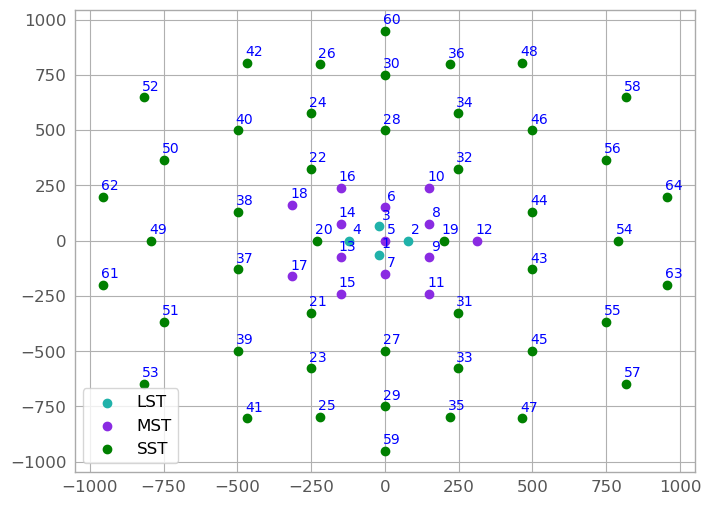

In [8]:
# Loop through all the telescopes
#for fov in array.table["fov"]:
#    print(fov)
colors = [
    'lightseagreen' if np.isclose(fov, 14.5356) else
    'blueviolet' if np.isclose(fov, 46.707) else 
    'green' if np.isclose(fov, 62.462) else
    'red'  # Default color if none of the conditions match
    for fov in array.table["fov"]
]
fov_labels = {
    'lightseagreen': 'LST',
    'blueviolet': 'MST',
    'green': 'SST'
}
for i in range(len(array.table)):
    plt.scatter(array.table['x'][i], array.table['y'][i], c=colors[i], label=fov_labels[colors[i]])

    # Annotate each point with the telescope ID
    #matplotlib.pyplot.annotate(text, xy, xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None, **kwargs)
#Annotate the point xy with text text.
#In the simplest form, the text is placed at xy.
    plt.annotate(str(array.table["id"][i]),
                 (array.table['x'][i], array.table['y'][i]),  # Point position
                 textcoords="offset points",  # Text position relative to the point
                 xytext=(5, 5),  # Offset in pixels (to avoid overlapping the point)
                 ha='center', fontsize=10, color='blue')
handles, labels = plt.gca().get_legend_handles_labels()
#handles, labels like this is doing
    #plt.gca() gets the current Axes object, which is where your plot is
    #.get_legend_handles_labels()
        #handles: Returns a list of the graphical elements (e.g., lines, scatter plot points) that would appear in the legend.
        # labels: Returns the text labels associated with each graphical element in handles

by_label = dict(zip(labels, handles))  # Remove duplicate labels, the dictionary by the structure takes out the double 
plt.legend(by_label.values(), by_label.keys())
#by_label.values This is pulling out the unique graphical elements
# by_label.keys  This is retrieving the unique text 
plt.savefig("./different_telescopes.png", dpi=300, bbox_inches="tight")
plt.show() 

## Check the hyper field of view (hFoV)

This is the whole telescope array hFoV maybe? (ask)

In [9]:
array.hFoV(m_cut=3) 

64it [00:08,  7.28it/s]


(62.238869377690584, 57.415086388537716)

In [10]:
#array.hFoV(m_cut=3)

## Grouping telescopes

In [11]:
sub_groups={'1':[7,8,11], 
            '2': [5,13,16,18],
            '3': [14,15,17], 
            '4': [6,10,12,9]}
sub_groups_2 = {'1':[18,17,16,14], 
                '2': [13,15,5,7],
                '3': [6,8,10],
                '4': [9,11,12]
              }
#sub_groups_2={'1':[18,14,13,17],
#             '2':[7,11,15],
#             '3':[5,8,9,12],
#            '4':[16,6,10]}


second_best={'1':[16,18,13], 
            '2': [14,14,15],
            '3': [5,6,10,9], 
            '4': [7,8,11,12]}
overposition = {'1':[18,10,12,13], 
                '2':[14,15,17],
                '3': [6,7,9,11],
                '4': [16,8,5]
              }
sub_groups_3={'1':[16,9,17],
             '2':[10,14,18],
             '3':[6,8,7,12],
             '4':[13,5,11,15]}
sub_groups_4={'1':[16,9,17],
             '2':[10,14,18],
             '3':[15,5,8,12],
             '4':[13,6,11,7]}


In [12]:
def compute_center_of_gravity(group):
    x, y, z = group['x'], group['y'], group['z']
    cog_x = round(np.mean(x),2)
    cog_y = round(np.mean(y),2)
    cog_z = round(np.mean(z),2)
    return cog_x, cog_y, cog_z

# Function to create new telescope list with center of gravity
def create_new_group_list(tel_group):
    new_telescopes = []
    for group in tel_group.groups:
        print(tel_group.groups)
        print (group['focal'][0],round(group['radius'][0],2))
        #id_ = group["id"][0]
        cog = compute_center_of_gravity(group)
        focal, fov = group['focal'][0], round(group['radius'][0],2)  # Assuming same within a group
        new_telescopes.append([*cog, focal, fov])
    return new_telescopes


In [13]:
tel_group_2, labels_2, number_of_telescopes_subarray_2 =array.group_by(sub_groups_2)
#tel_group_3, labels_3 = group_by(array, group=only_MST)

In [14]:
tel_group, labels, number_of_telescopes_subarray_1 =array.group_by(sub_groups)

In [15]:
tel_group_3, labels_3, number_of_telescopes_subarray_3 =array.group_by(sub_groups_3)
tel_group_4, labels_4, number_of_telescopes_subarray_4 =array.group_by(sub_groups_4)

In [16]:
# Step 2: Create new telescope list with center of gravity
new_telescopes = create_new_group_list(tel_group)
new_telescopes_2 = create_new_group_list(tel_group_2)
new_telescopes_3 = create_new_group_list(tel_group_3)
new_telescopes_4 = create_new_group_list(tel_group_4)
#Why are you creating an extra telescope?


<TableGroups indices=[ 0 50 53 57 60 64]>
28.0 2.15
<TableGroups indices=[ 0 50 53 57 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 57 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 57 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 57 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 58 61 64]>
28.0 2.15
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 56 60 64]>
28.0 2.15
<TableGroups indices=[ 0 50 53 56 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 56 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 56 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 56 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 56 60 64]>
28.0 2.15
<TableGroups indices=[ 0 50 53 56 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 56 60 64]>
16.0 3.85
<TableGroups indices=[ 0 50 53 56 60 64]>
16.0 3.85
<TableGroups

In [17]:
#del new_telescopes[0]# Step 3: Output the result
#for telescope in new_telescopes:
#    print(telescope)
del new_telescopes[0]#No clue why it keeps on putting me an extra telescope...soooo... I deleted it... I will find out why
for telescope in new_telescopes:
    print(telescope)

[100.0, -105.33, 27.33, 16.0, 3.85]
[-153.25, 81.75, 27.38, 16.0, 3.85]
[-204.33, -109.0, 33.83, 16.0, 3.85]
[153.25, 79.0, 23.5, 16.0, 3.85]


In [18]:
del new_telescopes_2[0]
for telescope in new_telescopes_2:
    print(telescope)


[-231.5, 78.75, 30.12, 16.0, 3.85]
[-75.0, -116.5, 30.38, 16.0, 3.85]
[100.0, 155.33, 23.33, 16.0, 3.85]
[204.33, -105.0, 25.0, 16.0, 3.85]


In [19]:
del new_telescopes_3[0]
for telescope in new_telescopes_3:
    print(telescope)
del new_telescopes_4[0]
for telescope in new_telescopes_4:
    print(telescope)


[-104.33, 1.0, 29.33, 16.0, 3.85]
[-104.33, 159.0, 27.5, 16.0, 3.85]
[115.75, 18.75, 24.0, 16.0, 3.85]
[-37.5, -138.75, 30.12, 16.0, 3.85]
[-104.33, 1.0, 29.33, 16.0, 3.85]
[-104.33, 159.0, 27.5, 16.0, 3.85]
[78.25, -41.25, 25.62, 16.0, 3.85]
[0.0, -78.75, 28.5, 16.0, 3.85]


In [20]:
new_telescopes_4

[[-104.33, 1.0, 29.33, 16.0, 3.85],
 [-104.33, 159.0, 27.5, 16.0, 3.85],
 [78.25, -41.25, 25.62, 16.0, 3.85],
 [0.0, -78.75, 28.5, 16.0, 3.85]]

In [21]:
# Define the file path where you want to save the output
output_file_path = './subarray_1_2_SOUTH.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path}")


New telescope data has been written to ./subarray_1_2_SOUTH.txt


In [22]:
range(len(array.telescopes))

range(0, 64)

In [23]:
# Define the file path where you want to save the output
output_file_path_2 = 'subarray_2_SOUTH.txt'

# Open the file in write mode
with open(output_file_path_2, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes_2):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path_2}")


New telescope data has been written to subarray_2_SOUTH.txt


In [24]:
# Define the file path where you want to save the output
output_file_path_3 = 'subarray_3_SOUTH.txt'

# Open the file in write mode
with open(output_file_path_3, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes_3):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path_3}")


New telescope data has been written to subarray_3_SOUTH.txt


In [25]:
# Define the file path where you want to save the output
output_file_path_4 = 'subarray_4_SOUTH.txt'

# Open the file in write mode
with open(output_file_path_4, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes_4):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path_4}")


New telescope data has been written to subarray_4_SOUTH.txt


## SANITY CHECK

In [26]:
#array_3.table

# THE FIELD OF VIEW

## GRAPHING MULTIPLICITY AND FOV to understand what is going on 

In [27]:
array= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
array_2= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
array_3= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, pointing2src=True)
array_4 = LoadConfig("./subarray_4_SOUTH.txt", frame=cta, pointing2src=True)

In [28]:
array.table

<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1   100.0 -105.33   27.33   0.000 ...   1.000  -0.000   0.000  156.04
    2 -153.25   81.75   27.38   0.000 ...   1.000  -0.000   0.000  158.82
    3 -204.33  -109.0   33.83   0.000 ...   1.000  -0.000   0.000  202.35
    4  153.25    79.0    23.5   0.000 ...   1.000  -0.000   0.000  201.79

In [29]:
full_array.table

<Table length=14>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1     0.0     0.0    24.0   0.000 ...   1.000  -0.000   0.000   22.65
    2     0.0   151.0    25.0   0.000 ...   1.000  -0.000   0.000  152.67
    3     0.0  -151.0    31.0   0.000 ...   1.000  -0.000   0.000  152.68
    4   150.0    75.0    21.0   0.000 ...   1.000  -0.000   0.000  188.09
    5   150.0   -75.0    26.0   0.000 ...   1.000  -0.000   0.000  187.98
    6   150.0   240.0    24.0   0.000 ...   1.000  -0.000   0.000  295.50
    7   150.0  -240.0    30.0   0.000 ...   1.000  -0.000   0.000  295.49
    8   313.0     0.0    19.0   0.000 ...   1.000  -0.000   0.000  335.47
    9  -150.0   -75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   10  -150.0    75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   11  -150.0  -240.0    38.5   0.000 ...   1.000  -0.000   0.000  272.05
   12  -150.0   240.0    27.0   0.000 ...   1.000  -0.000   0.000  271.83
   13  -313.0  -162.0    35.0   0.000 ...   1.000  -0.000   0.000  332.82
   14  -313.0   162.0    30.5   0.000 ...   1.000  -0.000   0.000  332.75

In [30]:
array.table

<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1   100.0 -105.33   27.33   0.000 ...   1.000  -0.000   0.000  156.04
    2 -153.25   81.75   27.38   0.000 ...   1.000  -0.000   0.000  158.82
    3 -204.33  -109.0   33.83   0.000 ...   1.000  -0.000   0.000  202.35
    4  153.25    79.0    23.5   0.000 ...   1.000  -0.000   0.000  201.79

In [31]:
full_array.divergent_pointing(0.05, az=0,alt=70)

In [32]:
full_array.hFoV(m_cut=3)[0]

14it [00:01,  7.41it/s]


0.4589887122248568

In [33]:
full_array.hFoV()[0]

14it [00:01,  7.32it/s]


390.2715450231926

14it [00:01,  7.46it/s]
14it [00:01,  7.14it/s]


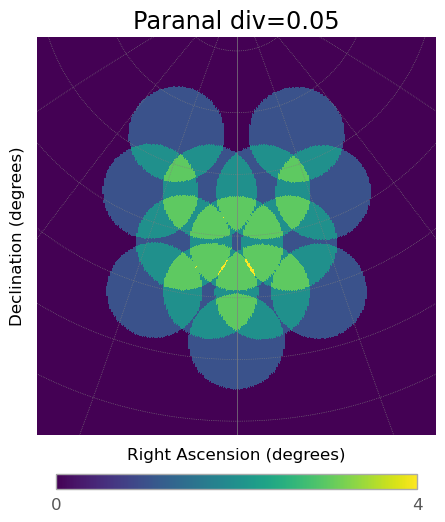

In [34]:
full_array.multiplicity_plot()

In [35]:
div=[]

div=np.linspace(0,0.1, 15)
div_no_saturation_full_array=[]#So we can get an array with all the divergence in the full_array
div_no_saturation_sub_1=[]
div_no_saturation_sub_2=[]
div_no_saturation_sub_3=[]
div_no_saturation_sub_4=[]

In [36]:
FoV_full_array=[]
multiplicity_full_array=[]
for divergence in div:
    full_array.divergent_pointing(divergence, az=0,alt=70)
    if full_array.hFoV(m_cut=3)[0] != 0: #To get the no saturation
        FoV=full_array.hFoV(m_cut=3)[0]
        multiplicity=full_array.hFoV(m_cut=3)[1]
        FoV_full_array.append(FoV)
        multiplicity_full_array.append(multiplicity)
        div_no_saturation_full_array.append(divergence)

14it [00:01,  7.41it/s]
14it [00:01,  7.39it/s]
14it [00:01,  7.25it/s]
14it [00:01,  7.48it/s]
14it [00:01,  7.25it/s]
14it [00:01,  7.40it/s]
14it [00:01,  7.46it/s]
14it [00:01,  7.33it/s]
14it [00:01,  7.39it/s]
14it [00:01,  7.29it/s]
14it [00:01,  7.33it/s]
14it [00:01,  7.38it/s]
14it [00:02,  6.82it/s]
14it [00:01,  7.35it/s]
14it [00:01,  7.25it/s]
14it [00:01,  7.42it/s]
14it [00:01,  7.22it/s]
14it [00:01,  7.34it/s]
14it [00:01,  7.41it/s]
14it [00:01,  7.49it/s]
14it [00:01,  7.29it/s]
14it [00:01,  7.48it/s]
14it [00:01,  7.46it/s]
14it [00:01,  7.35it/s]
14it [00:01,  7.25it/s]
/Users/macbook/miniconda3/envs/divtel/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/macbook/miniconda3/envs/divtel/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
14it [00:01,  7.42it/s

In [37]:
div_no_saturation_full_array

[0.0,
 0.0071428571428571435,
 0.014285714285714287,
 0.02142857142857143,
 0.028571428571428574,
 0.03571428571428572,
 0.04285714285714286,
 0.05]

In [38]:
array.table

<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1   100.0 -105.33   27.33   0.000 ...   1.000  -0.000   0.000  156.04
    2 -153.25   81.75   27.38   0.000 ...   1.000  -0.000   0.000  158.82
    3 -204.33  -109.0   33.83   0.000 ...   1.000  -0.000   0.000  202.35
    4  153.25    79.0    23.5   0.000 ...   1.000  -0.000   0.000  201.79

In [39]:
FoV_array_complete=[]
multiplicity_array_complete=[]
FoV_array=[]#This will be the one without saturation
multiplicity_array=[] #This will be the one without saturation
for divergence in div:
    array.divergent_pointing(divergence, az=0,alt=70)    
    FoV=array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0]
    multiplicity=array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1]
    FoV_array_complete.append(FoV)
    multiplicity_array_complete.append(multiplicity)
    

4it [00:00,  6.18it/s]
4it [00:00,  7.34it/s]
4it [00:00,  7.19it/s]
4it [00:00,  7.46it/s]
4it [00:00,  7.17it/s]
4it [00:00,  7.17it/s]
4it [00:00,  7.19it/s]
4it [00:00,  7.27it/s]
4it [00:00,  7.17it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.38it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.24it/s]
4it [00:00,  7.49it/s]
4it [00:00,  7.12it/s]
4it [00:00,  7.45it/s]
4it [00:00,  7.41it/s]
4it [00:00,  7.18it/s]
4it [00:00,  7.44it/s]
4it [00:00,  7.41it/s]
4it [00:00,  7.42it/s]
4it [00:00,  7.47it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.22it/s]
4it [00:00,  7.37it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.47it/s]
4it [00:00,  7.15it/s]
4it [00:00,  7.61it/s]
4it [00:00,  7.47it/s]


In [40]:

FoV_array=[]#This will be the one without saturation
multiplicity_array=[] #This will be the one without saturation
div_no_saturation_sub_1=[]
for i in range(np.size(FoV_array_complete)-1):
        if np.round(FoV_array_complete[i+1])!=np.round(FoV_array_complete[i]):
            FoV_array.append(FoV_array_complete[i])
            multiplicity_array.append(multiplicity_array_complete[i])
print(np.size(FoV_array))
div_stop=np.size(FoV_array)
div_no_saturation_sub_1=div[:div_stop] 
print(FoV_array)

10
[46.42342975074266, 62.606060347470475, 80.2967967129371, 99.11533391415622, 118.68136701814156, 138.99489602489308, 158.6658408345298, 170.53397753634394, 178.12696223286372, 183.76596641162627]


In [41]:
div_no_saturation_sub_1

array([0.        , 0.00714286, 0.01428571, 0.02142857, 0.02857143,
       0.03571429, 0.04285714, 0.05      , 0.05714286, 0.06428571])

In [42]:
array_2.table

<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1  -231.5   78.75   30.12   0.000 ...   1.000  -0.000   0.000  243.03
    2   -75.0  -116.5   30.38   0.000 ...   1.000  -0.000   0.000  140.96
    3   100.0  155.33   23.33   0.000 ...   1.000  -0.000   0.000  182.44
    4  204.33  -105.0    25.0   0.000 ...   1.000  -0.000   0.000  231.67

In [43]:
FoV_array_complete_2=[]
multiplicity_array_complete_2=[]
FoV_array_2=[]#This will be the one without saturation
multiplicity_array_2=[] #This will be the one without saturation
for divergence in div:
    array_2.divergent_pointing(divergence, az=0,alt=70)    
    FoV=array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[0]
    multiplicity=array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[1]
    FoV_array_complete_2.append(FoV)
    multiplicity_array_complete_2.append(multiplicity)
    
FoV_array_2=[]#This will be the one without saturation
multiplicity_array_2=[] #This will be the one without saturation
div_no_saturation_sub_2=[]


4it [00:00,  7.56it/s]
4it [00:00,  7.32it/s]
4it [00:00,  7.36it/s]
4it [00:00,  7.37it/s]
4it [00:00,  7.14it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.33it/s]
4it [00:00,  7.48it/s]
4it [00:00,  7.48it/s]
4it [00:00,  7.26it/s]
4it [00:00,  7.37it/s]
4it [00:00,  7.48it/s]
4it [00:00,  7.39it/s]
4it [00:00,  7.32it/s]
4it [00:00,  7.48it/s]
4it [00:00,  7.41it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.59it/s]
4it [00:00,  7.41it/s]
4it [00:00,  7.46it/s]
4it [00:00,  7.26it/s]
4it [00:00,  7.52it/s]
4it [00:00,  7.10it/s]
4it [00:00,  7.25it/s]
4it [00:00,  7.54it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.23it/s]
4it [00:00,  7.41it/s]
4it [00:00,  7.30it/s]
4it [00:00,  7.50it/s]


In [44]:

for i in range(np.size(FoV_array_complete_2)-1):
        if np.round(FoV_array_complete_2[i+1])!=np.round(FoV_array_complete_2[i]):
            FoV_array_2.append(FoV_array_complete_2[i])
            multiplicity_array_2.append(multiplicity_array_complete_2[i])
print(np.size(FoV_array_2))
div_stop_2=np.size(FoV_array_2)
div_no_saturation_sub_2=div[:div_stop_2] 
print(FoV_array_2)

8
[46.42342975074266, 65.1895110991361, 85.62106577474543, 107.87546133604778, 130.89046676332273, 154.43003071885468, 174.55996424071625, 184.8019695049338]


In [45]:
# SUBARRAY 3 

FoV_array_complete_3=[]
multiplicity_array_complete_3=[]
FoV_array_3=[]#This will be the one without saturation
multiplicity_array_3=[] #This will be the one without saturation
for divergence in div:
    array_3.divergent_pointing(divergence, az=0,alt=70)    
    FoV=array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[0]
    multiplicity=array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[1]
    FoV_array_complete_3.append(FoV)
    multiplicity_array_complete_3.append(multiplicity)
    
FoV_array_3=[]#This will be the one without saturation
multiplicity_array_3=[] #This will be the one without saturation
div_no_saturation_sub_3=[]

for i in range(np.size(FoV_array_complete_3)-1):
        if np.round(FoV_array_complete_3[i+1])!=np.round(FoV_array_complete_3[i]):
            FoV_array_3.append(FoV_array_complete_3[i])
            multiplicity_array_3.append(multiplicity_array_complete_3[i])
print(np.size(FoV_array_3))
div_stop_3=np.size(FoV_array_3)
div_no_saturation_sub_3=div[:div_stop_3] 
print(FoV_array_3)

4it [00:00,  7.56it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.50it/s]
4it [00:00,  7.30it/s]
4it [00:00,  7.32it/s]
4it [00:00,  7.23it/s]
4it [00:00,  7.21it/s]
4it [00:00,  7.46it/s]
4it [00:00,  7.49it/s]
4it [00:00,  7.48it/s]
4it [00:00,  7.20it/s]
4it [00:00,  7.38it/s]
4it [00:00,  7.28it/s]
4it [00:00,  7.47it/s]
4it [00:00,  7.45it/s]
4it [00:00,  7.00it/s]
4it [00:00,  7.23it/s]
4it [00:00,  7.12it/s]
4it [00:00,  7.47it/s]
4it [00:00,  7.29it/s]
4it [00:00,  7.38it/s]
4it [00:00,  7.57it/s]
4it [00:00,  7.29it/s]
4it [00:00,  7.52it/s]
4it [00:00,  7.45it/s]
4it [00:00,  7.53it/s]
4it [00:00,  7.53it/s]
4it [00:00,  7.50it/s]
4it [00:00,  7.41it/s]
4it [00:00,  7.38it/s]

12
[46.42342975074266, 59.275113693038655, 72.80872372206872, 87.29965306516777, 102.24957112049168, 117.60602203521475, 133.00181483955708, 148.04353063732597, 161.70828029842028, 172.63221164937187, 178.73020454035924, 183.52991507391062]


In [46]:
# SUBARRAY 4

FoV_array_complete_4=[]
multiplicity_array_complete_4=[]
FoV_array_4=[]#This will be the one without saturation
multiplicity_array_4=[] #This will be the one without saturation
for divergence in div:
    array_4.divergent_pointing(divergence, az=0,alt=70)    
    FoV=array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4)[0]
    multiplicity=array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4)[1]
    FoV_array_complete_4.append(FoV)
    multiplicity_array_complete_4.append(multiplicity)
    
FoV_array_4=[]#This will be the one without saturation
multiplicity_array_4=[] #This will be the one without saturation
div_no_saturation_sub_4=[]

for i in range(np.size(FoV_array_complete_4)-1):
        if np.round(FoV_array_complete_4[i+1])!=np.round(FoV_array_complete_4[i]):
            FoV_array_4.append(FoV_array_complete_4[i])
            multiplicity_array_4.append(multiplicity_array_complete_4[i])
print(np.size(FoV_array_4))
div_stop_4=np.size(FoV_array_4)
div_no_saturation_sub_4=div[:div_stop_4] 
print(FoV_array_4)

4it [00:00,  7.16it/s]
4it [00:00,  7.51it/s]
4it [00:00,  7.47it/s]
4it [00:00,  7.09it/s]
4it [00:00,  7.42it/s]
4it [00:00,  7.49it/s]
4it [00:00,  7.30it/s]
4it [00:00,  7.50it/s]
4it [00:00,  7.38it/s]
4it [00:00,  7.52it/s]
4it [00:00,  7.44it/s]
4it [00:00,  7.25it/s]
4it [00:00,  7.54it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.47it/s]
4it [00:00,  7.55it/s]
4it [00:00,  7.29it/s]
4it [00:00,  7.42it/s]
4it [00:00,  7.51it/s]
4it [00:00,  7.53it/s]
4it [00:00,  7.51it/s]
4it [00:00,  7.41it/s]
4it [00:00,  7.38it/s]
4it [00:00,  7.44it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.56it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.41it/s]
4it [00:00,  7.53it/s]

14
[46.42342975074266, 56.79657464702443, 67.4975686234668, 78.60509545930834, 90.06669930172333, 101.63321484978972, 113.04236283937902, 123.75647077902782, 133.8148805583554, 143.11268047171035, 151.55807277664772, 158.81009442980047, 164.37041482932443, 168.81604835630233]


In [47]:
print(len(div), len(FoV_full_array), len(FoV_array))

15 8 10


In [48]:
## First to start understanding what is going on I wanted to graph in the 4 plots together 

In [49]:
FoV_array

[46.42342975074266,
 62.606060347470475,
 80.2967967129371,
 99.11533391415622,
 118.68136701814156,
 138.99489602489308,
 158.6658408345298,
 170.53397753634394,
 178.12696223286372,
 183.76596641162627]

In [50]:
FoV_array_2

[46.42342975074266,
 65.1895110991361,
 85.62106577474543,
 107.87546133604778,
 130.89046676332273,
 154.43003071885468,
 174.55996424071625,
 184.8019695049338]

In [51]:
number_of_telescopes_subarray_2

[4, 4, 3, 3]

In [52]:
number_of_telescopes_subarray_3

[3, 3, 4, 4]

## PENSAR COMO AUTOMIZAR LO SIGUIENTE EL FOV CHE STUDIO TIENE QUE SER SI O SI DEL FULL ARRAY CON EL MINIMO DEL ARRAY DE TELESCOPIOS QUE TENGO PRARA PODER CONFRONTAR MEJOR. En cambio no poner ningun limite para los subarrays

In [53]:
number_of_telescopes_subarray_1

[3, 4, 3, 4]

# hFoV and multiplicities graphs 

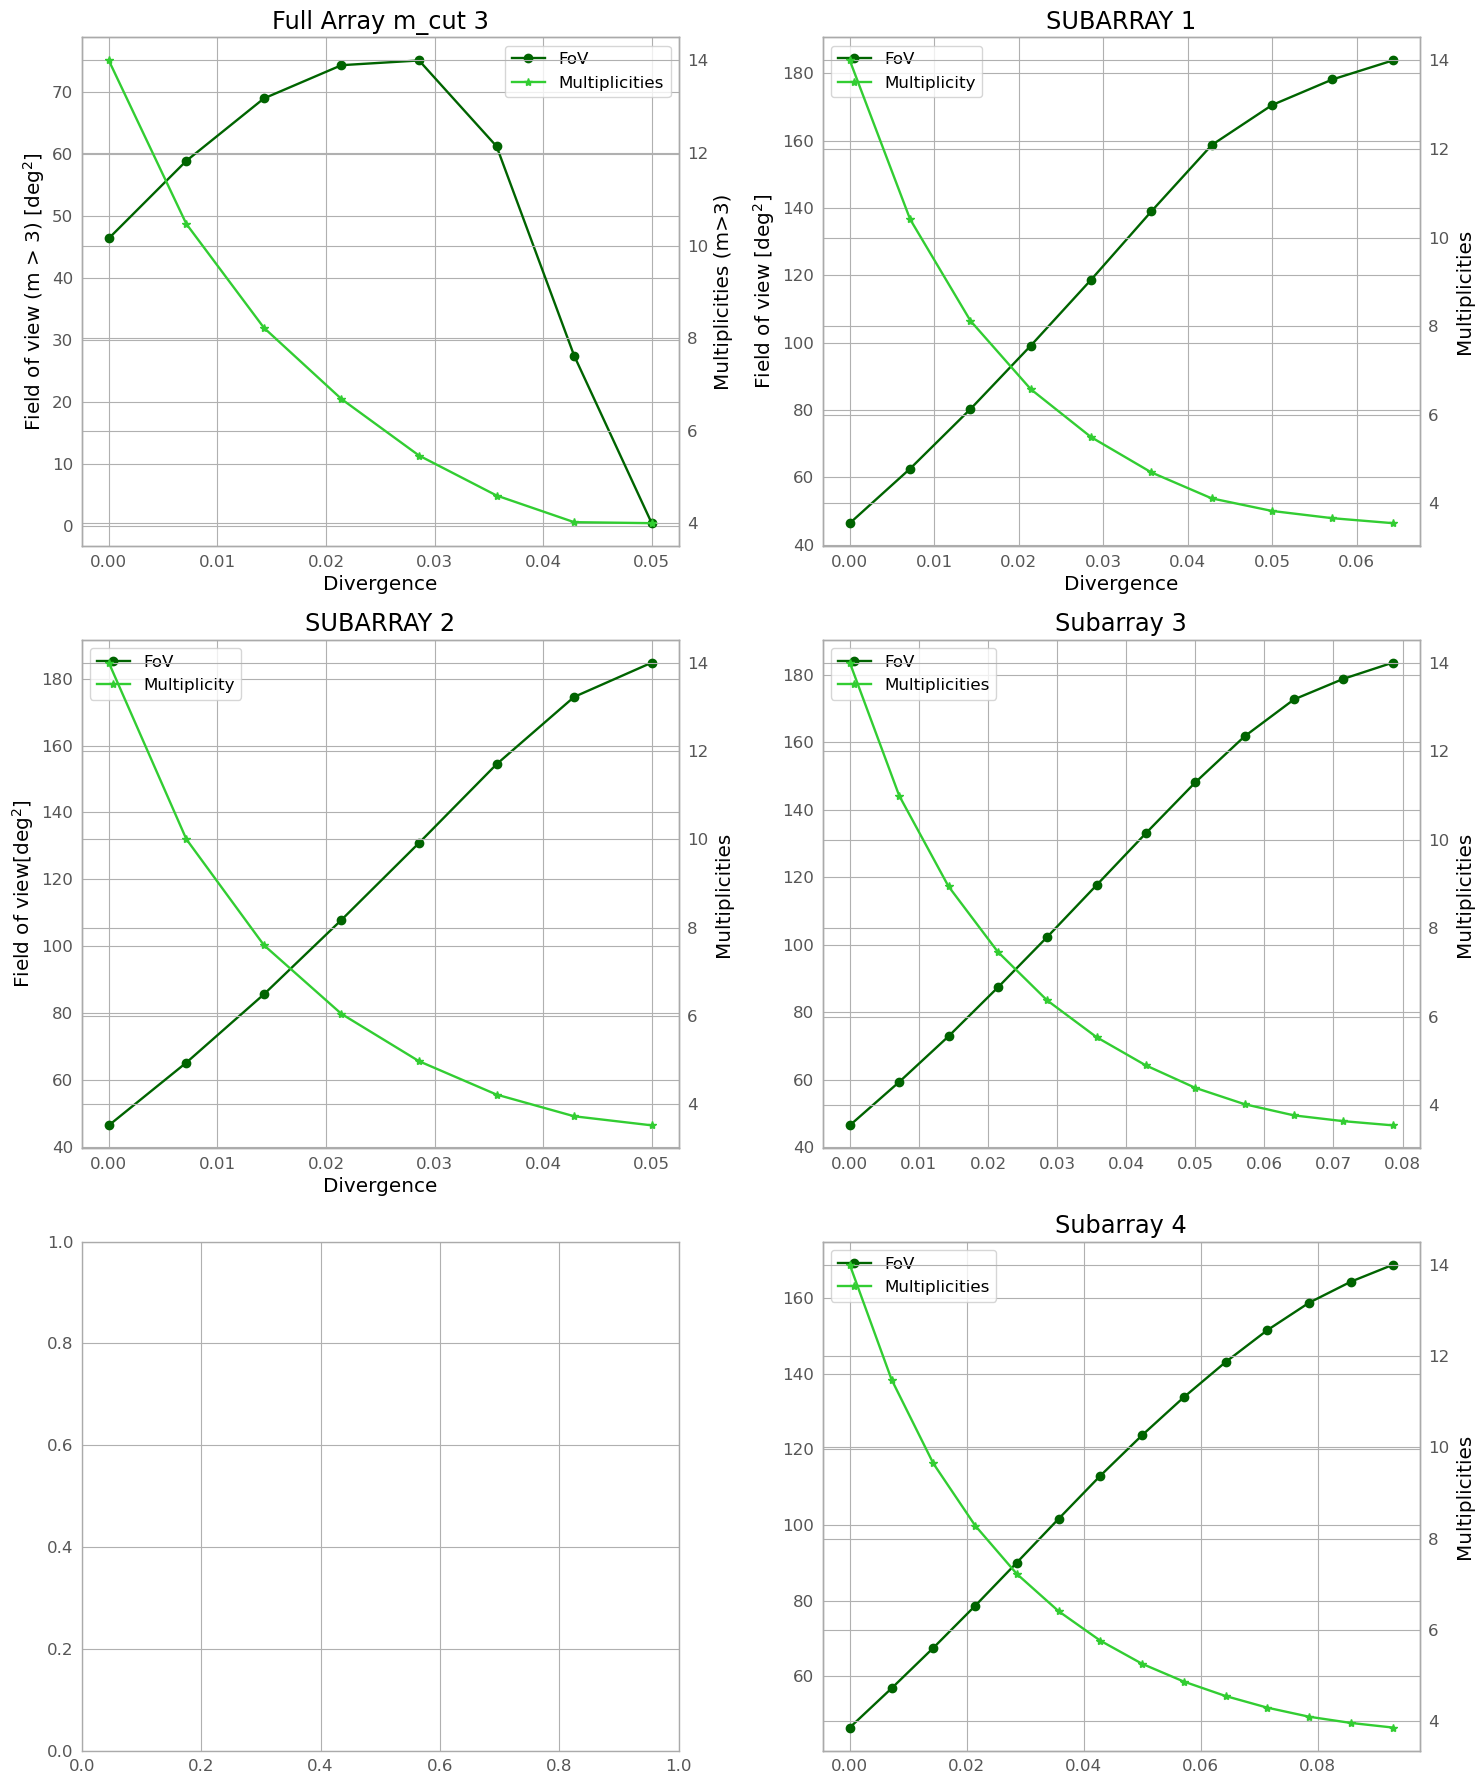

In [54]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18)) 
# Plot Full Array
# Full Array with m_cut = 3
l1=axes[0,0].plot(div_no_saturation_full_array, FoV_full_array, label='FoV', marker='o', color='darkgreen')
ax2 = axes[0,0].twinx()
l2=ax2.plot(div_no_saturation_full_array, multiplicity_full_array, label='Multiplicities',marker='*', color='limegreen')
axes[0,0].set_title('Full Array m_cut 3')
axes[0,0].set_xlabel('Divergence')
axes[0,0].set_ylabel('Field of view (m > 3) [deg$^2$]')
ax2.set_ylabel('Multiplicities (m>3)')
axeslegend = l1+l2
axes[0,0].legend(axeslegend, [l.get_label() for l in axeslegend])



#Plot the ones for subarray 1
l1=axes[0,1].plot(div_no_saturation_sub_1, FoV_array, label='FoV',marker='o', color='darkgreen')
ax5=axes[0,1].twinx()
l2=ax5.plot(div_no_saturation_sub_1, multiplicity_array, label='Multiplicity', marker='*', color='limegreen')
axes[0,1].set_title('SUBARRAY 1')
axes[0,1].set_xlabel('Divergence')
axes[0,1].set_ylabel('Field of view [deg$^2$]')
ax5.set_ylabel('Multiplicities')
axeslegend = l1+l2
axes[0,1].legend(axeslegend, [l.get_label() for l in axeslegend])
#Plot the ones for subarray 2
l1=axes[1,0].plot(div_no_saturation_sub_2, FoV_array_2, label='FoV',marker='o', color='darkgreen')
ax5=axes[1,0].twinx()
l2=ax5.plot(div_no_saturation_sub_2, multiplicity_array_2, label='Multiplicity', marker='*', color='limegreen')
axes[1,0].set_title('SUBARRAY 2')
axes[1,0].set_xlabel('Divergence')
axes[1,0].set_ylabel('Field of view[deg$^2$]')
ax5.set_ylabel('Multiplicities')
axeslegend = l1+l2
axes[1,0].legend(axeslegend, [l.get_label() for l in axeslegend])

# Subarray 3
l1=axes[1,1].plot(div_no_saturation_sub_3, FoV_array_3, label='FoV',marker='o', color='darkgreen')
ax3 = axes[1,1].twinx()
l2=ax3.plot(div_no_saturation_sub_3,multiplicity_array_3, label='Multiplicities', marker='*', color='limegreen')
plt.title('Subarray 3')
plt.xlabel('Divergence')
plt.ylabel('Field of view  [deg$^2$]')
plt.ylabel('Multiplicities')
axeslegend = l1+l2
axes[1,1].legend(axeslegend, [l.get_label() for l in axeslegend])
# Adjust layout
plt.tight_layout()
# Subarray 4
l1=axes[2,1].plot(div_no_saturation_sub_4, FoV_array_4, label='FoV',marker='o', color='darkgreen')
ax3 = axes[2,1].twinx()
l2=ax3.plot(div_no_saturation_sub_4,multiplicity_array_4, label='Multiplicities', marker='*', color='limegreen')
plt.title('Subarray 4')
plt.xlabel('Divergence')
plt.ylabel('Field of view  [deg$^2$]')
plt.ylabel('Multiplicities')
axeslegend = l1+l2
axes[2,1].legend(axeslegend, [l.get_label() for l in axeslegend])
# Adjust layout
plt.tight_layout()


plt.show()

In [55]:
#mask[:100]
multiplicity_full_array

[14.0,
 10.466622162883844,
 8.222538958570885,
 6.682948333627226,
 5.460813405480887,
 4.5971746575342465,
 4.021469465648855,
 4.0]

In [56]:
 FoV_full_array

[46.42342975074266,
 58.934150649671615,
 69.00567439220562,
 74.36928534363324,
 75.12989520960585,
 61.26843610041517,
 27.486866880665712,
 0.4589887122248568]

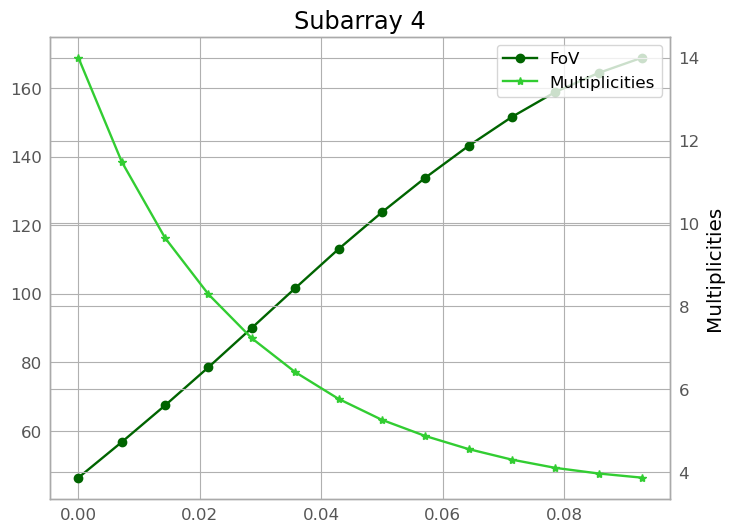

In [57]:
# Plot array 4

l1=plt.plot(div_no_saturation_sub_4, FoV_array_4, label='FoV',marker='o', color='darkgreen')
ax3 = plt.twinx()
l2=ax3.plot(div_no_saturation_sub_4,multiplicity_array_4, label='Multiplicities', marker='*', color='limegreen')
plt.title('Subarray 4')
plt.xlabel('Divergence')
plt.ylabel('Field of view  [deg$^2$]')
plt.ylabel('Multiplicities')
axeslegend = l1+l2
plt.legend(axeslegend, [l.get_label() for l in axeslegend])
plt.show()

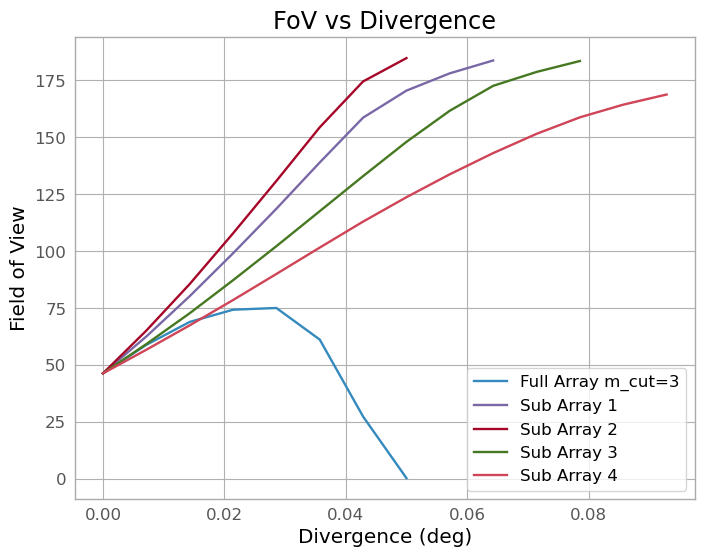

In [58]:
plt.plot(div_no_saturation_full_array, FoV_full_array, label='Full Array m_cut=3')

plt.plot(div_no_saturation_sub_1, FoV_array, label='Sub Array 1')
plt.plot(div_no_saturation_sub_2, FoV_array_2, label='Sub Array 2')
plt.plot(div_no_saturation_sub_3, FoV_array_3, label='Sub Array 3')
plt.plot(div_no_saturation_sub_4, FoV_array_4, label='Sub Array 4')
# Add labels and title
plt.xlabel("Divergence (deg)")  
plt.ylabel("Field of View")  
plt.title("FoV vs Divergence")  

# Add legend
plt.legend()

# Display the plot
plt.show()

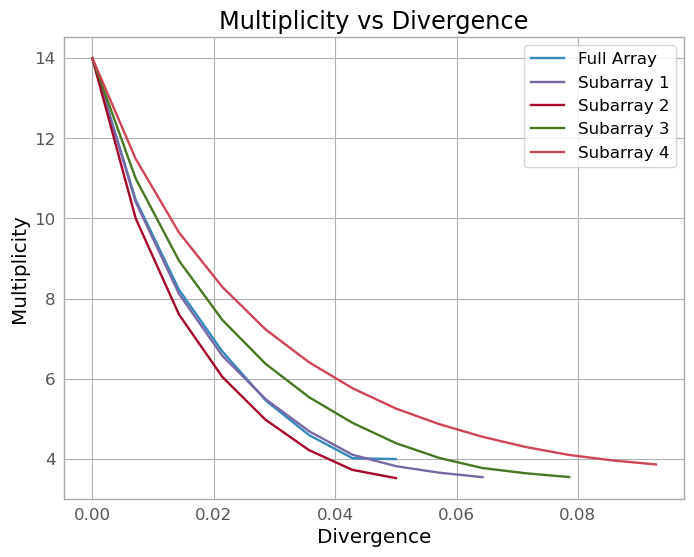

In [59]:

plt.plot(div_no_saturation_full_array, multiplicity_full_array, label='Full Array')
plt.plot(div_no_saturation_sub_1,  multiplicity_array, label='Subarray 1')
plt.plot(div_no_saturation_sub_2,  multiplicity_array_2, label='Subarray 2')
plt.plot(div_no_saturation_sub_3,  multiplicity_array_3, label='Subarray 3')
plt.plot(div_no_saturation_sub_4,  multiplicity_array_4, label='Subarray 4')
plt.xlabel("Divergence")  
plt.ylabel("Multiplicity")  # Y-axis label
plt.title("Multiplicity vs Divergence")  # Title of the plot
plt.legend()
plt.show()

In [60]:
print(f"The FoV difference between subarray 1 and 2", np.mean(FoV_array)/np.mean(FoV_array_2))
print(f"The FoV difference between subarray 2 and 3", np.mean(FoV_array_2)/np.mean(FoV_array_3))
print(f"The FoV difference between subarray 1 and 3", np.mean(FoV_array)/np.mean(FoV_array_3))
print(f"The FoV differenve between subarray 1 and the full array m_cut=3 is", np.mean(FoV_full_array)/np.mean(FoV_array) )
print(f"The FoV differenve between subarray 2 and the full array m_cut=3 is", np.mean(FoV_full_array)/np.mean(FoV_array_2) )
print(f"The FoV differenve between subarray 3 and the full array m_cut=3 is", np.mean(FoV_full_array)/np.mean(FoV_array_3) )

The FoV difference between subarray 1 and 2 1.0420898572335902
The FoV difference between subarray 2 and 3 0.9736073272153715
The FoV difference between subarray 1 and 3 1.0145863206194436
The FoV differenve between subarray 1 and the full array m_cut=3 is 0.4173468089842384
The FoV differenve between subarray 2 and the full array m_cut=3 is 0.4349128765912794
The FoV differenve between subarray 3 and the full array m_cut=3 is 0.4234343633495843


In [61]:
FoV_array = np.array(FoV_array)
FoV_array_2 = np.array(FoV_array_2)
#FoV_mult_cut_2_array = np.array(FoV_full_array_mult_cut_2)
FoV_array_3=np.array(FoV_array_3)
FoV_array_4=np.array(FoV_array_4)

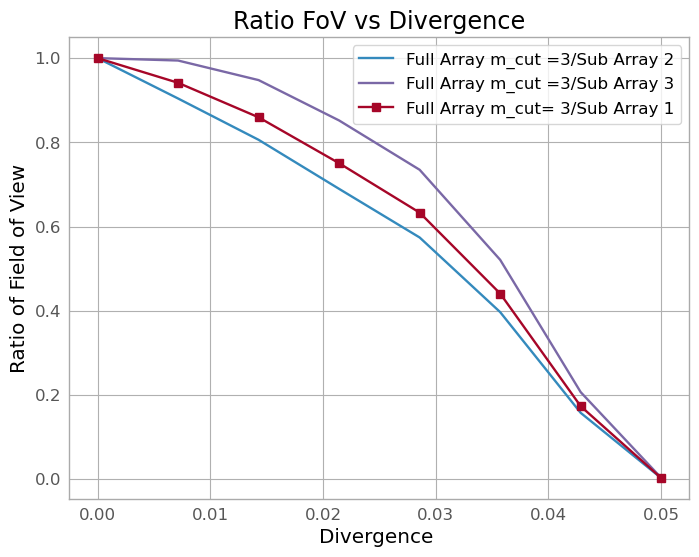

In [62]:

stop=np.size(FoV_full_array)
plt.plot(div_no_saturation_full_array, FoV_full_array/FoV_array_2[:stop], label='Full Array m_cut =3/Sub Array 2')
plt.plot(div_no_saturation_full_array, FoV_full_array/FoV_array_3[:stop], label='Full Array m_cut =3/Sub Array 3')
plt.plot(div_no_saturation_full_array, FoV_full_array/FoV_array[:stop], label='Full Array m_cut= 3/Sub Array 1', marker='s')

plt.xlabel("Divergence ")  
plt.ylabel("Ratio of Field of View")  
plt.title("Ratio FoV vs Divergence")  
plt.legend()

plt.show()

In [63]:
#hfov = hp.nside2pixarea(nside, True)*np.sum(mask_fov)
multiplicity_full_array

[14.0,
 10.466622162883844,
 8.222538958570885,
 6.682948333627226,
 5.460813405480887,
 4.5971746575342465,
 4.021469465648855,
 4.0]

In [64]:
multiplicity_full_array = np.array(multiplicity_full_array)
multiplicity_array_2 = np.array(multiplicity_array_2)
multiplicity_array_3 = np.array(multiplicity_array_3)
multiplicity_array = np.array(multiplicity_array)
multiplicity_array_4 = np.array(multiplicity_array_4)
#multiplicity_full_array_mult_2 = np.array(multiplicity_full_array_mult_cut_2)

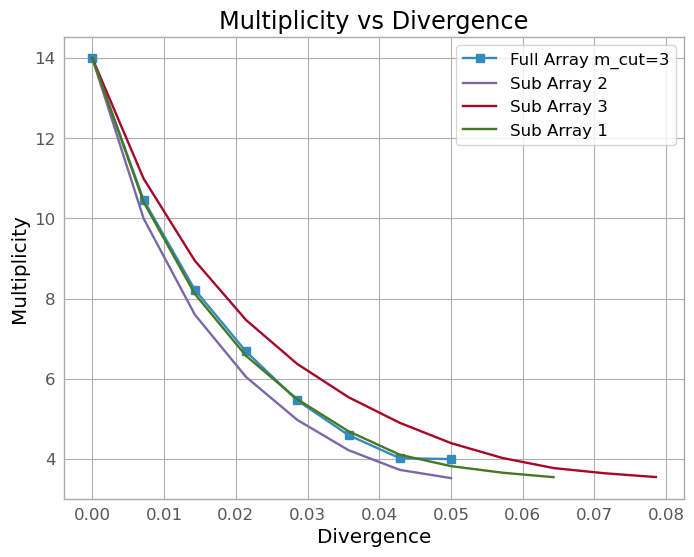

In [65]:
plt.plot(div_no_saturation_full_array, multiplicity_full_array, label='Full Array m_cut=3', marker='s')
plt.plot(div_no_saturation_sub_2,  multiplicity_array_2, label='Sub Array 2')
plt.plot(div_no_saturation_sub_3,  multiplicity_array_3, label='Sub Array 3')
plt.plot(div_no_saturation_sub_1,  multiplicity_array, label='Sub Array 1')
#plt.plot(div[:10],  multiplicity_full_array_mult_cut_2[:10], label='Full Array m_cut=2', marker='s')
plt.xlabel("Divergence")  
plt.ylabel("Multiplicity")  # Y-axis label
plt.title("Multiplicity vs Divergence")  # Title of the plot
plt.legend()
plt.show()

In [66]:
print(np.mean(multiplicity_array_2)/np.mean(multiplicity_array))

1.0497108944254376


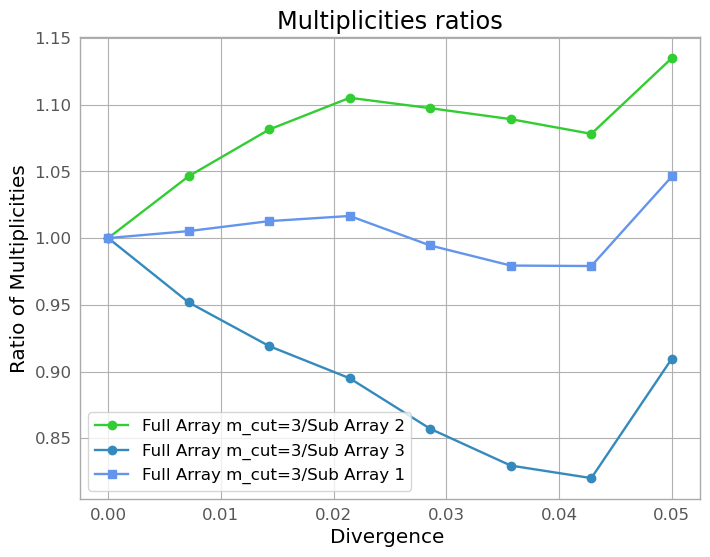

In [67]:
#plt.plot(div[:12], multiplicity_full_array[:12]/multiplicity_array[:12], label='Full Array m_cut=3/Sub Array 1', color='blue', marker='s')
plt.plot(div_no_saturation_full_array, multiplicity_full_array/multiplicity_array_2[:stop], label='Full Array m_cut=3/Sub Array 2', color='limegreen', marker='o')
plt.plot(div_no_saturation_full_array, multiplicity_full_array/multiplicity_array_3[:stop], label='Full Array m_cut=3/Sub Array 3', marker='o')
plt.plot(div_no_saturation_full_array, multiplicity_full_array/multiplicity_array[:stop], label='Full Array m_cut=3/Sub Array 1', color='cornflowerblue', marker='s')
#plt.plot(div[:12], multiplicity_full_array_mult_cut_2[:12]/multiplicity_array_2[:12], label='Full Array m_cut=2/Sub Array 2', color='darkgreen', marker='o')

plt.xlabel("Divergence ")  
plt.ylabel("Ratio of Multiplicities")  
plt.title("Multiplicities ratios")  
plt.legend()

plt.show()
#print(multiplicity_full_array[5])
#print(multiplicity_array[5])
#1.62/4.15

plt.plot(div_no_saturation_sub_1, multiplicity_array_2[:10]/multiplicity_array)
plt.title('Multiplicity Plot')
plt.show()

## SHOWING WHAT HAPPENS RUGHT AFTER 0.05 

array.divergent_pointing(div=0.05, az=0, alt=70)
array.multiplicity_plot(number_of_telescopes_subarray_1)
array_2.divergent_pointing(div=0.05, az=0, alt=70)
array_2.multiplicity_plot(number_of_telescopes_subarray_2)
array_3.divergent_pointing(div=0.05, az=0, alt=70)
array_3.multiplicity_plot(number_of_telescopes_subarray_3)
array_4.multiplicity_plot(number_of_telescopes_subarray_4)
array_4.divergent_pointing(div=0.05, az=0, alt=70)

array.divergent_pointing(div=0.06, az=0, alt=70)
array.multiplicity_plot(number_of_telescopes_subarray_1)
array_3.divergent_pointing(div=0.06, az=0, alt=70)
array_3.multiplicity_plot(number_of_telescopes_subarray_3)

{'barycenter': <mpl_toolkits.mplot3d.art3d.Line3DCollection object at 0x127bad280>}


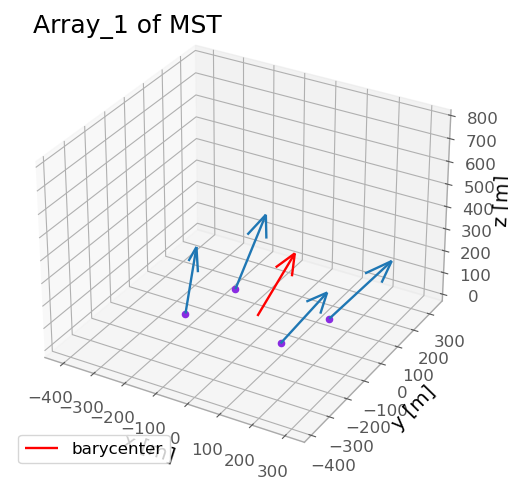

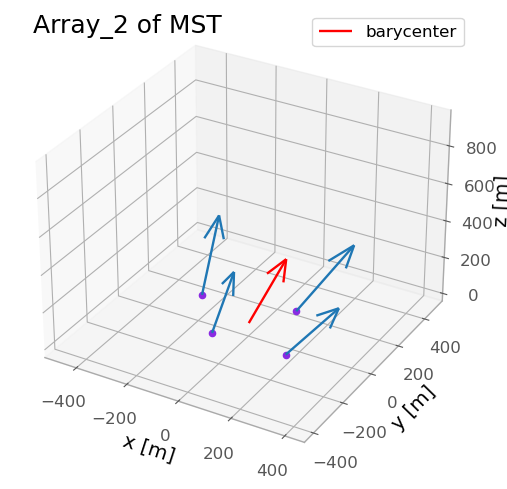

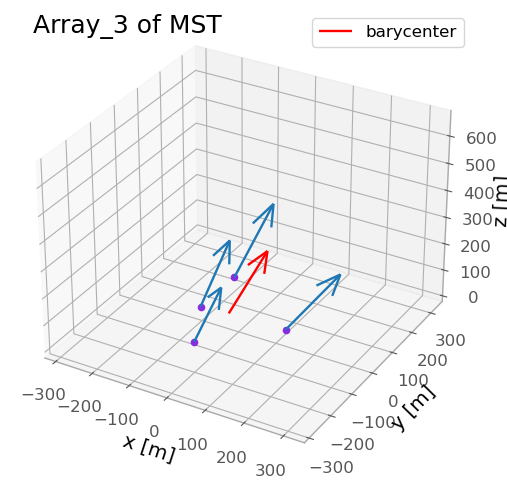

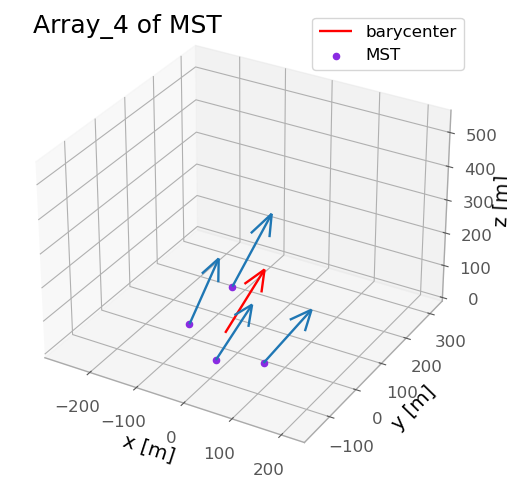

In [68]:
#array_alt_1.display("xyz")
#fig = plt.figure()
ax = array.display("xyz")
ax_2 = array_2.display("xyz")
ax_3 = array_3.display("xyz")
ax_4 = array_4.display("xyz")
colors = [
    'lightseagreen' if np.isclose(fov, 14.5356) else
    'blueviolet' if np.isclose(fov, 46.707) else 
    'green' if np.isclose(fov, 62.462) else
    'red'  # Default color if none of the conditions match
    for fov in array.table["fov"]
]
fov_labels = {
    'lightseagreen': 'LST',
    'blueviolet': 'MST',
    'green': 'SST'
}
colors_2 = [
    'lightseagreen' if np.isclose(fov, 14.5356) else
    'blueviolet' if np.isclose(fov, 46.707) else 
    'green' if np.isclose(fov, 62.462) else
    'red'  # Default color if none of the conditions match
    for fov in array.table["fov"]
]
fov_labels_2 = {
    'lightseagreen': 'LST',
    'blueviolet': 'MST',
    'green': 'SST'
}
colors_3 = [
    'lightseagreen' if np.isclose(fov, 14.5356) else
    'blueviolet' if np.isclose(fov, 46.707) else 
    'green' if np.isclose(fov, 62.462) else
    'red'  # Default color if none of the conditions match
    for fov in array.table["fov"]
]
fov_labels_3 = {
    'lightseagreen': 'LST',
    'blueviolet': 'MST',
    'green': 'SST'
}

#array_3.display("xyz",color=c,label=label)

for i in range(len(array.table)):
    # Color each telescope point according to the FoV
    ax.scatter(array.table['x'][i], array.table['y'][i], array.table['z'][i], 
               color=colors[i], label=fov_labels[colors[i]])

# Display a legend with unique labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

ax.legend(by_label.values(), by_label.keys(), loc='lower left')
ax.text2D(0.05, 0.95, "Array_1 of MST ", 
          transform=ax.transAxes, fontsize=18)


#SECOND ALTITUDE



for i in range(len(array_2.table)):
    # Color each telescope point according to the FoV
    ax_2.scatter(array_2.table['x'][i], array_2.table['y'][i], array_2.table['z'][i], 
               color=colors_2[i], label=fov_labels_2[colors_2[i]])

# Display a legend with unique labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
print(by_label)
ax_2.legend(by_label.values(), by_label.keys())
ax_2.text2D(0.05, 0.95, "Array_2 of MST", 
            transform=ax_2.transAxes, fontsize=18)


#THIRD ARRAY


for i in range(len(array_3.table)):
    # Color each telescope point according to the FoV
    ax_3.scatter(array_3.table['x'][i], array_3.table['y'][i], array_3.table['z'][i], 
               color=colors_3[i], label=fov_labels_3[colors_3[i]])

# Display a legend with unique labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax_3.legend(by_label.values(), by_label.keys())
ax_3.text2D(0.05, 0.95, "Array_3 of MST", 
            transform=ax_3.transAxes, fontsize=18)
#Fourth Array
for i in range(len(array_4.table)):
    # Color each telescope point according to the FoV
    ax_4.scatter(array_4.table['x'][i], array_4.table['y'][i], array_4.table['z'][i], 
               color=colors_3[i], label=fov_labels_3[colors_3[i]])

# Display a legend with unique labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax_4.legend(by_label.values(), by_label.keys())
ax_4.text2D(0.05, 0.95, "Array_4 of MST", 
            transform=ax_4.transAxes, fontsize=18)

plt.legend(by_label.values(), by_label.keys())

plt.show()
##SST IN GREEN 
#VIOLET ARE THE MST 
#LIGHT GREEN IS THE LST 

# MULTIPLICITY PLOTS WITH THE RANGES 

In [76]:
##Puting the stop to when we expect the divergence to be too much for us to have cross overs between the different FoV of the single telescopes
stop=0.036 #From what we saw in the previous slides 
stop_div=[]
for div in div_no_saturation_sub_1:
    print(np.round(div,3))
    #print("stop is:")
    #print(stop)
    if np.round(div, 3)  <= stop:
        print(div)
        stop_div.append(div)
array_slice_stop = np.size(stop_div) #This is to slice the array

0.0
0.0
0.007
0.0071428571428571435
0.014
0.014285714285714287
0.021
0.02142857142857143
0.029
0.028571428571428574
0.036
0.03571428571428572
0.043
0.05
0.057
0.064


14it [00:01,  7.11it/s]
14it [00:02,  6.66it/s]


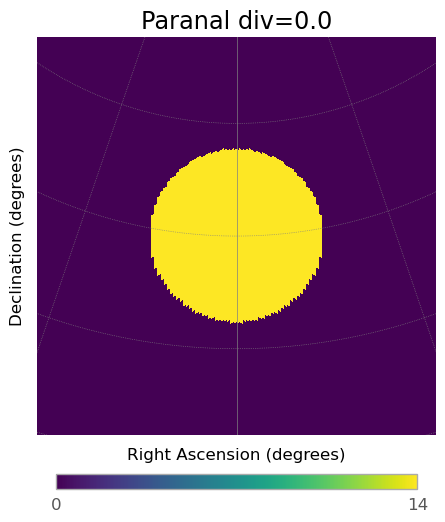

14it [00:01,  7.23it/s]
14it [00:01,  7.09it/s]


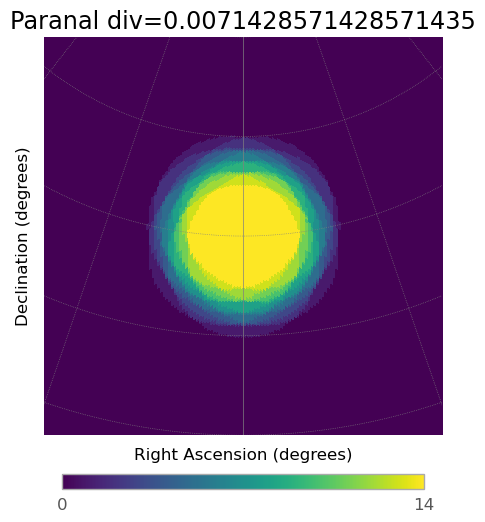

14it [00:01,  7.31it/s]
14it [00:01,  7.03it/s]


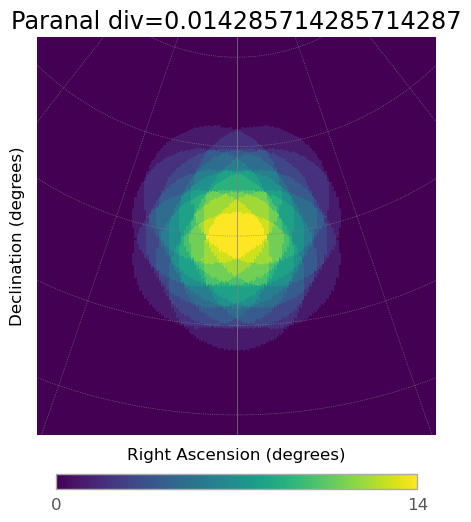

14it [00:01,  7.06it/s]
14it [00:02,  6.98it/s]


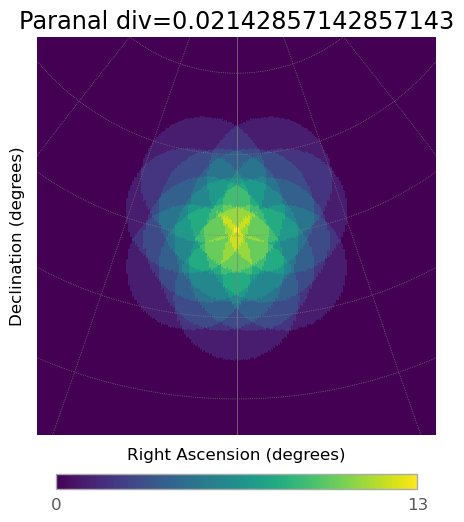

14it [00:02,  6.99it/s]
14it [00:02,  6.95it/s]


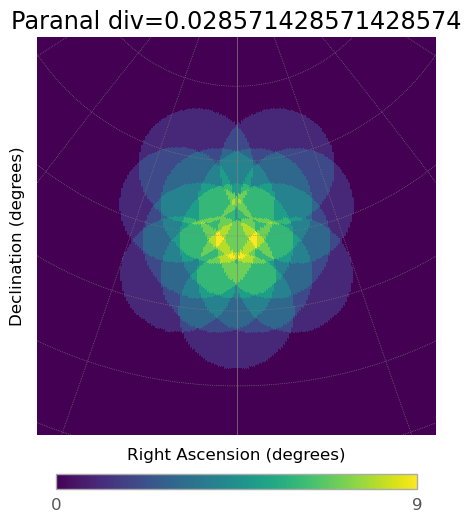

14it [00:01,  7.22it/s]
14it [00:01,  7.08it/s]


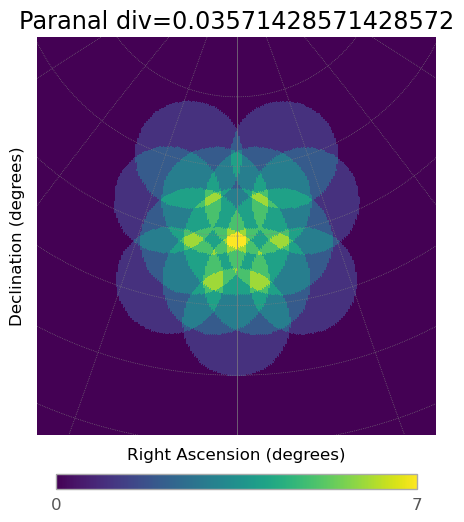

In [77]:
for divergence in stop_div:
    full_array.divergent_pointing(div=divergence, az=0, alt=70)
    full_array.multiplicity_plot()


4it [00:00,  7.33it/s]
4it [00:00,  7.05it/s]


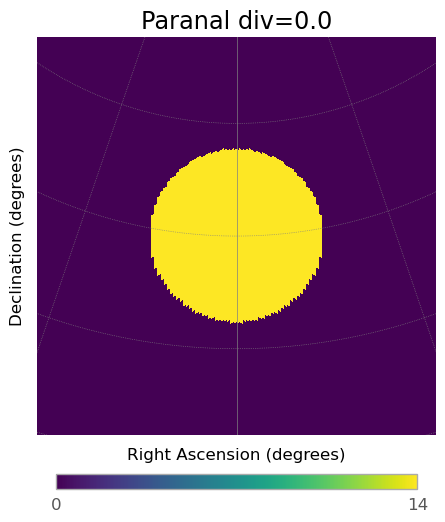

4it [00:00,  6.92it/s]
4it [00:00,  6.27it/s]


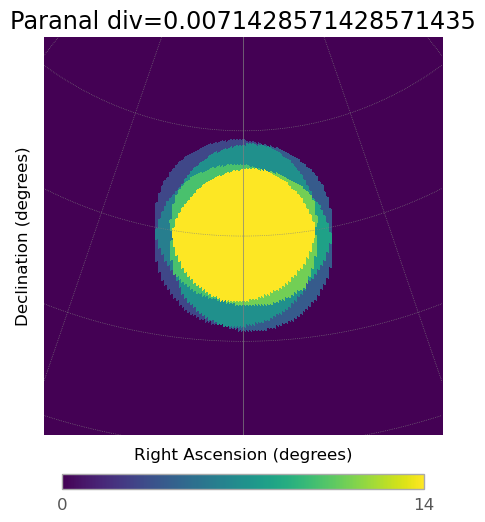

4it [00:00,  7.19it/s]
4it [00:00,  6.82it/s]


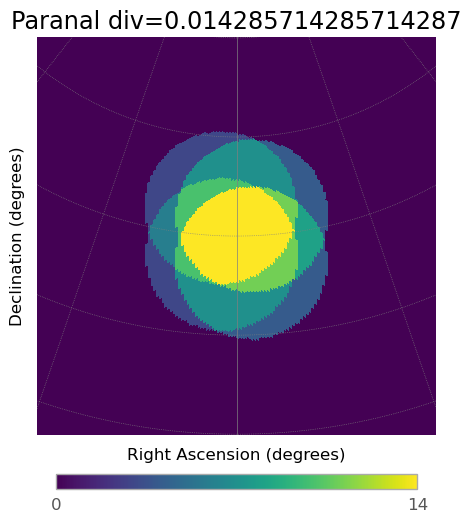

4it [00:00,  7.13it/s]
4it [00:00,  6.84it/s]


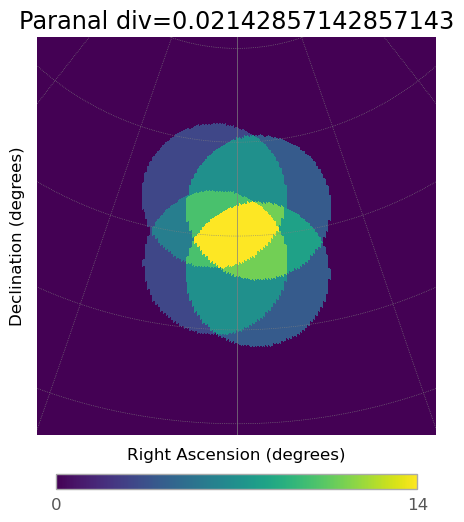

4it [00:00,  7.07it/s]
4it [00:00,  6.57it/s]


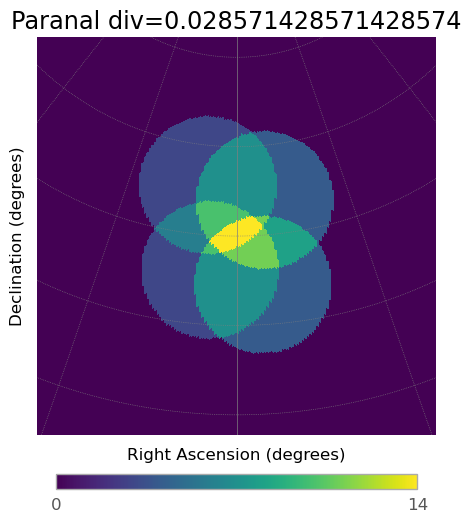

4it [00:00,  6.97it/s]
4it [00:00,  6.59it/s]


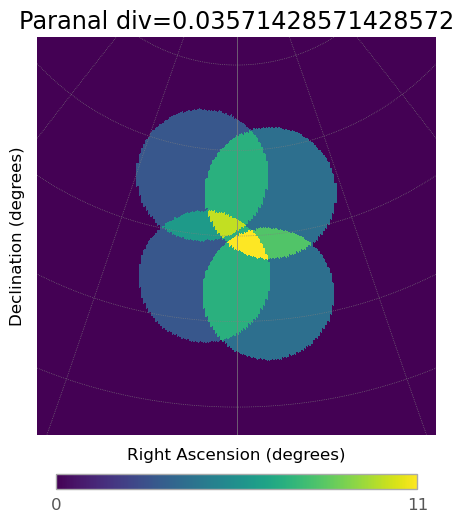

In [78]:
for divergence in stop_div:
    array.divergent_pointing(div=divergence, az=0, alt=70)
    array.multiplicity_plot(number_of_telescopes_subarray_1)

4it [00:00,  7.23it/s]
4it [00:00,  6.69it/s]


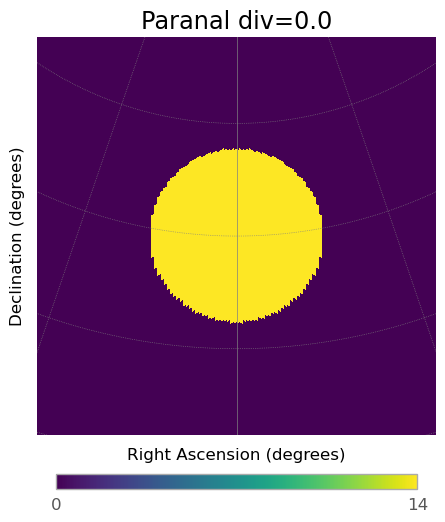

4it [00:00,  7.34it/s]
4it [00:00,  7.03it/s]


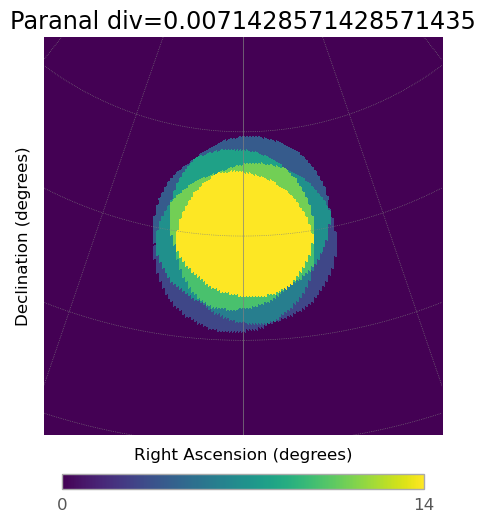

4it [00:00,  7.16it/s]
4it [00:00,  6.47it/s]


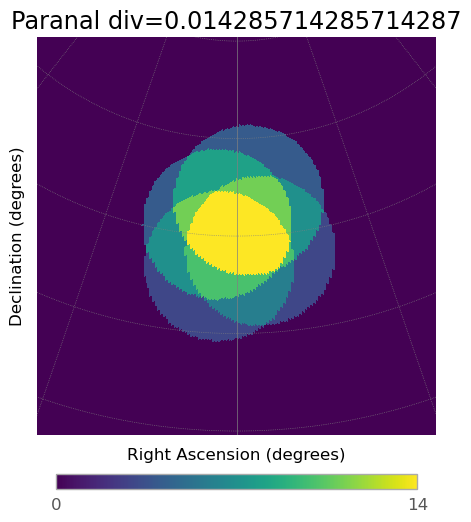

4it [00:00,  7.46it/s]
4it [00:00,  6.91it/s]


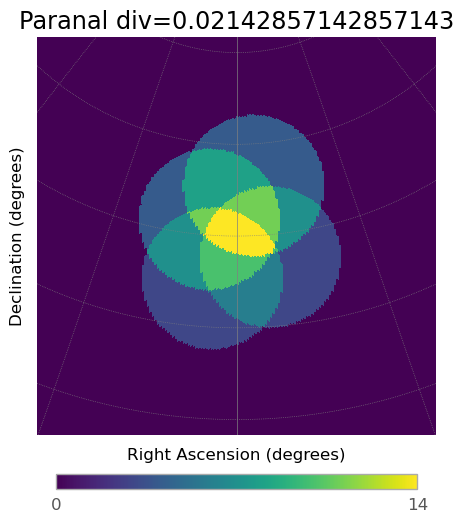

4it [00:00,  6.95it/s]
4it [00:00,  6.87it/s]


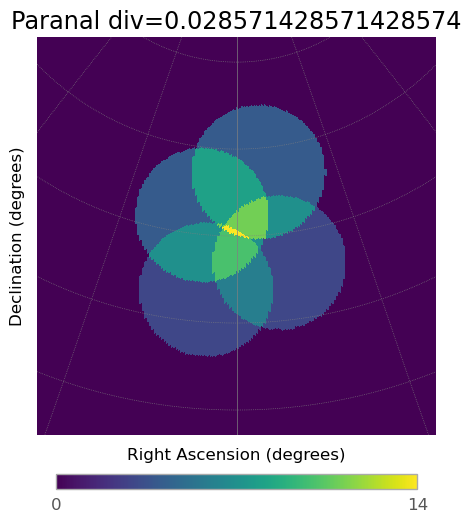

4it [00:00,  7.53it/s]
4it [00:00,  7.08it/s]


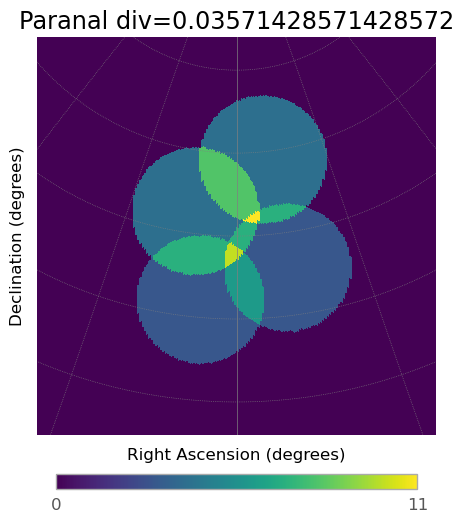

In [79]:
for divergence in stop_div:
    array_2.divergent_pointing(div=divergence, az=0, alt=70)
    array_2.multiplicity_plot(number_of_telescopes_subarray_2)

4it [00:00,  7.27it/s]
4it [00:00,  6.84it/s]


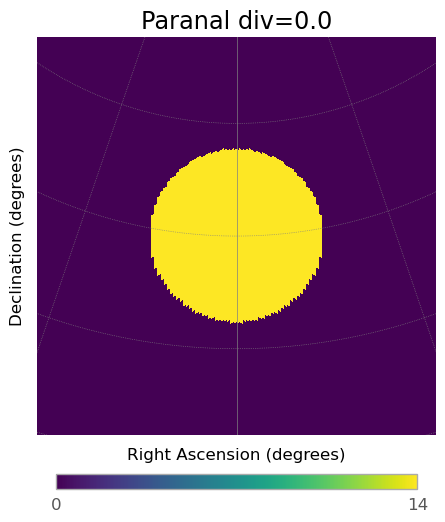

4it [00:00,  7.19it/s]
4it [00:00,  6.35it/s]


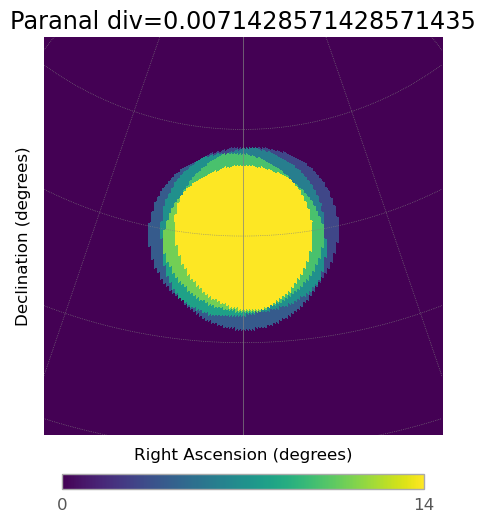

4it [00:00,  7.27it/s]
4it [00:00,  6.62it/s]


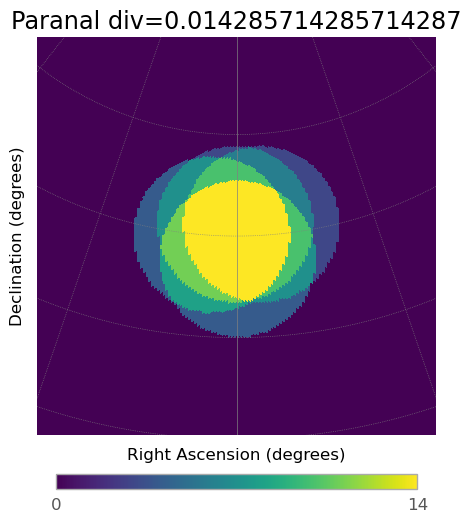

4it [00:00,  7.03it/s]
4it [00:00,  6.58it/s]


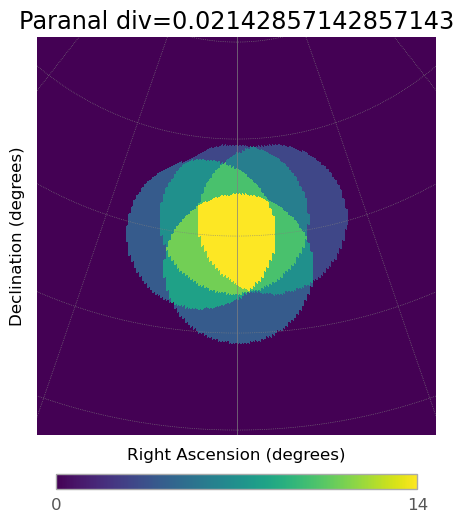

4it [00:00,  7.15it/s]
4it [00:00,  6.64it/s]


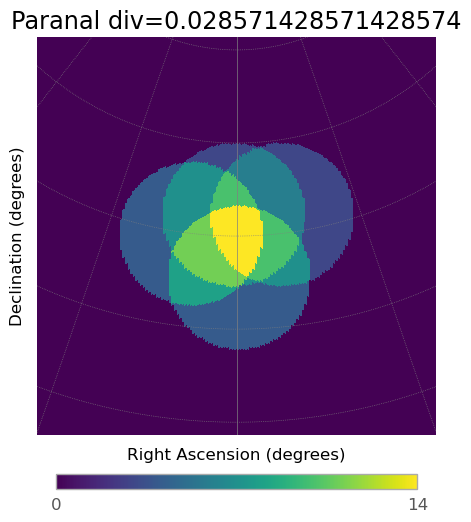

4it [00:00,  7.17it/s]
4it [00:00,  6.91it/s]


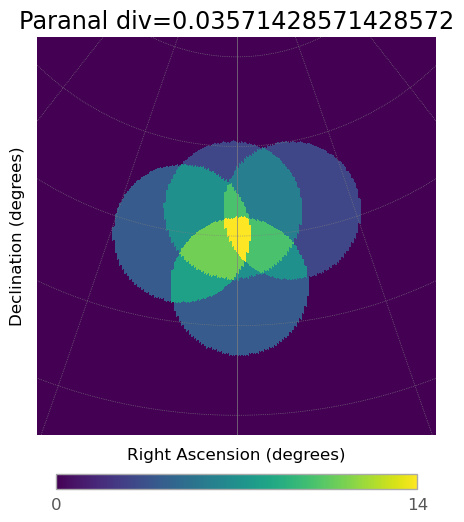

In [80]:
for divergence in stop_div:
    array_3.divergent_pointing(div=divergence, az=0, alt=70)
    array_3.multiplicity_plot(number_of_telescopes_subarray_3)

4it [00:00,  6.14it/s]
4it [00:00,  6.86it/s]


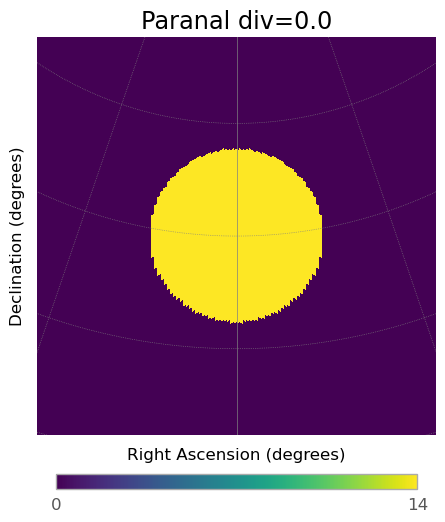

4it [00:00,  7.25it/s]
4it [00:00,  6.89it/s]


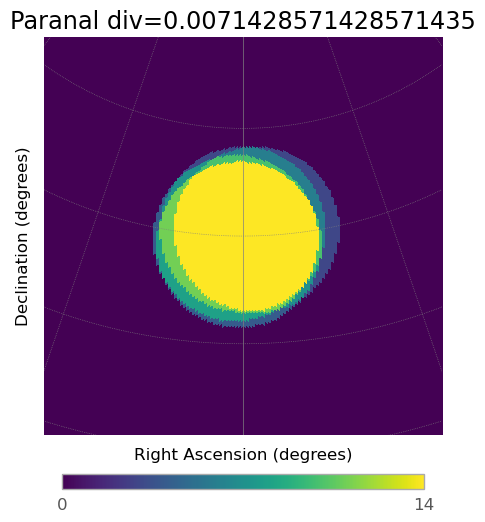

4it [00:00,  7.05it/s]
4it [00:00,  6.52it/s]


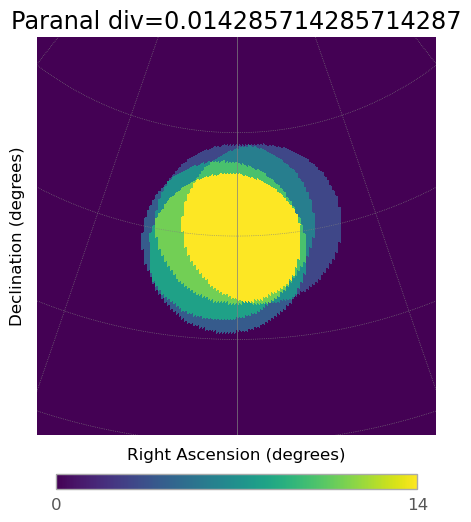

4it [00:00,  7.26it/s]
4it [00:00,  7.06it/s]


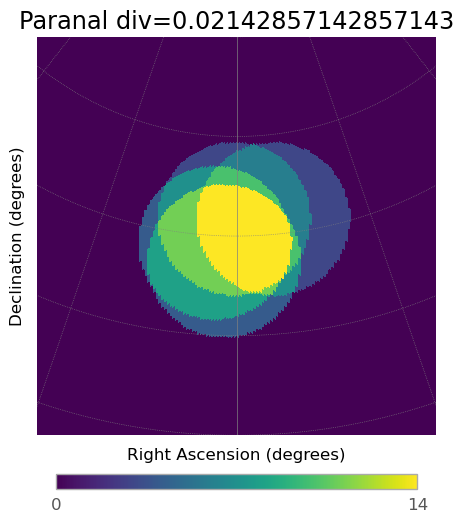

4it [00:00,  7.40it/s]
4it [00:00,  6.76it/s]


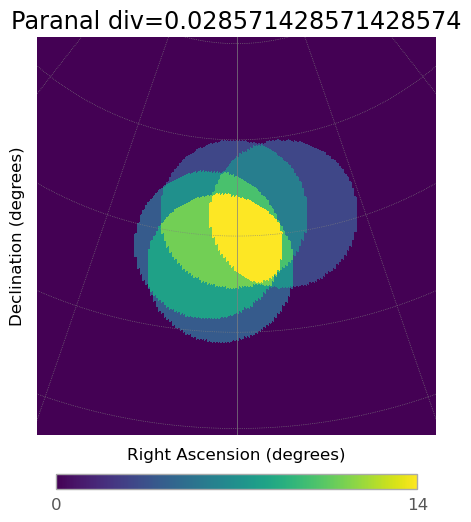

4it [00:00,  7.19it/s]
4it [00:00,  6.92it/s]


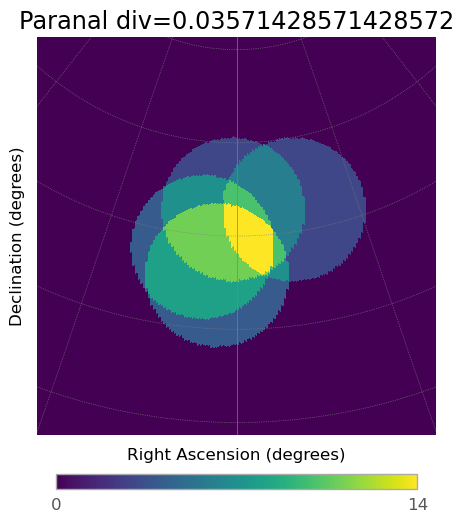

In [81]:
for divergence in stop_div:
    array_4.divergent_pointing(div=divergence, az=0, alt=70)
    array_4.multiplicity_plot(number_of_telescopes_subarray_3)

In [82]:
#FoV in 0.021 for sub 2 and 0.023 for sub 3
FoV_array


array([ 46.42342975,  62.60606035,  80.29679671,  99.11533391,
       118.68136702, 138.99489602, 158.66584083, 170.53397754,
       178.12696223, 183.76596641])

In [83]:
FoV_array_2

array([ 46.42342975,  65.1895111 ,  85.62106577, 107.87546134,
       130.89046676, 154.43003072, 174.55996424, 184.8019695 ])

In [84]:
div_no_saturation_sub_1

array([0.        , 0.00714286, 0.01428571, 0.02142857, 0.02857143,
       0.03571429, 0.04285714, 0.05      , 0.05714286, 0.06428571])

In [85]:
FoV_array_3

array([ 46.42342975,  59.27511369,  72.80872372,  87.29965307,
       102.24957112, 117.60602204, 133.00181484, 148.04353064,
       161.7082803 , 172.63221165, 178.73020454, 183.52991507])

In [86]:
FoV_array_4

array([ 46.42342975,  56.79657465,  67.49756862,  78.60509546,
        90.0666993 , 101.63321485, 113.04236284, 123.75647078,
       133.81488056, 143.11268047, 151.55807278, 158.81009443,
       164.37041483, 168.81604836])

In [87]:
multiplicity_array

array([14.        , 10.41223293,  8.11938592,  6.57409368,  5.49138122,
        4.69393339,  4.10752955,  3.82351584,  3.66008982,  3.54791979])

In [88]:
multiplicity_array_2

array([14.        , 10.00281633,  7.60392097,  6.04728908,  4.97645527,
        4.2210428 ,  3.730148  ,  3.52469486])

In [89]:
multiplicity_array_3

array([14.        , 10.99734513,  8.94704611,  7.46777828,  6.37155316,
        5.54214987,  4.90356932,  4.39746656,  4.02781607,  3.77544819,
        3.64516839,  3.55069668])

In [90]:
multiplicity_array_4

array([14.        , 11.4874163 ,  9.64950457,  8.29045712,  7.2293244 ,
        6.41316129,  5.76705336,  5.26088799,  4.87132497,  4.55493448,
        4.30007787,  4.1017341 ,  3.96569331,  3.86545483])

In [91]:
np.round(0.03571429,3)

0.036

In [92]:
stop_div

[0.0,
 0.0071428571428571435,
 0.014285714285714287,
 0.02142857142857143,
 0.028571428571428574,
 0.03571428571428572]

In [93]:
##Puting a different stop to the full the configuration 1 and configuration 2 
stop_sub_1_2_full=0.029 #From what we saw in the previous slides 
stop_div_sub_1_2_full=[]
for div in div_no_saturation_sub_1:
    print(div)
    if np.round(div,3) <= stop_sub_1_2_full: 
        stop_div_sub_1_2_full.append(div)
array_slice_stop_sub_1_2_full = np.size(stop_div_sub_1_2_full) #This is to slice the array

0.0
0.0071428571428571435
0.014285714285714287
0.02142857142857143
0.028571428571428574
0.03571428571428572
0.04285714285714286
0.05
0.05714285714285715
0.0642857142857143


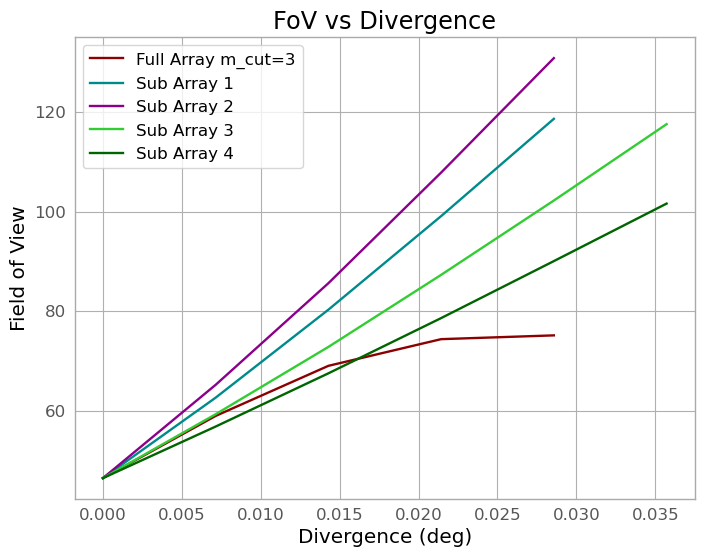

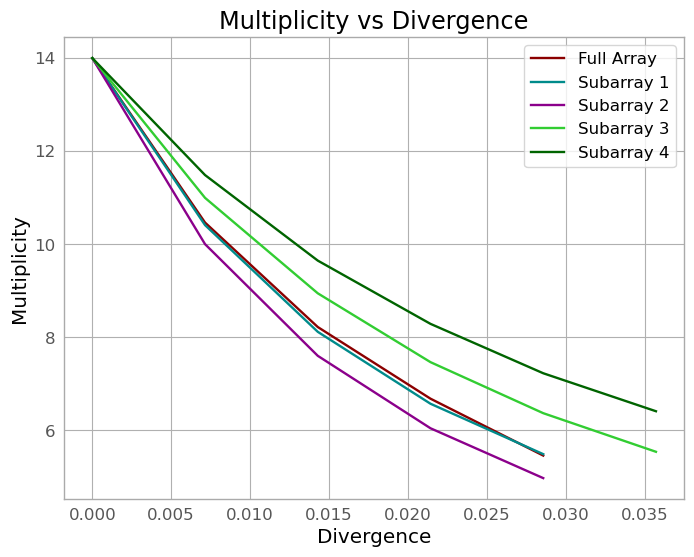

In [94]:
plt.plot(stop_div_sub_1_2_full, FoV_full_array[:array_slice_stop_sub_1_2_full], label='Full Array m_cut=3', color='darkred')
plt.plot(stop_div_sub_1_2_full, FoV_array[:array_slice_stop_sub_1_2_full], label='Sub Array 1', color='darkcyan')
plt.plot(stop_div_sub_1_2_full, FoV_array_2[:array_slice_stop_sub_1_2_full], label='Sub Array 2', color='darkmagenta')
plt.plot(stop_div, FoV_array_3[:array_slice_stop], label='Sub Array 3',color='limegreen')
plt.plot(stop_div, FoV_array_4[:array_slice_stop], label='Sub Array 4', color='darkgreen')
# Add labels and title
plt.xlabel("Divergence (deg)")  
plt.ylabel("Field of View")  
plt.title("FoV vs Divergence")  

# Add legend
plt.legend()

# Display the plot
plt.show()
plt.plot(stop_div_sub_1_2_full, multiplicity_full_array[:array_slice_stop_sub_1_2_full], label='Full Array', color='darkred')
plt.plot(stop_div_sub_1_2_full,  multiplicity_array[:array_slice_stop_sub_1_2_full], label='Subarray 1', color='darkcyan')
plt.plot(stop_div_sub_1_2_full,  multiplicity_array_2[:array_slice_stop_sub_1_2_full], label='Subarray 2', color='darkmagenta')
plt.plot(stop_div,  multiplicity_array_3[:array_slice_stop], label='Subarray 3', color='limegreen')
plt.plot(stop_div,  multiplicity_array_4[:array_slice_stop], label='Subarray 4', color='darkgreen')
plt.xlabel("Divergence")  
plt.ylabel("Multiplicity")  # Y-axis label
plt.title("Multiplicity vs Divergence")  # Title of the plot
plt.legend()
plt.show()

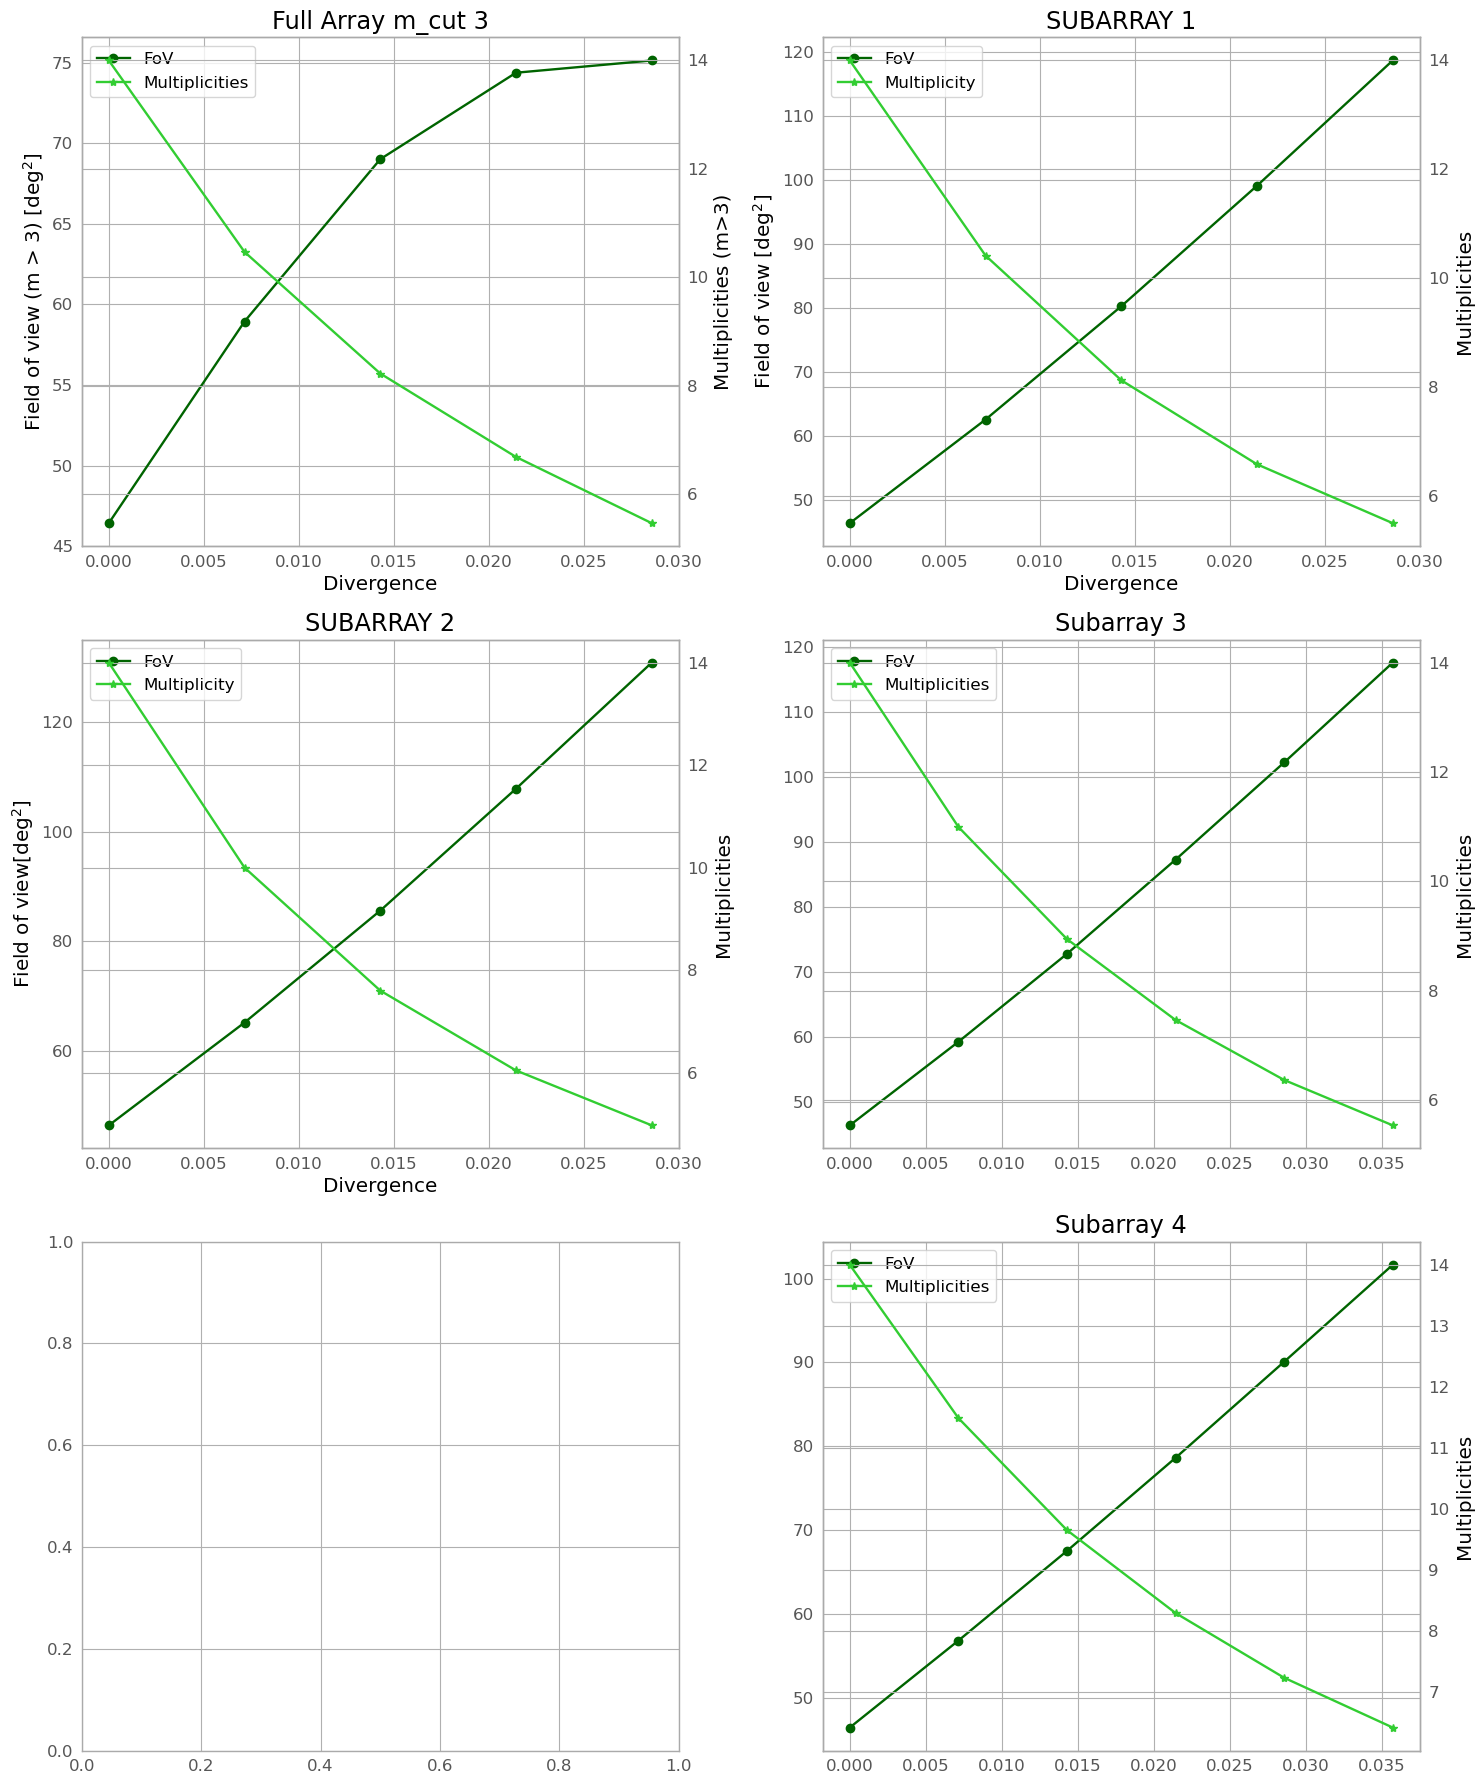

In [95]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18)) 
# Plot Full Array
# Full Array with m_cut = 3
l1=axes[0,0].plot(stop_div_sub_1_2_full, FoV_full_array[:array_slice_stop_sub_1_2_full], label='FoV', marker='o', color='darkgreen')
ax2 = axes[0,0].twinx()
l2=ax2.plot(stop_div_sub_1_2_full, multiplicity_full_array[:array_slice_stop_sub_1_2_full], label='Multiplicities',marker='*', color='limegreen')
axes[0,0].set_title('Full Array m_cut 3')
axes[0,0].set_xlabel('Divergence')
axes[0,0].set_ylabel('Field of view (m > 3) [deg$^2$]')
ax2.set_ylabel('Multiplicities (m>3)')
axeslegend = l1+l2
axes[0,0].legend(axeslegend, [l.get_label() for l in axeslegend])



#Plot the ones for subarray 1
l1=axes[0,1].plot(stop_div_sub_1_2_full, FoV_array[:array_slice_stop_sub_1_2_full], label='FoV',marker='o', color='darkgreen')
ax5=axes[0,1].twinx()
l2=ax5.plot(stop_div_sub_1_2_full, multiplicity_array[:array_slice_stop_sub_1_2_full], label='Multiplicity', marker='*', color='limegreen')
axes[0,1].set_title('SUBARRAY 1')
axes[0,1].set_xlabel('Divergence')
axes[0,1].set_ylabel('Field of view [deg$^2$]')
ax5.set_ylabel('Multiplicities')
axeslegend = l1+l2
axes[0,1].legend(axeslegend, [l.get_label() for l in axeslegend])
#Plot the ones for subarray 2
l1=axes[1,0].plot(stop_div_sub_1_2_full, FoV_array_2[:array_slice_stop_sub_1_2_full], label='FoV',marker='o', color='darkgreen')
ax5=axes[1,0].twinx()
l2=ax5.plot(stop_div_sub_1_2_full, multiplicity_array_2[:array_slice_stop_sub_1_2_full], label='Multiplicity', marker='*', color='limegreen')
axes[1,0].set_title('SUBARRAY 2')
axes[1,0].set_xlabel('Divergence')
axes[1,0].set_ylabel('Field of view[deg$^2$]')
ax5.set_ylabel('Multiplicities')
axeslegend = l1+l2
axes[1,0].legend(axeslegend, [l.get_label() for l in axeslegend])

# Subarray 3
l1=axes[1,1].plot(stop_div, FoV_array_3[:array_slice_stop], label='FoV',marker='o', color='darkgreen')
ax3 = axes[1,1].twinx()
l2=ax3.plot(stop_div,multiplicity_array_3[:array_slice_stop], label='Multiplicities', marker='*', color='limegreen')
plt.title('Subarray 3')
plt.xlabel('Divergence')
plt.ylabel('Field of view  [deg$^2$]')
plt.ylabel('Multiplicities')
axeslegend = l1+l2
axes[1,1].legend(axeslegend, [l.get_label() for l in axeslegend])
# Adjust layout
plt.tight_layout()
# Subarray 4
l1=axes[2,1].plot(stop_div, FoV_array_4[:array_slice_stop], label='FoV',marker='o', color='darkgreen')
ax3 = axes[2,1].twinx()
l2=ax3.plot(stop_div,multiplicity_array_4[:array_slice_stop], label='Multiplicities', marker='*', color='limegreen')
plt.title('Subarray 4')
plt.xlabel('Divergence')
plt.ylabel('Field of view  [deg$^2$]')
plt.ylabel('Multiplicities')
axeslegend = l1+l2
axes[2,1].legend(axeslegend, [l.get_label() for l in axeslegend])
# Adjust layout
plt.tight_layout()


plt.show()

# How it changes with height

In [96]:
#If you do not do this like this but just put array_alt_1=array and array_alt_2=array you will end up with a problem
#You will end up having them over write each pther because they come from the same point
array_alt_1= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_alt_1_div_2= LoadConfig("./subarray_1_SOUTH.txt", frame=cta, pointing2src=True)
#array_alt_1_div_3= LoadConfig("./subarray_1_SOUTH.txt", frame=cta, pointing2src=True)
array_alt_2= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_alt_2_div_2= LoadConfig("./subarray_1_SOUTH.txt", frame=cta, pointing2src=True)
#array_alt_2_div_3= LoadConfig("./subarray_1_SOUTH.txt", frame=cta, pointing2src=True)

array_alt_3= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_alt_3_div_2= LoadConfig("./subarray_1_SOUTH.txt", frame=cta, pointing2src=True)
#array_alt_3_div_3= LoadConfig("./subarray_1_SOUTH.txt", frame=cta, pointing2src=True)

array_2_alt_1= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_2_alt_1_div_2= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_2_alt_1_div_3= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)

array_2_alt_2= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_2_alt_2_div_2= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_2_alt_2_div_3= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
array_2_alt_3= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_2_alt_3_div_2= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
#array_2_alt_3_div_3= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
array_3_alt_1= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, poinitng2src=True)
array_3_alt_2= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, poinitng2src=True)
array_3_alt_3= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, poinitng2src=True)

array_4_alt_1=LoadConfig("./subarray_4_SOUTH.txt", frame=cta, pointing2src=True)
array_4_alt_2=LoadConfig("./subarray_4_SOUTH.txt", frame=cta, pointing2src=True)
array_4_alt_3=LoadConfig("./subarray_4_SOUTH.txt", frame=cta, pointing2src=True)

In [97]:
altitude_array=[70,50,30]
az=0

4it [00:00,  6.75it/s]


The FoV and the average multiplicity is for array_1 with divergence0.00 and altitude70.00 : (46.42342975074266, 14.0)


4it [00:00,  7.19it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.12it/s]
4it [00:00,  7.05it/s]


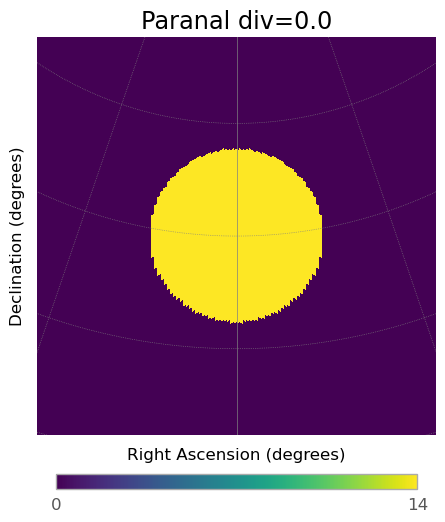

4it [00:00,  7.38it/s]


The FoV and the average multiplicity is for array_1 with divergence0.00 and altitude50.00 : (46.55456938280691, 14.0)


4it [00:00,  7.23it/s]
4it [00:00,  7.14it/s]
4it [00:00,  7.18it/s]
4it [00:00,  6.63it/s]


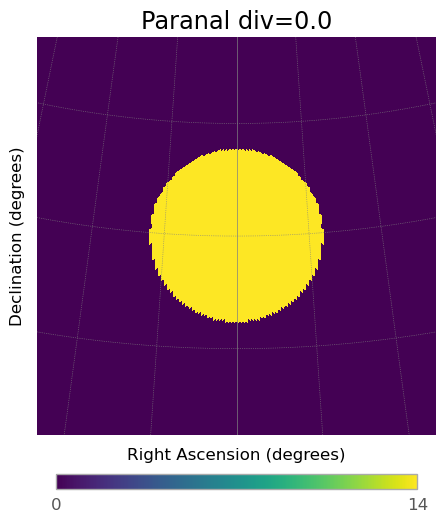

4it [00:00,  6.94it/s]


The FoV and the average multiplicity is for array_1 with divergence0.00 and altitude30.00 : (46.56768334601333, 14.0)


4it [00:00,  7.05it/s]
4it [00:00,  7.36it/s]
4it [00:00,  7.38it/s]
4it [00:00,  6.95it/s]


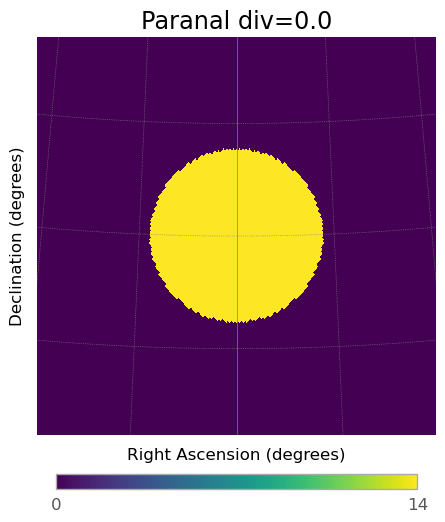

4it [00:00,  7.37it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude70.00 : (62.606060347470475, 10.412232928361961)


4it [00:00,  5.50it/s]
4it [00:00,  7.02it/s]
4it [00:00,  6.56it/s]
4it [00:00,  6.50it/s]


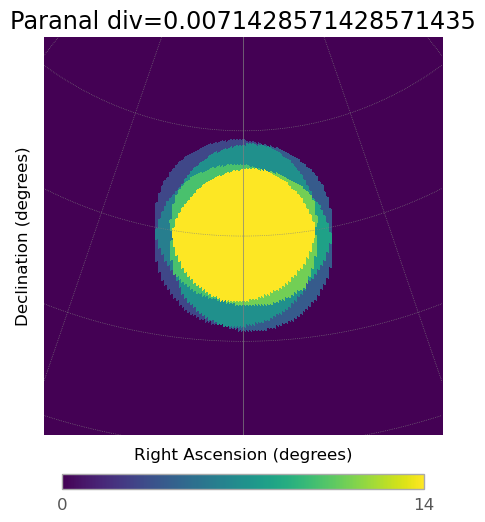

4it [00:00,  6.72it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude50.00 : (60.6389658665068, 10.744377162629759)


4it [00:00,  7.01it/s]
4it [00:00,  7.18it/s]
4it [00:00,  7.51it/s]
4it [00:00,  6.65it/s]


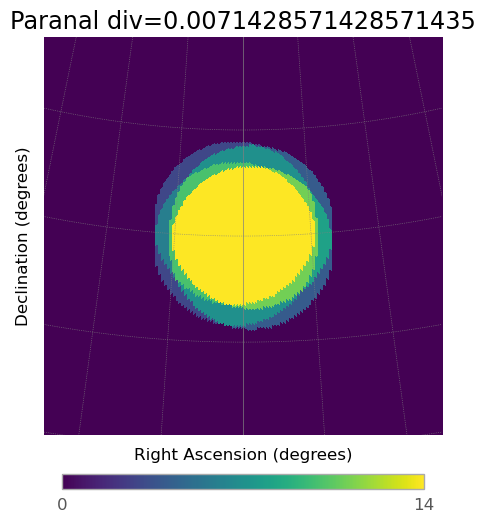

4it [00:00,  7.14it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude30.00 : (57.97683133560263, 11.247002940511196)


4it [00:00,  7.43it/s]
4it [00:00,  7.44it/s]
4it [00:00,  7.37it/s]
4it [00:00,  6.79it/s]


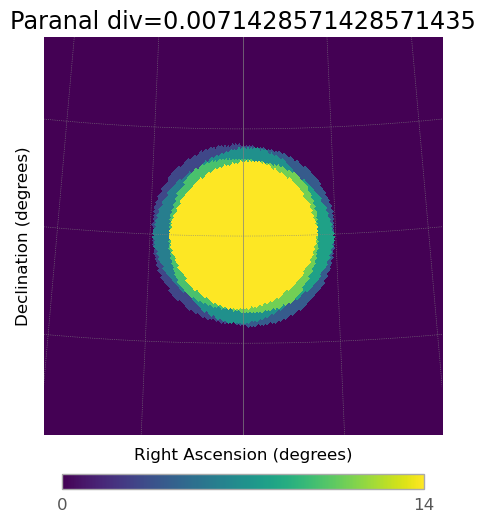

4it [00:00,  7.54it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude70.00 : (80.2967967129371, 8.119385921933693)


4it [00:00,  7.03it/s]
4it [00:00,  7.21it/s]
4it [00:00,  7.20it/s]
4it [00:00,  7.04it/s]


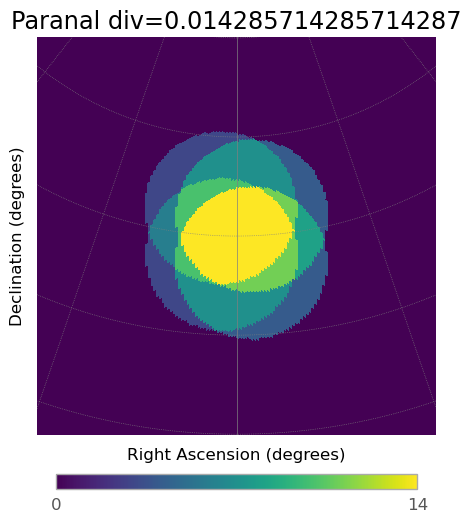

4it [00:00,  7.33it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude50.00 : (76.2839239717712, 8.543922984356197)


4it [00:00,  7.00it/s]
4it [00:00,  7.32it/s]
4it [00:00,  7.30it/s]
4it [00:00,  7.03it/s]


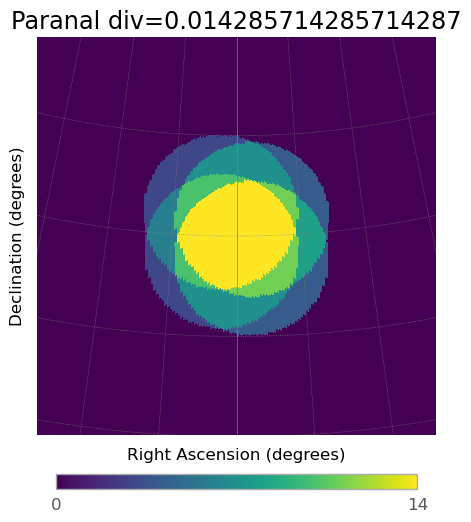

4it [00:00,  7.49it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude30.00 : (70.36952656567377, 9.270219903093553)


4it [00:00,  7.38it/s]
4it [00:00,  7.35it/s]
4it [00:00,  7.24it/s]
4it [00:00,  7.11it/s]


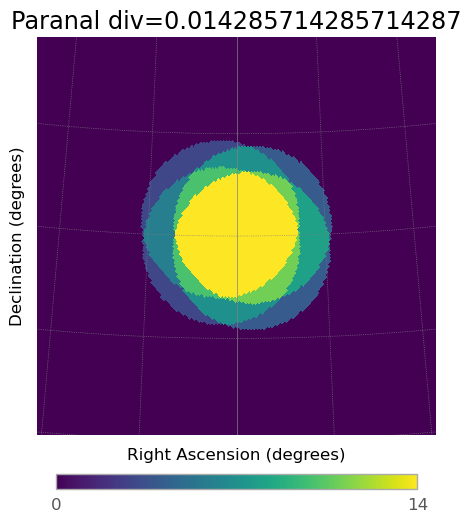

4it [00:00,  7.44it/s]


The FoV and the average multiplicity is for array_1 with divergence0.02 and altitude70.00 : (99.11533391415622, 6.574093675575549)


4it [00:00,  7.13it/s]
4it [00:00,  7.01it/s]
4it [00:00,  7.45it/s]
4it [00:00,  6.69it/s]


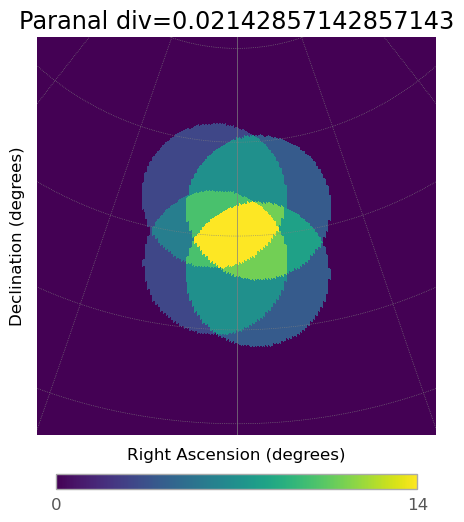

4it [00:00,  6.98it/s]


The FoV and the average multiplicity is for array_1 with divergence0.02 and altitude50.00 : (93.01734102316884, 7.002678697307204)


4it [00:00,  7.27it/s]
4it [00:00,  7.47it/s]
4it [00:00,  7.46it/s]
4it [00:00,  6.71it/s]


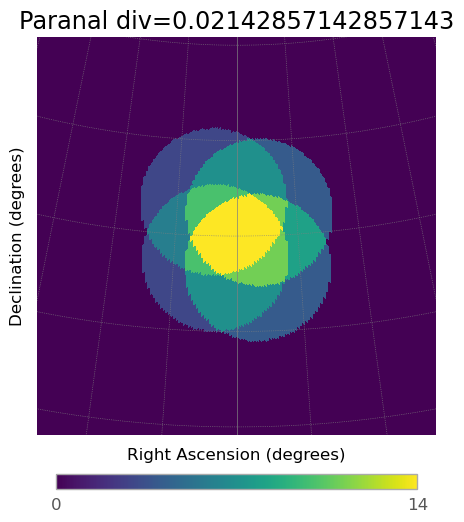

4it [00:00,  7.16it/s]


The FoV and the average multiplicity is for array_1 with divergence0.02 and altitude30.00 : (83.32612221362115, 7.816650928548945)


4it [00:00,  7.25it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.19it/s]
4it [00:00,  6.76it/s]


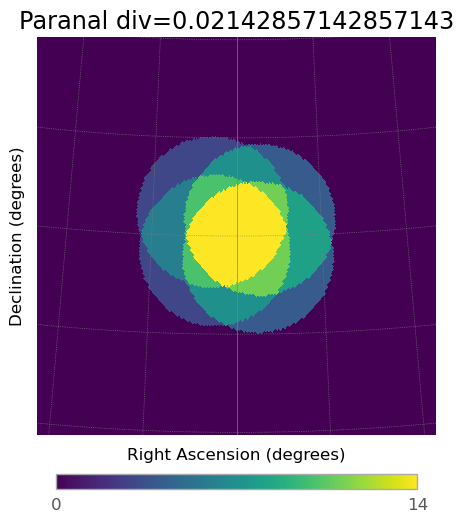

4it [00:00,  7.11it/s]


The FoV and the average multiplicity is for array_1 with divergence0.03 and altitude70.00 : (118.68136701814156, 5.491381215469613)


4it [00:00,  7.15it/s]
4it [00:00,  7.23it/s]
4it [00:00,  7.22it/s]
4it [00:00,  6.93it/s]


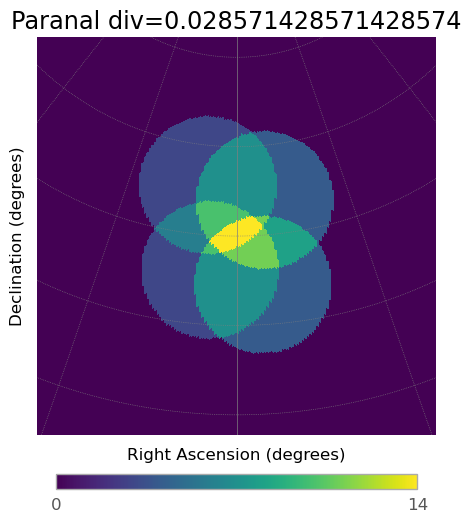

4it [00:00,  7.40it/s]


The FoV and the average multiplicity is for array_1 with divergence0.03 and altitude50.00 : (110.62939360939693, 5.89307728781413)


4it [00:00,  7.37it/s]
4it [00:00,  7.20it/s]
4it [00:00,  7.20it/s]
4it [00:00,  6.90it/s]


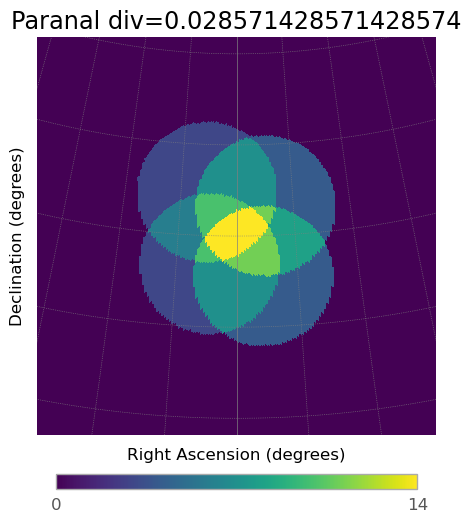

4it [00:00,  7.37it/s]


The FoV and the average multiplicity is for array_1 with divergence0.03 and altitude30.00 : (97.2793790652568, 6.698301428956592)


4it [00:00,  7.19it/s]
4it [00:00,  7.32it/s]
4it [00:00,  7.41it/s]
4it [00:00,  6.96it/s]


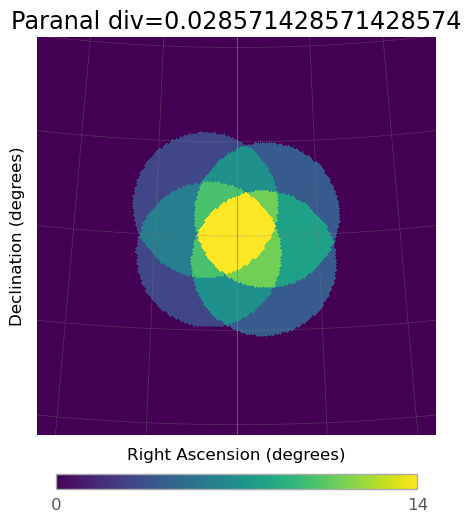

In [99]:
hFoV_altitude_1_configuration_1=[]
hFoV_altitude_2_configuration_1=[]
hFoV_altitude_3_configuration_1=[]
multiplicity_altitude_1_configuration_1=[]
multiplicity_altitude_2_configuration_1=[]
multiplicity_altitude_3_configuration_1=[]
for divergence in stop_div_sub_1_2_full:
    for alt in altitude_array:
        array.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_1 with divergence{divergence:.2f} and altitude{alt:.2f} :",array.hFoV(subarray_mult=number_of_telescopes_subarray_1))
        if alt==altitude_array[0]:
            hFoV_altitude_1_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0])
            multiplicity_altitude_1_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1])
        if alt==altitude_array[1]:
            hFoV_altitude_2_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0])
            multiplicity_altitude_2_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1])
        if alt==altitude_array[2]:
            hFoV_altitude_3_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0])
            multiplicity_altitude_3_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1])
        array.multiplicity_plot(number_of_telescopes_subarray_1)
        

4it [00:00,  6.73it/s]


The FoV and the average multiplicity is for array_1 with divergence0.00 and altitude90.00 : (47.367635101605224, 14.0)


4it [00:00,  7.34it/s]
4it [00:00,  7.47it/s]
4it [00:00,  7.70it/s]
4it [00:00,  6.88it/s]


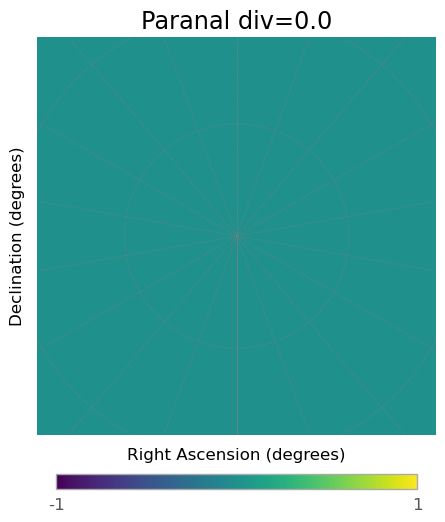

4it [00:00,  7.35it/s]


The FoV and the average multiplicity is for array_1 with divergence0.00 and altitude70.00 : (46.42342975074266, 14.0)


4it [00:00,  7.14it/s]
4it [00:00,  7.44it/s]
4it [00:00,  7.59it/s]
4it [00:00,  6.95it/s]


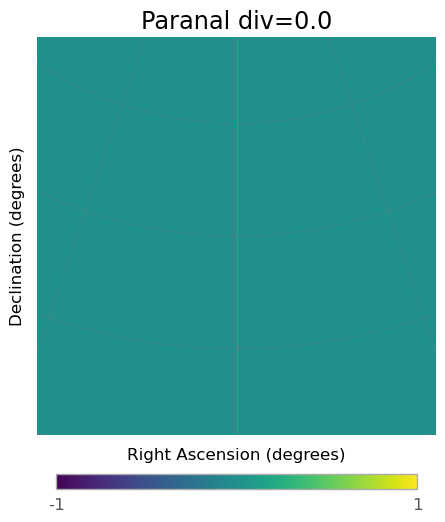

4it [00:00,  7.46it/s]


The FoV and the average multiplicity is for array_1 with divergence0.00 and altitude50.00 : (46.55456938280691, 14.0)


4it [00:00,  7.32it/s]
4it [00:00,  7.23it/s]
4it [00:00,  7.03it/s]
4it [00:00,  6.59it/s]


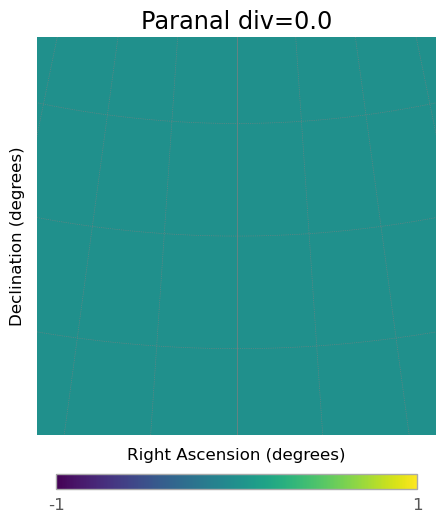

4it [00:00,  7.36it/s]


The FoV and the average multiplicity is for array_1 with divergence0.00 and altitude30.00 : (46.56768334601333, 14.0)


4it [00:00,  7.38it/s]
4it [00:00,  7.19it/s]


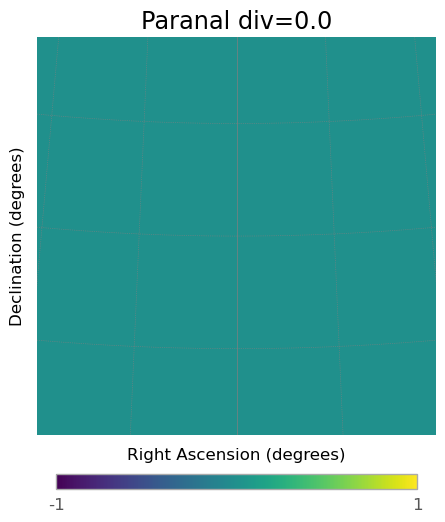

4it [00:00,  6.96it/s]


The FoV and the average multiplicity is for array_1 with divergence0.00 and altitude0.00 : (46.580797309219754, 14.0)


4it [00:00,  7.08it/s]
4it [00:00,  6.56it/s]


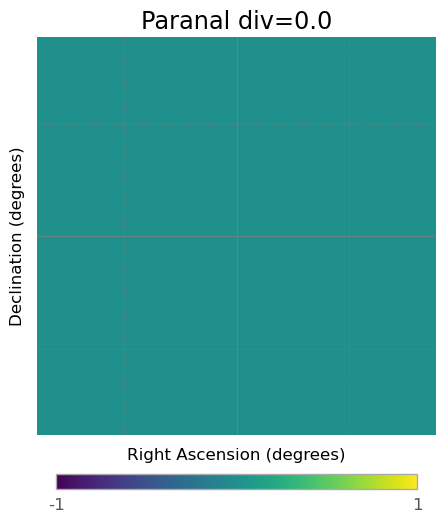

4it [00:00,  7.09it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude90.00 : (63.30110039741097, 10.307644499689248)


4it [00:00,  7.42it/s]
4it [00:00,  7.64it/s]
4it [00:00,  7.74it/s]
4it [00:00,  7.08it/s]


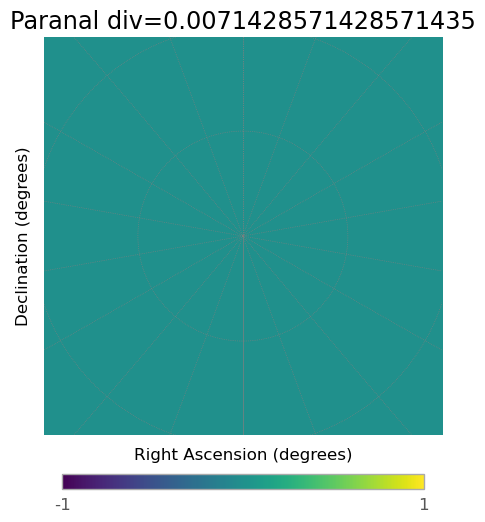

4it [00:00,  7.08it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude70.00 : (62.606060347470475, 10.412232928361961)


4it [00:00,  7.23it/s]
4it [00:00,  7.03it/s]
4it [00:00,  7.08it/s]
4it [00:00,  6.45it/s]


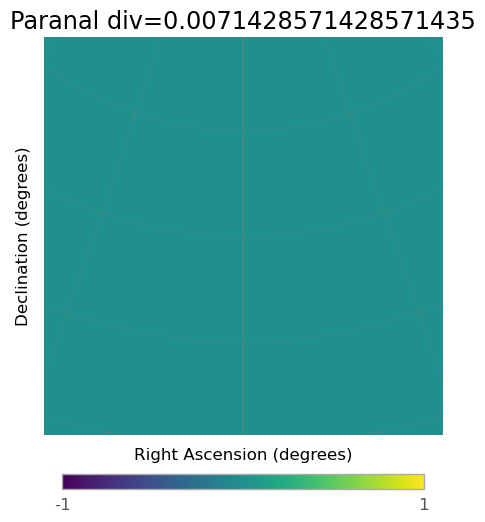

4it [00:00,  7.29it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude50.00 : (60.6389658665068, 10.744377162629759)


4it [00:00,  7.14it/s]
4it [00:00,  6.86it/s]
4it [00:00,  7.13it/s]
4it [00:00,  6.44it/s]


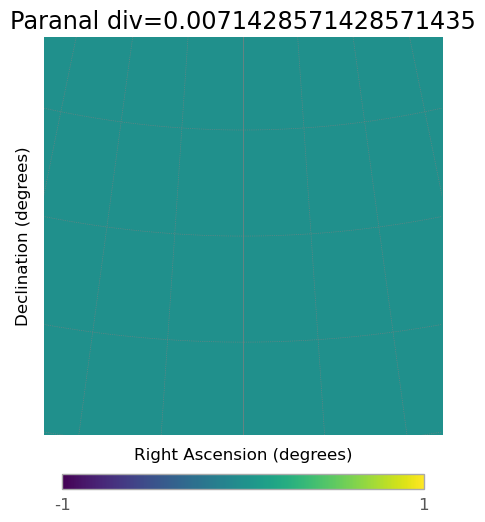

4it [00:00,  7.07it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude30.00 : (57.97683133560263, 11.247002940511196)


4it [00:00,  7.32it/s]
4it [00:00,  6.54it/s]


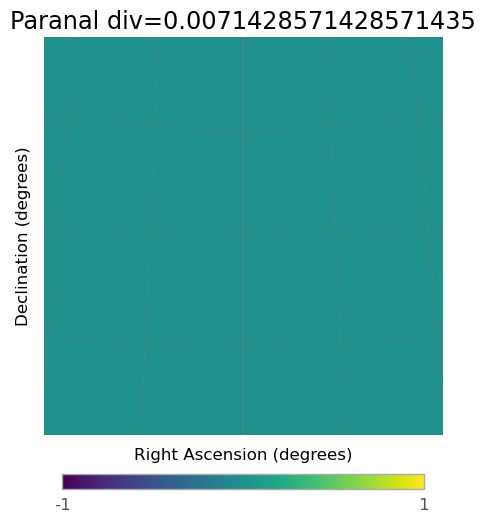

4it [00:00,  6.77it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude0.00 : (52.71813208982641, 12.378358208955223)


4it [00:00,  7.19it/s]
4it [00:00,  7.10it/s]


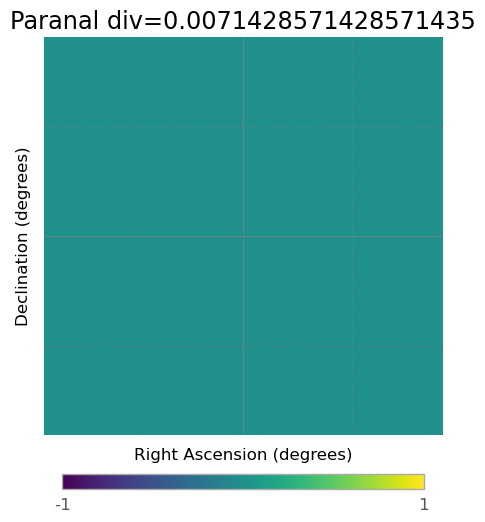

4it [00:00,  7.62it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude90.00 : (81.51639529113457, 8.000804375804377)


4it [00:00,  7.41it/s]
4it [00:00,  7.58it/s]
4it [00:00,  7.67it/s]
4it [00:00,  7.10it/s]


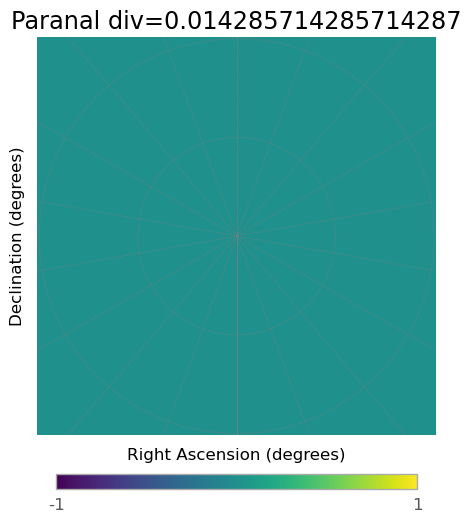

4it [00:00,  7.53it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude70.00 : (80.2967967129371, 8.119385921933693)


4it [00:00,  7.49it/s]
4it [00:00,  7.28it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.10it/s]


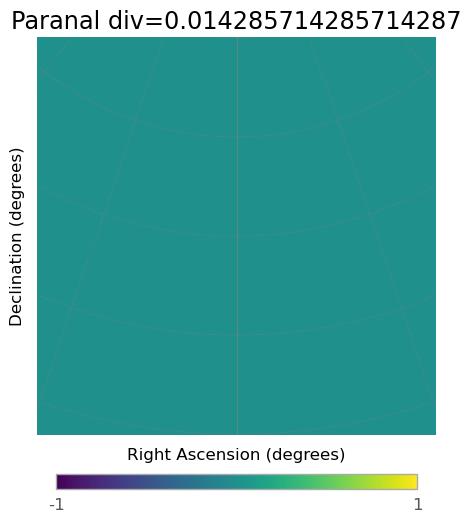

4it [00:00,  6.98it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude50.00 : (76.2839239717712, 8.543922984356197)


4it [00:00,  7.39it/s]
4it [00:00,  7.47it/s]
4it [00:00,  7.41it/s]
4it [00:00,  6.71it/s]


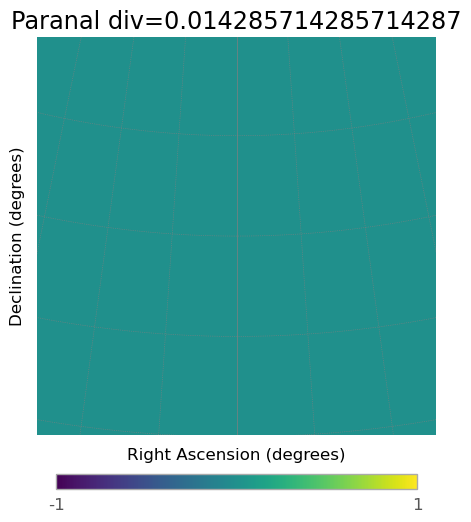

4it [00:00,  7.43it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude30.00 : (70.36952656567377, 9.270219903093553)


4it [00:00,  7.51it/s]
4it [00:00,  6.87it/s]


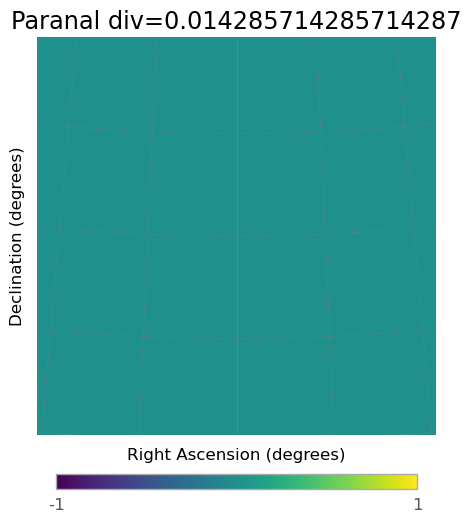

4it [00:00,  7.42it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude0.00 : (58.8685808336395, 11.07083983069726)


4it [00:00,  7.59it/s]
4it [00:00,  6.97it/s]


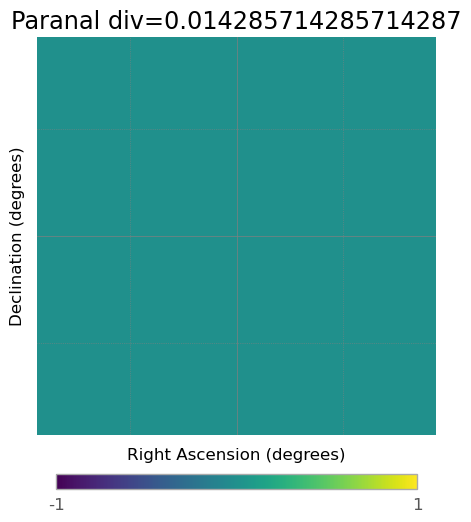

4it [00:00,  7.39it/s]


The FoV and the average multiplicity is for array_1 with divergence0.02 and altitude90.00 : (100.9775166894685, 6.454935064935065)


4it [00:00,  7.22it/s]
4it [00:00,  7.33it/s]
4it [00:00,  7.51it/s]
4it [00:00,  6.97it/s]


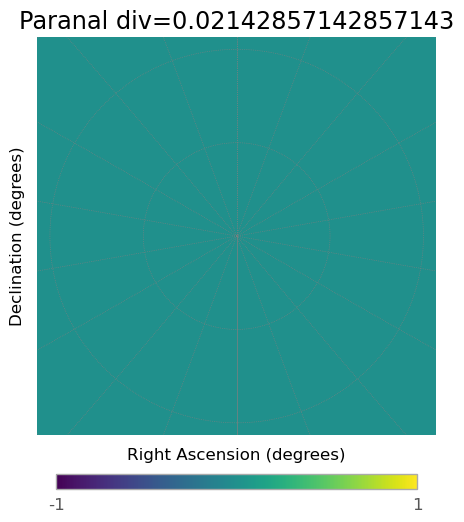

4it [00:00,  7.47it/s]


The FoV and the average multiplicity is for array_1 with divergence0.02 and altitude70.00 : (99.11533391415622, 6.574093675575549)


4it [00:00,  7.39it/s]
4it [00:00,  7.48it/s]
4it [00:00,  7.62it/s]
4it [00:00,  7.11it/s]


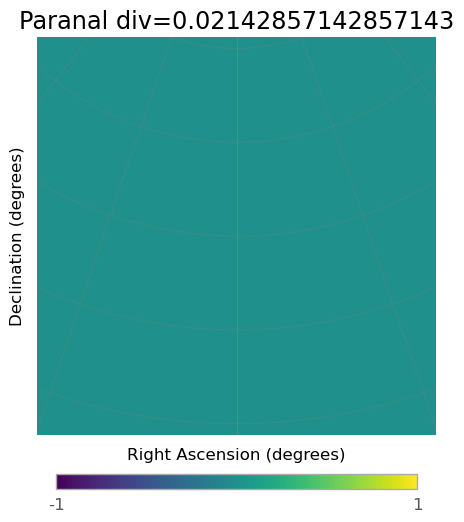

4it [00:00,  7.51it/s]


The FoV and the average multiplicity is for array_1 with divergence0.02 and altitude50.00 : (93.01734102316884, 7.002678697307204)


4it [00:00,  7.53it/s]
4it [00:00,  7.26it/s]
4it [00:00,  7.74it/s]
4it [00:00,  7.03it/s]


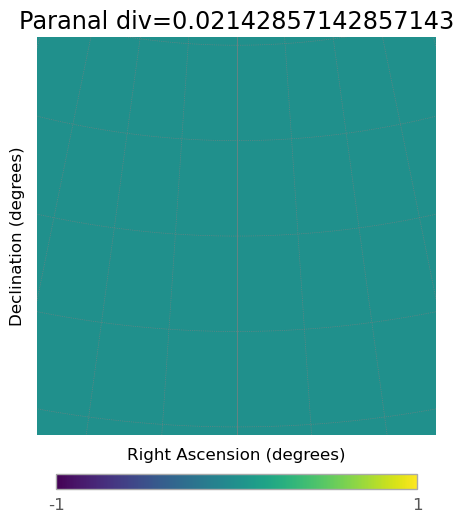

4it [00:00,  7.07it/s]


The FoV and the average multiplicity is for array_1 with divergence0.02 and altitude30.00 : (83.32612221362115, 7.816650928548945)


4it [00:00,  7.31it/s]
4it [00:00,  7.03it/s]


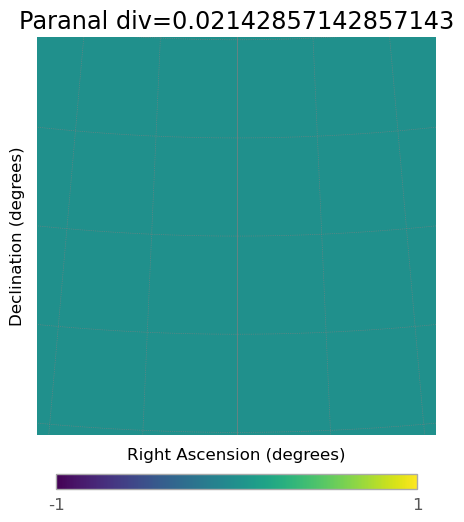

4it [00:00,  7.03it/s]


The FoV and the average multiplicity is for array_1 with divergence0.02 and altitude0.00 : (65.17639713592968, 9.99979879275654)


4it [00:00,  7.56it/s]
4it [00:00,  5.88it/s]


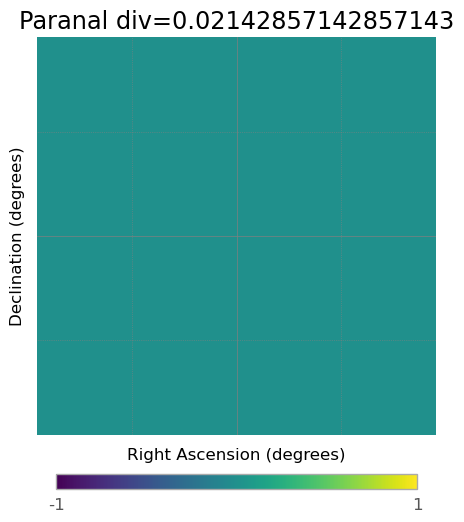

4it [00:00,  7.56it/s]


The FoV and the average multiplicity is for array_1 with divergence0.03 and altitude90.00 : (121.19924795377506, 5.375676260549665)


4it [00:00,  7.17it/s]
4it [00:00,  7.10it/s]
4it [00:00,  6.97it/s]
4it [00:00,  6.75it/s]


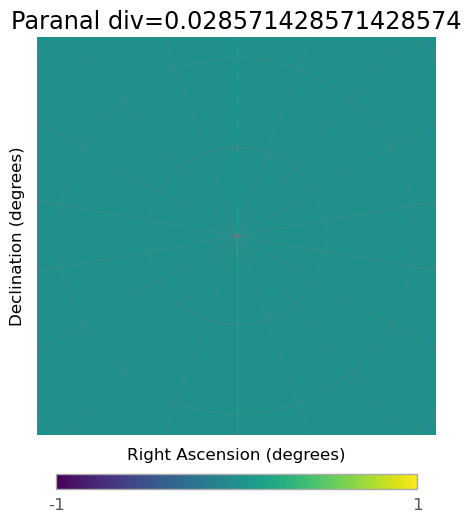

4it [00:00,  7.27it/s]


The FoV and the average multiplicity is for array_1 with divergence0.03 and altitude70.00 : (118.68136701814156, 5.491381215469613)


4it [00:00,  7.46it/s]
4it [00:00,  7.16it/s]
4it [00:00,  7.27it/s]
4it [00:00,  6.89it/s]


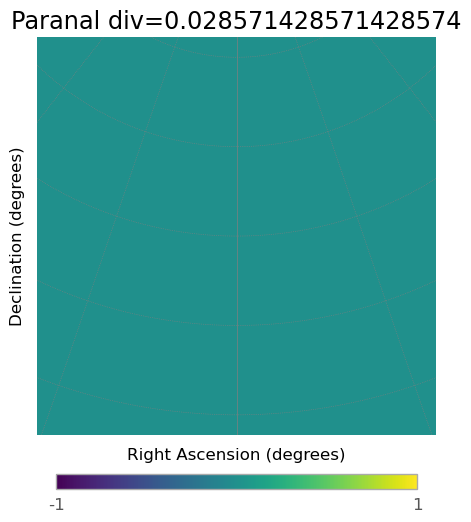

4it [00:00,  7.27it/s]


The FoV and the average multiplicity is for array_1 with divergence0.03 and altitude50.00 : (110.62939360939693, 5.89307728781413)


4it [00:00,  7.33it/s]
4it [00:00,  7.50it/s]
4it [00:00,  7.48it/s]
4it [00:00,  7.04it/s]


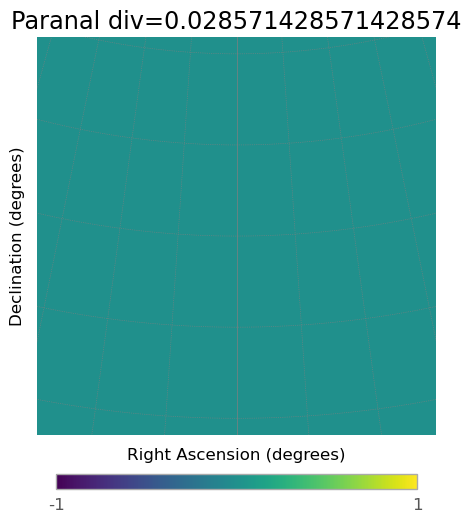

4it [00:00,  7.11it/s]


The FoV and the average multiplicity is for array_1 with divergence0.03 and altitude30.00 : (97.2793790652568, 6.698301428956592)


4it [00:00,  7.59it/s]
4it [00:00,  6.83it/s]


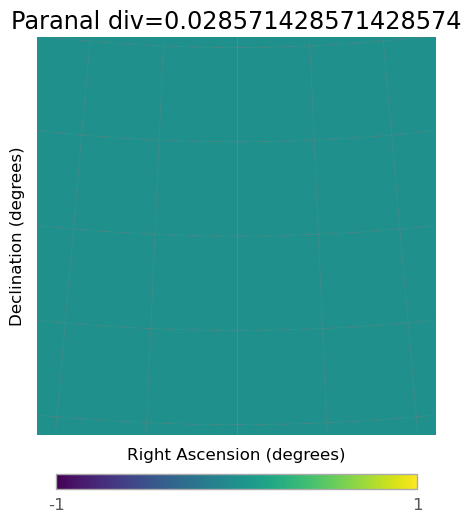

4it [00:00,  7.32it/s]


The FoV and the average multiplicity is for array_1 with divergence0.03 and altitude0.00 : (71.41864362218773, 9.129820051413882)


4it [00:00,  7.58it/s]
4it [00:00,  7.07it/s]


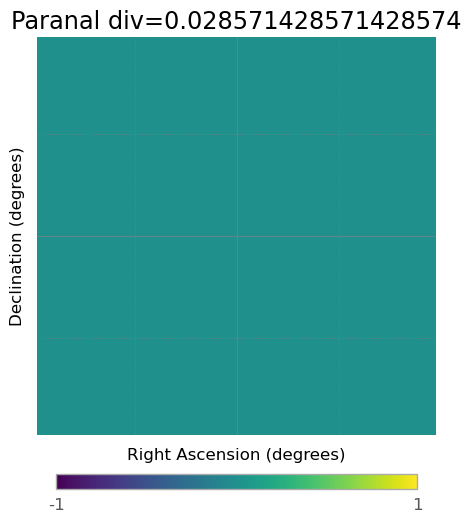

In [177]:
hFoV_altitude_1_configuration_1=[]
hFoV_altitude_2_configuration_1=[]
hFoV_altitude_3_configuration_1=[]
multiplicity_altitude_1_configuration_1=[]
multiplicity_altitude_2_configuration_1=[]
multiplicity_altitude_3_configuration_1=[]
for divergence in stop_div_sub_1_2_full:
    for alt in altitude_array:
        array.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_1 with divergence{divergence:.2f} and altitude{alt:.2f} :",array.hFoV(subarray_mult=number_of_telescopes_subarray_1))
        if alt==altitude_array[0]:
            hFoV_altitude_1_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0])
            multiplicity_altitude_1_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1])
        if alt==altitude_array[1]:
            hFoV_altitude_2_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0])
            multiplicity_altitude_2_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1])
        if alt==altitude_array[2]:
            hFoV_altitude_3_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0])
            multiplicity_altitude_3_configuration_1.append(array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1])
        #array.multiplicity_plot(number_of_telescopes_subarray_1)
        multiplicity_plot(array, number_of_telescopes_subarray_1)
        

4it [00:00,  7.05it/s]


The FoV and the average multiplicity is for array_2 with divergence0.00 and altitude70.00 : (46.42342975074266, 14.0)


4it [00:00,  7.38it/s]
4it [00:00,  7.12it/s]
4it [00:00,  7.03it/s]
4it [00:00,  6.24it/s]


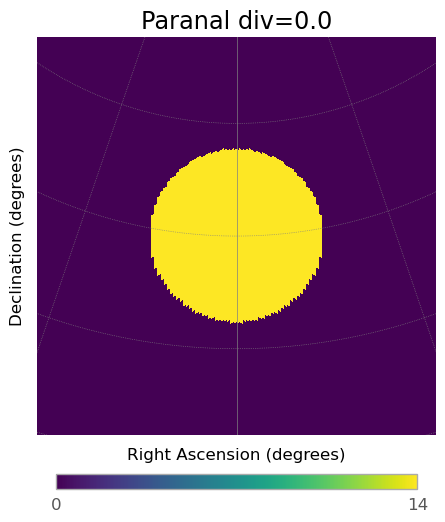

4it [00:00,  6.35it/s]


The FoV and the average multiplicity is for array_2 with divergence0.00 and altitude50.00 : (46.55456938280691, 14.0)


4it [00:00,  6.88it/s]
4it [00:00,  7.05it/s]
4it [00:00,  7.30it/s]
4it [00:00,  6.56it/s]


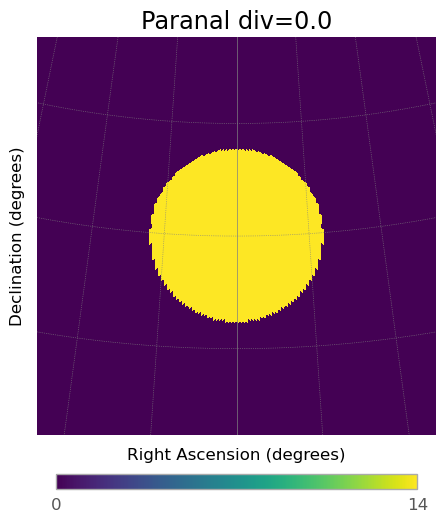

4it [00:00,  6.80it/s]


The FoV and the average multiplicity is for array_2 with divergence0.00 and altitude30.00 : (46.56768334601333, 14.0)


4it [00:00,  7.01it/s]
4it [00:00,  6.99it/s]
4it [00:00,  7.08it/s]
4it [00:00,  6.71it/s]


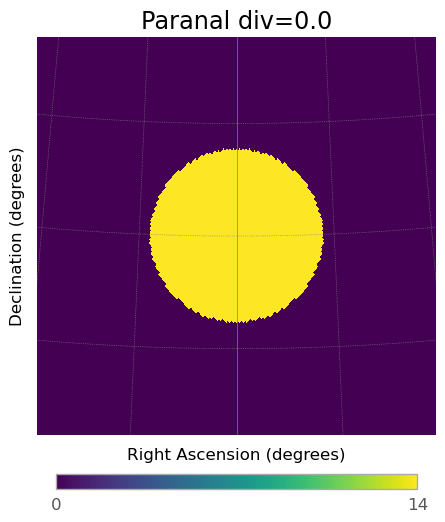

4it [00:00,  7.38it/s]


The FoV and the average multiplicity is for array_2 with divergence0.01 and altitude70.00 : (65.1895110991361, 10.002816334741501)


4it [00:00,  6.85it/s]
4it [00:00,  6.92it/s]
4it [00:00,  6.83it/s]
4it [00:00,  6.48it/s]


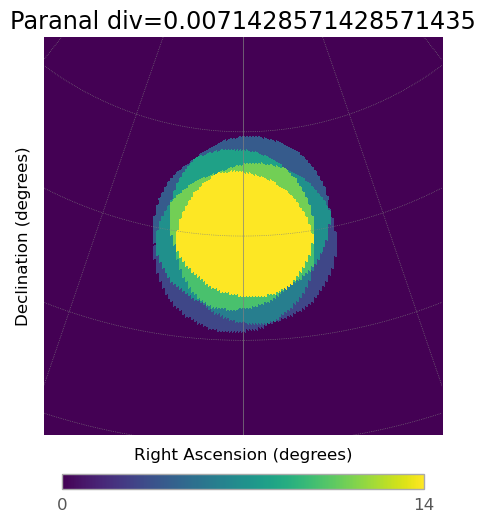

4it [00:00,  6.97it/s]


The FoV and the average multiplicity is for array_2 with divergence0.01 and altitude50.00 : (63.065049059695326, 10.339155749636099)


4it [00:00,  6.94it/s]
4it [00:00,  7.28it/s]
4it [00:00,  7.46it/s]
4it [00:00,  6.81it/s]


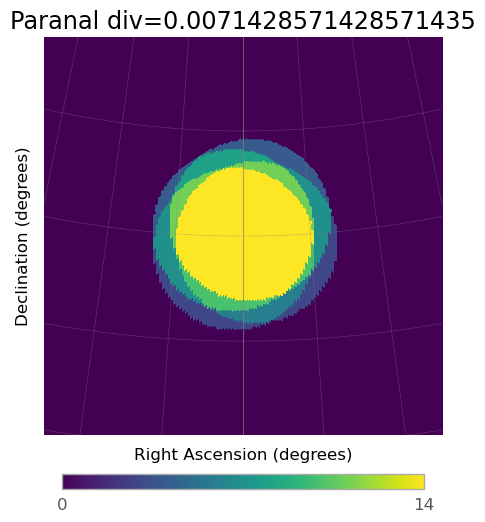

4it [00:00,  7.02it/s]


The FoV and the average multiplicity is for array_2 with divergence0.01 and altitude30.00 : (59.9439258165663, 10.877488514548238)


4it [00:00,  7.07it/s]
4it [00:00,  6.94it/s]
4it [00:00,  7.11it/s]
4it [00:00,  6.60it/s]


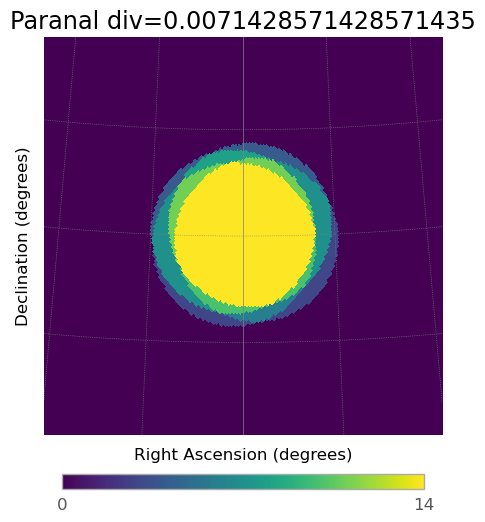

4it [00:00,  6.79it/s]


The FoV and the average multiplicity is for array_2 with divergence0.01 and altitude70.00 : (85.62106577474543, 7.603920967988972)


4it [00:00,  6.83it/s]
4it [00:00,  6.81it/s]
4it [00:00,  7.26it/s]
4it [00:00,  6.57it/s]


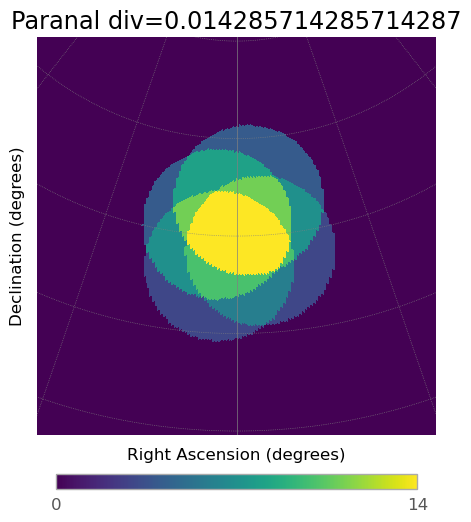

4it [00:00,  7.20it/s]


The FoV and the average multiplicity is for array_2 with divergence0.01 and altitude50.00 : (81.25411602700608, 8.020174306003874)


4it [00:00,  7.26it/s]
4it [00:00,  7.38it/s]
4it [00:00,  7.26it/s]
4it [00:00,  6.83it/s]


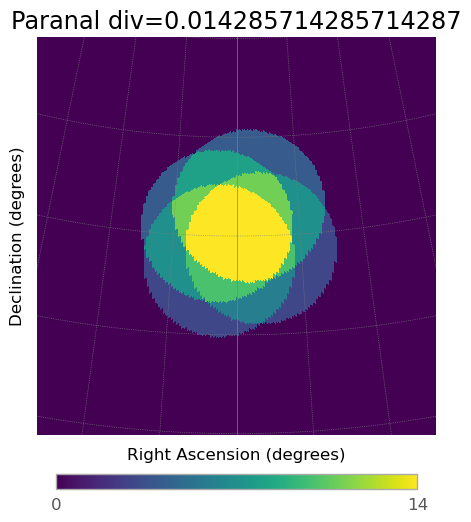

4it [00:00,  7.38it/s]


The FoV and the average multiplicity is for array_2 with divergence0.01 and altitude30.00 : (74.30371552760111, 8.765442993293329)


4it [00:00,  7.54it/s]
4it [00:00,  7.43it/s]
4it [00:00,  6.94it/s]
4it [00:00,  6.89it/s]


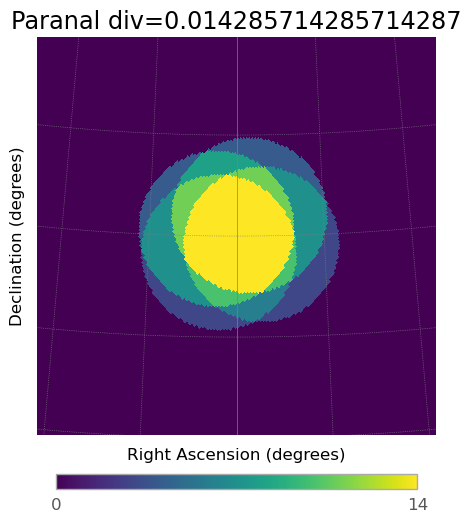

4it [00:00,  7.50it/s]


The FoV and the average multiplicity is for array_2 with divergence0.02 and altitude70.00 : (107.87546133604778, 6.047289083394117)


4it [00:00,  7.41it/s]
4it [00:00,  7.33it/s]
4it [00:00,  7.33it/s]
4it [00:00,  6.60it/s]


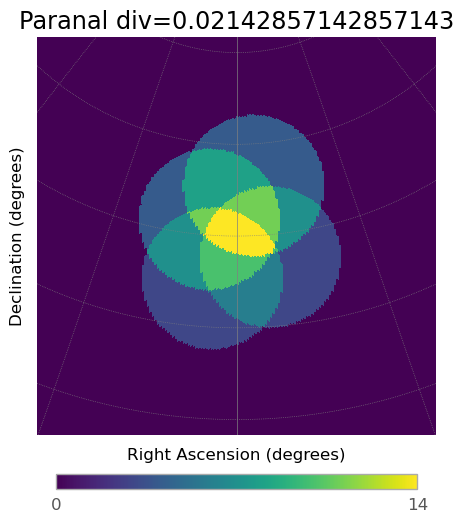

4it [00:00,  7.37it/s]


The FoV and the average multiplicity is for array_2 with divergence0.02 and altitude50.00 : (100.63655364610146, 6.475762314308053)


4it [00:00,  7.21it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.24it/s]
4it [00:00,  6.62it/s]


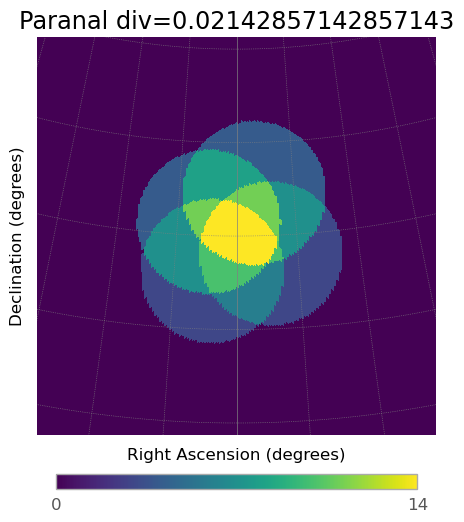

4it [00:00,  6.97it/s]


The FoV and the average multiplicity is for array_2 with divergence0.02 and altitude30.00 : (89.68639436873703, 7.2703611639128525)


4it [00:00,  7.17it/s]
4it [00:00,  7.00it/s]
4it [00:00,  6.74it/s]
4it [00:00,  6.67it/s]


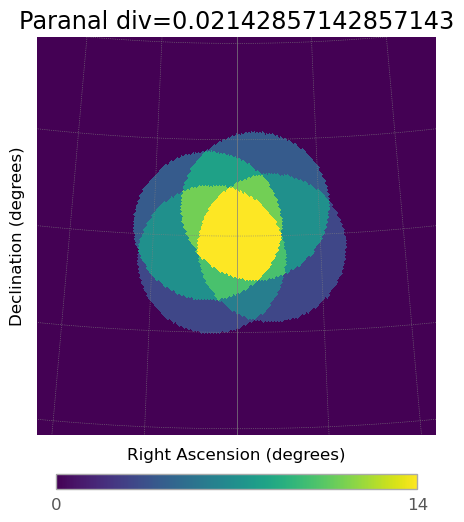

4it [00:00,  6.75it/s]


The FoV and the average multiplicity is for array_2 with divergence0.03 and altitude70.00 : (130.89046676332273, 4.976455265003507)


4it [00:00,  7.33it/s]
4it [00:00,  6.88it/s]
4it [00:00,  6.70it/s]
4it [00:00,  6.23it/s]


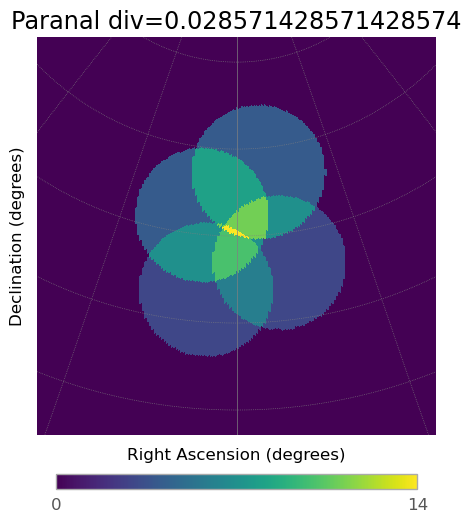

4it [00:00,  7.00it/s]


The FoV and the average multiplicity is for array_2 with divergence0.03 and altitude50.00 : (121.30415965942645, 5.368972972972973)


4it [00:00,  7.08it/s]
4it [00:00,  7.42it/s]
4it [00:00,  7.32it/s]
4it [00:00,  6.97it/s]


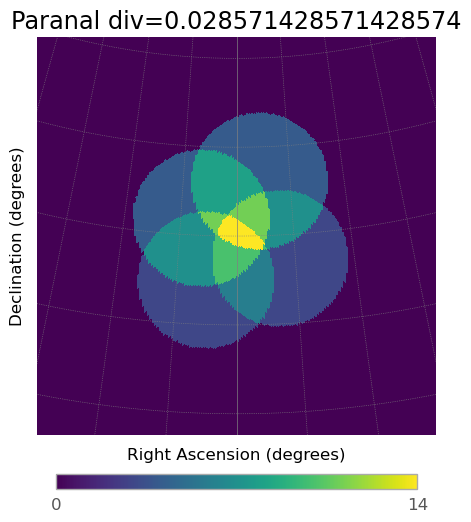

4it [00:00,  7.19it/s]


The FoV and the average multiplicity is for array_2 with divergence0.03 and altitude30.00 : (105.89525289187769, 6.153808049535604)


4it [00:00,  7.49it/s]
4it [00:00,  7.28it/s]
4it [00:00,  6.77it/s]
4it [00:00,  6.48it/s]


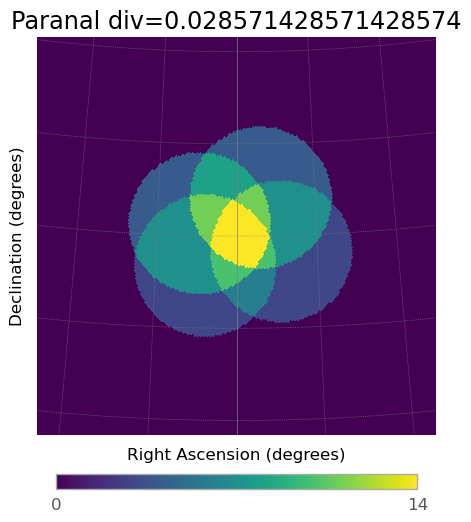

In [149]:
hFoV_altitude_1_configuration_2=[]
hFoV_altitude_2_configuration_2=[]
hFoV_altitude_3_configuration_2=[]
multiplicity_altitude_1_configuration_2=[]
multiplicity_altitude_2_configuration_2=[]
multiplicity_altitude_3_configuration_2=[]
for divergence in stop_div_sub_1_2_full:
    for alt in altitude_array:
        array_2.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_2 with divergence{divergence:.2f} and altitude{alt:.2f} :",array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2))
        if alt==altitude_array[0]:
            hFoV_altitude_1_configuration_2.append(array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[0])
            multiplicity_altitude_1_configuration_2.append(array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[1])
        if alt==altitude_array[1]:
            hFoV_altitude_2_configuration_2.append(array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[0])
            multiplicity_altitude_2_configuration_2.append(array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[1])
        if alt==altitude_array[2]:
            hFoV_altitude_3_configuration_2.append(array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[0])
            multiplicity_altitude_3_configuration_2.append(array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[1])
        array_2.multiplicity_plot(number_of_telescopes_subarray_2)
        

4it [00:00,  7.33it/s]


The FoV and the average multiplicity is for array_3 with divergence0.00 and altitude70.00 : (46.42342975074266, 14.0)


4it [00:00,  7.46it/s]
4it [00:00,  7.26it/s]
4it [00:00,  7.38it/s]
4it [00:00,  6.86it/s]


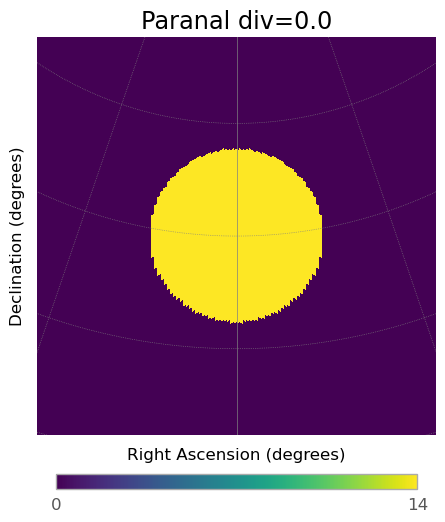

4it [00:00,  7.17it/s]


The FoV and the average multiplicity is for array_3 with divergence0.00 and altitude50.00 : (46.55456938280691, 14.0)


4it [00:00,  7.36it/s]
4it [00:00,  7.27it/s]
4it [00:00,  7.37it/s]
4it [00:00,  6.17it/s]


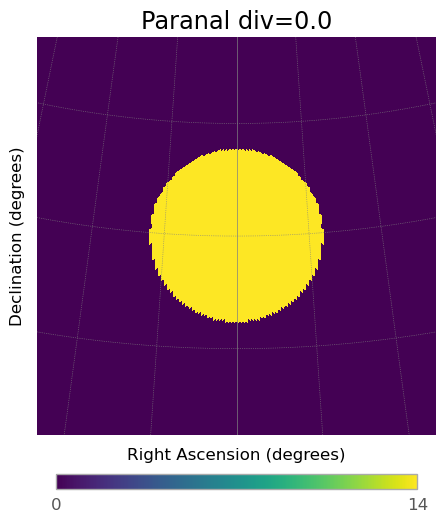

4it [00:00,  7.45it/s]


The FoV and the average multiplicity is for array_3 with divergence0.00 and altitude30.00 : (46.56768334601333, 14.0)


4it [00:00,  7.58it/s]
4it [00:00,  7.42it/s]
4it [00:00,  7.08it/s]
4it [00:00,  6.69it/s]


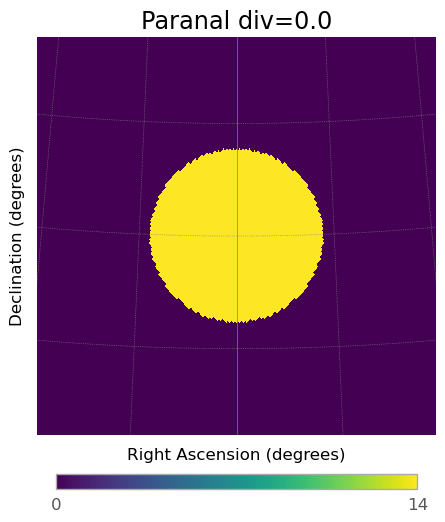

4it [00:00,  7.08it/s]


The FoV and the average multiplicity is for array_3 with divergence0.01 and altitude70.00 : (59.275113693038655, 10.997345132743362)


4it [00:00,  6.84it/s]
4it [00:00,  5.63it/s]
4it [00:00,  5.43it/s]
4it [00:00,  4.58it/s]


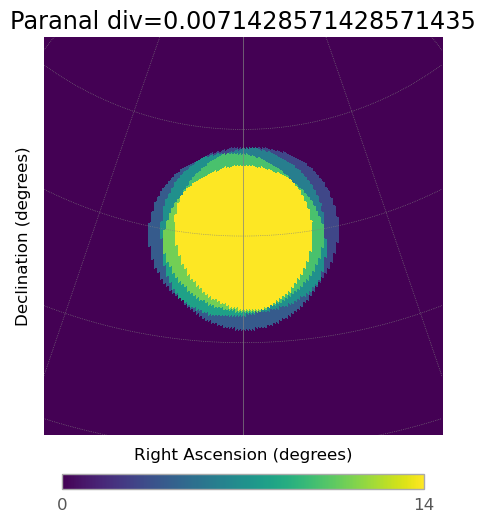

4it [00:00,  4.21it/s]


The FoV and the average multiplicity is for array_3 with divergence0.01 and altitude50.00 : (58.462047974240335, 11.140197397936294)


4it [00:00,  4.71it/s]
4it [00:00,  6.09it/s]
4it [00:00,  5.91it/s]
4it [00:00,  5.03it/s]


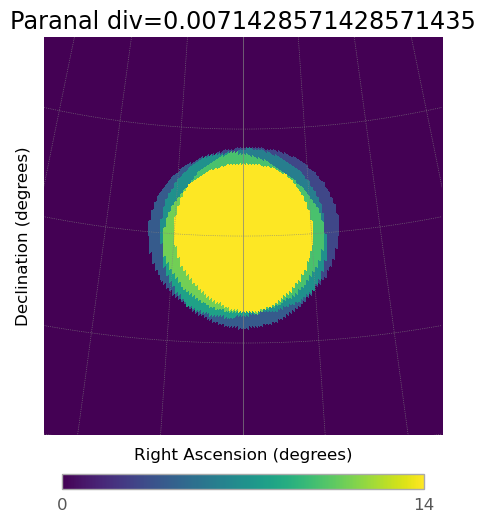

4it [00:00,  5.86it/s]


The FoV and the average multiplicity is for array_3 with divergence0.01 and altitude30.00 : (57.347361101694254, 11.380974159615825)


4it [00:00,  7.08it/s]
4it [00:00,  6.76it/s]
4it [00:00,  6.71it/s]
4it [00:00,  6.43it/s]


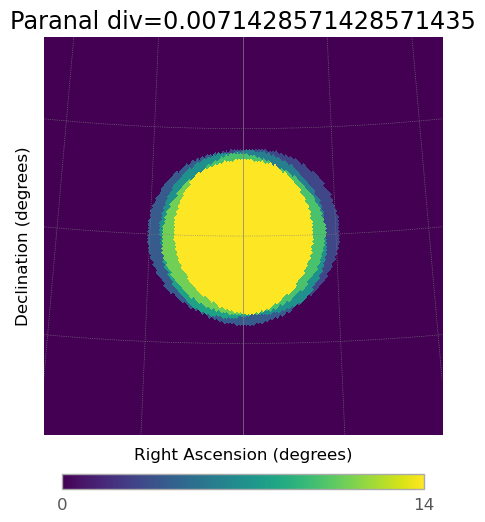

4it [00:00,  6.83it/s]


The FoV and the average multiplicity is for array_3 with divergence0.01 and altitude70.00 : (72.80872372206872, 8.947046109510087)


4it [00:00,  7.10it/s]
4it [00:00,  6.77it/s]
4it [00:00,  6.89it/s]
4it [00:00,  6.42it/s]


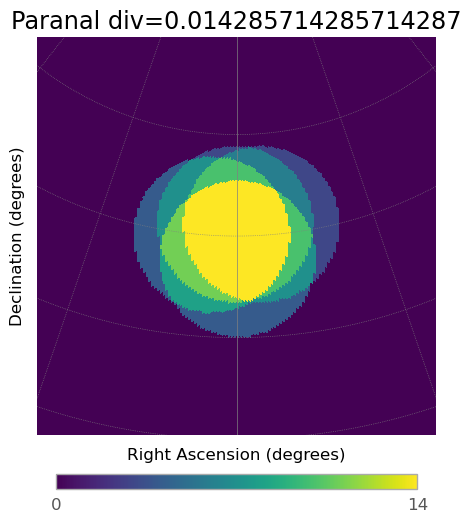

4it [00:00,  6.66it/s]


The FoV and the average multiplicity is for array_3 with divergence0.01 and altitude50.00 : (71.02522472599499, 9.170605612998523)


4it [00:00,  7.33it/s]
4it [00:00,  6.68it/s]
4it [00:00,  6.86it/s]
4it [00:00,  6.01it/s]


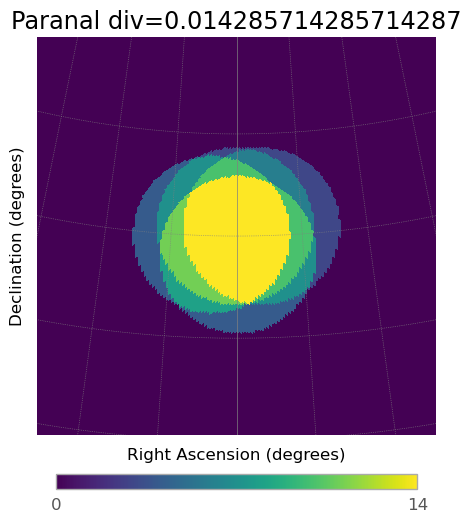

4it [00:00,  7.16it/s]


The FoV and the average multiplicity is for array_3 with divergence0.01 and altitude30.00 : (68.38931812150366, 9.531351869606903)


4it [00:00,  7.34it/s]
4it [00:00,  7.46it/s]
4it [00:00,  7.44it/s]
4it [00:00,  6.78it/s]


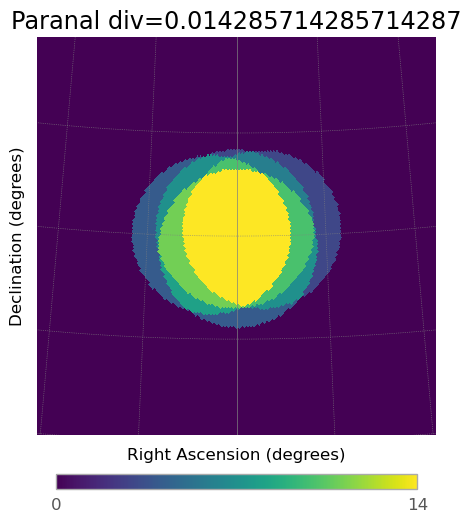

4it [00:00,  6.81it/s]


The FoV and the average multiplicity is for array_3 with divergence0.02 and altitude70.00 : (87.29965306516777, 7.467778278503831)


4it [00:00,  7.40it/s]
4it [00:00,  7.02it/s]
4it [00:00,  6.85it/s]
4it [00:00,  6.87it/s]


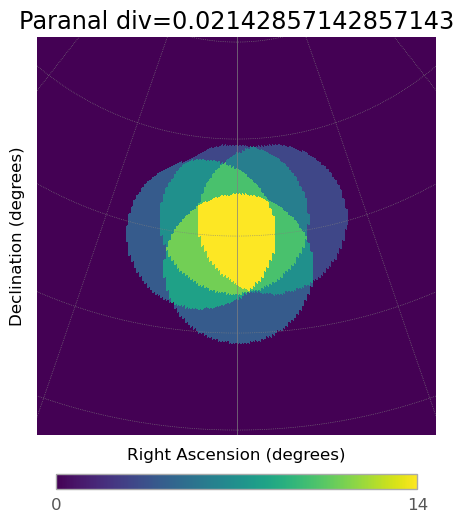

4it [00:00,  7.41it/s]


The FoV and the average multiplicity is for array_3 with divergence0.02 and altitude50.00 : (84.17852982203874, 7.737809627667861)


4it [00:00,  7.41it/s]
4it [00:00,  7.32it/s]
4it [00:00,  7.05it/s]
4it [00:00,  6.73it/s]


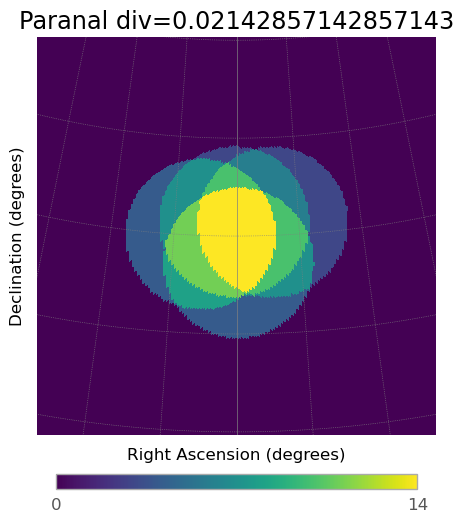

4it [00:00,  7.54it/s]


The FoV and the average multiplicity is for array_3 with divergence0.02 and altitude30.00 : (79.92960574315721, 8.148974569319114)


4it [00:00,  7.31it/s]
4it [00:00,  7.15it/s]
4it [00:00,  7.39it/s]
4it [00:00,  6.59it/s]


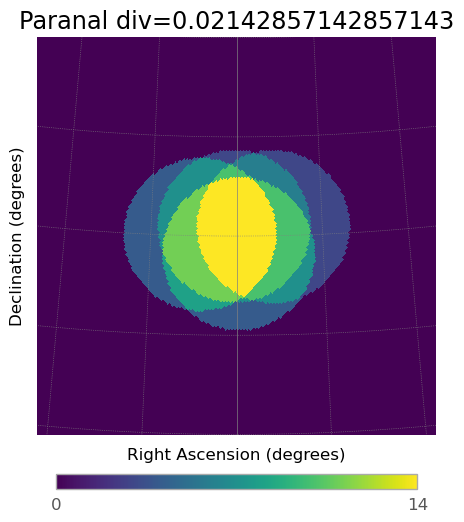

4it [00:00,  7.04it/s]


The FoV and the average multiplicity is for array_3 with divergence0.03 and altitude70.00 : (102.24957112049168, 6.371553161472361)


4it [00:00,  7.37it/s]
4it [00:00,  7.10it/s]
4it [00:00,  7.19it/s]
4it [00:00,  7.03it/s]


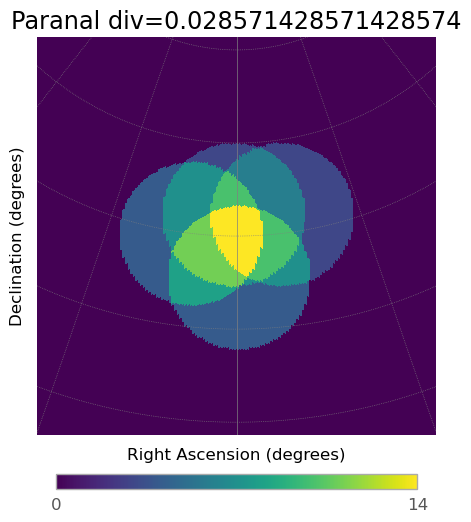

4it [00:00,  7.00it/s]


The FoV and the average multiplicity is for array_3 with divergence0.03 and altitude50.00 : (97.90884929916517, 6.656040717921243)


4it [00:00,  7.31it/s]
4it [00:00,  7.20it/s]
4it [00:00,  7.40it/s]
4it [00:00,  6.33it/s]


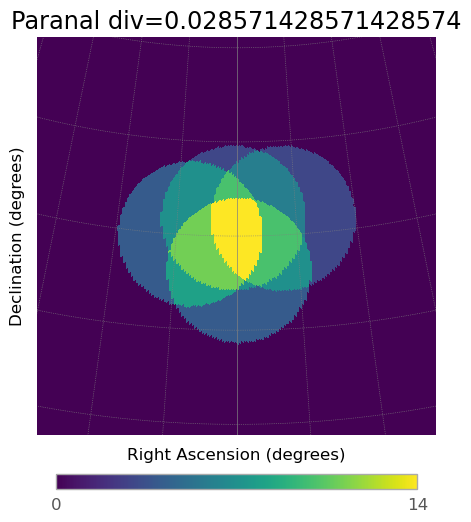

4it [00:00,  7.48it/s]


The FoV and the average multiplicity is for array_3 with divergence0.03 and altitude30.00 : (91.94199604024203, 7.081871345029239)


4it [00:00,  7.39it/s]
4it [00:00,  7.33it/s]
4it [00:00,  7.48it/s]
4it [00:00,  6.60it/s]


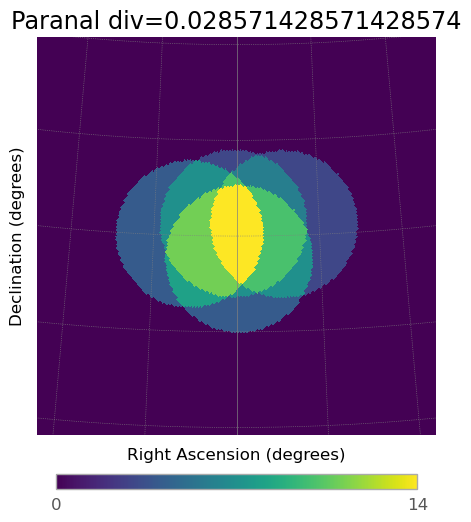

4it [00:00,  7.30it/s]


The FoV and the average multiplicity is for array_3 with divergence0.04 and altitude70.00 : (117.60602203521475, 5.5421498661909006)


4it [00:00,  7.23it/s]
4it [00:00,  7.26it/s]
4it [00:00,  7.50it/s]
4it [00:00,  6.83it/s]


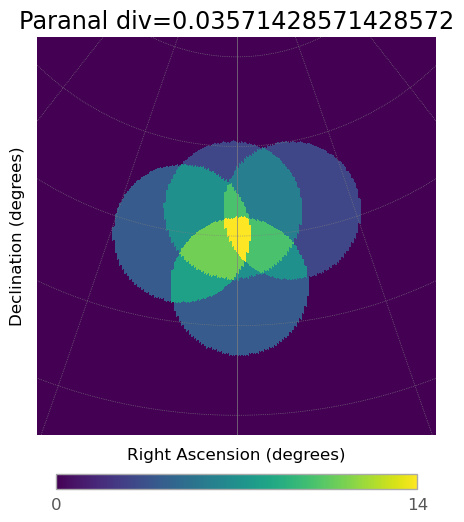

4it [00:00,  7.57it/s]


The FoV and the average multiplicity is for array_3 with divergence0.04 and altitude50.00 : (111.9539038932458, 5.8205458592011245)


4it [00:00,  7.08it/s]
4it [00:00,  7.35it/s]
4it [00:00,  7.13it/s]
4it [00:00,  6.78it/s]


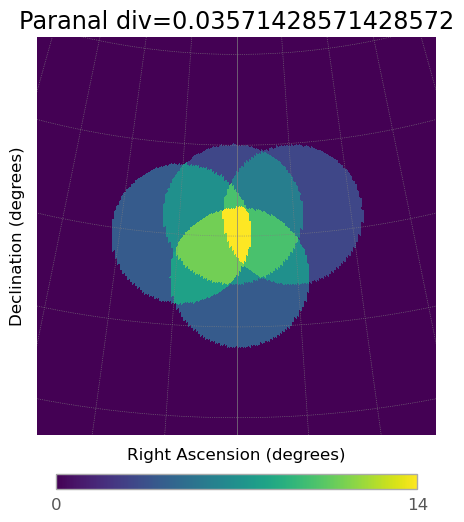

4it [00:00,  7.43it/s]


The FoV and the average multiplicity is for array_3 with divergence0.04 and altitude30.00 : (103.98061426373971, 6.2629587589860005)


4it [00:00,  7.22it/s]
4it [00:00,  7.05it/s]
4it [00:00,  7.49it/s]
4it [00:00,  6.83it/s]


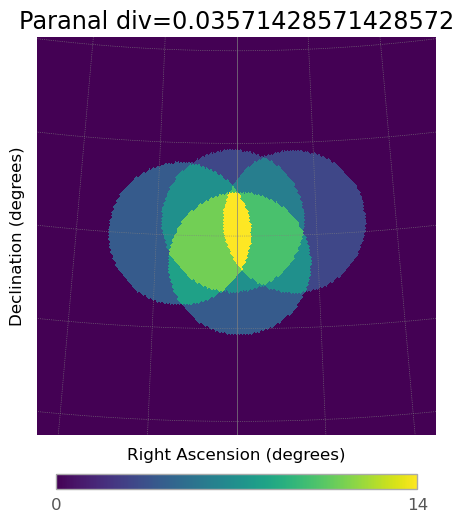

In [101]:
hFoV_altitude_1_configuration_3=[]
hFoV_altitude_2_configuration_3=[]
hFoV_altitude_3_configuration_3=[]
multiplicity_altitude_1_configuration_3=[]
multiplicity_altitude_2_configuration_3=[]
multiplicity_altitude_3_configuration_3=[]
for divergence in stop_div:
    for alt in altitude_array:
        array_3.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_3 with divergence{divergence:.2f} and altitude{alt:.2f} :",array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3))
        if alt==altitude_array[0]:
            hFoV_altitude_1_configuration_3.append(array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[0])
            multiplicity_altitude_1_configuration_3.append(array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[1])
        if alt==altitude_array[1]:
            hFoV_altitude_2_configuration_3.append(array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[0])
            multiplicity_altitude_2_configuration_3.append(array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[1])
        if alt==altitude_array[2]:
            hFoV_altitude_3_configuration_3.append(array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[0])
            multiplicity_altitude_3_configuration_3.append(array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[1])
        array_3.multiplicity_plot(number_of_telescopes_subarray_3)
        


4it [00:00,  7.46it/s]


The FoV and the average multiplicity is for array_4 with divergence0.00 and altitude70.00 : (46.42342975074266, 14.0)


4it [00:00,  7.41it/s]
4it [00:00,  6.68it/s]
4it [00:00,  7.31it/s]
4it [00:00,  6.50it/s]


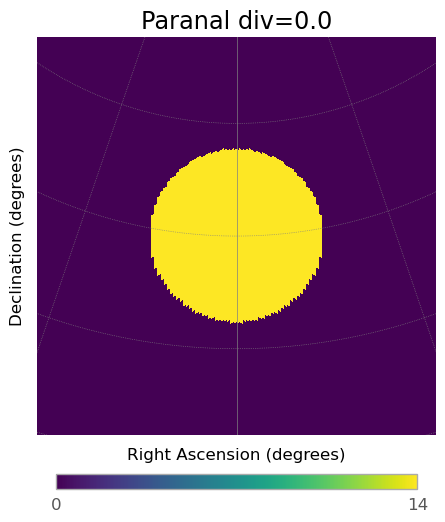

4it [00:00,  7.18it/s]


The FoV and the average multiplicity is for array_4 with divergence0.00 and altitude50.00 : (46.55456938280691, 14.0)


4it [00:00,  5.75it/s]
4it [00:00,  7.13it/s]
4it [00:00,  7.10it/s]
4it [00:00,  6.77it/s]


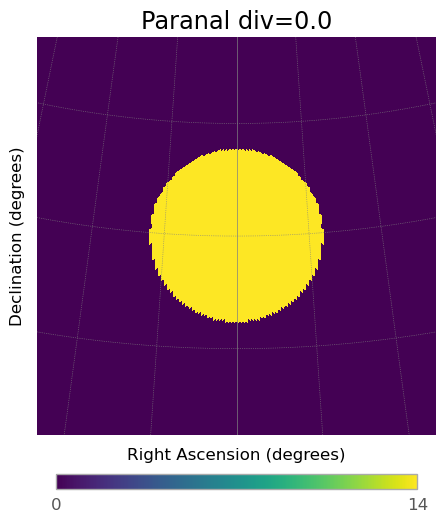

4it [00:00,  7.15it/s]


The FoV and the average multiplicity is for array_4 with divergence0.00 and altitude30.00 : (46.56768334601333, 14.0)


4it [00:00,  6.86it/s]
4it [00:00,  7.22it/s]
4it [00:00,  7.31it/s]
4it [00:00,  6.62it/s]


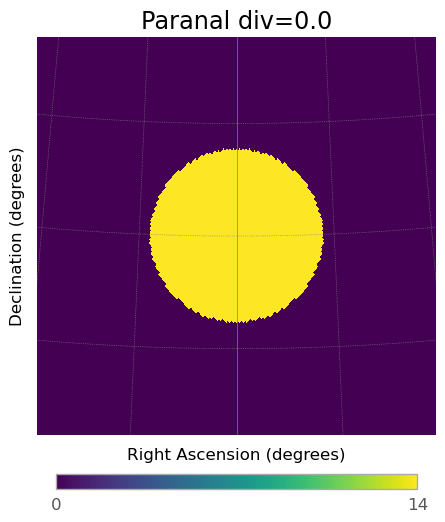

4it [00:00,  7.42it/s]


The FoV and the average multiplicity is for array_4 with divergence0.01 and altitude70.00 : (56.79657464702443, 11.487416301085199)


4it [00:00,  7.30it/s]
4it [00:00,  7.43it/s]
4it [00:00,  6.62it/s]
4it [00:00,  6.68it/s]


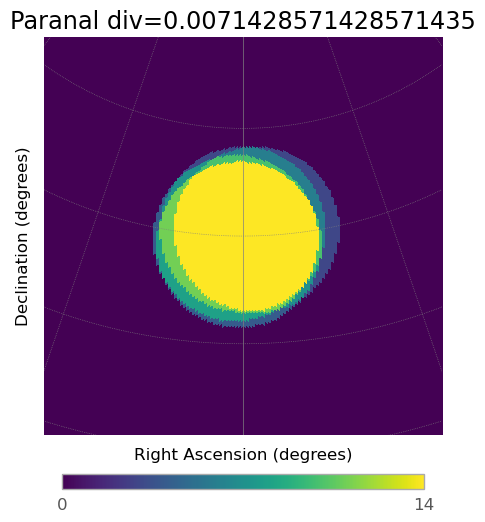

4it [00:00,  7.30it/s]


The FoV and the average multiplicity is for array_4 with divergence0.01 and altitude50.00 : (56.101534597083926, 11.618279569892474)


4it [00:00,  7.17it/s]
4it [00:00,  7.22it/s]
4it [00:00,  7.40it/s]
4it [00:00,  6.72it/s]


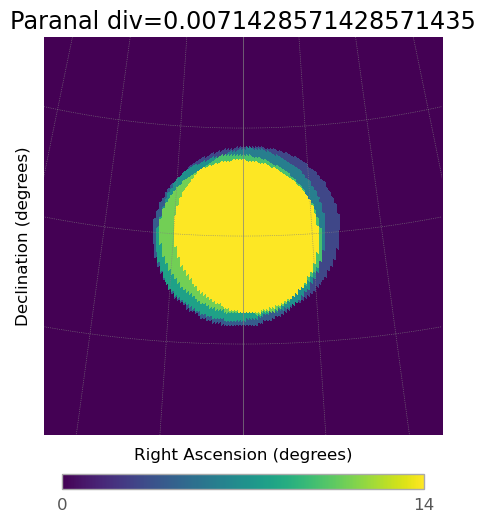

4it [00:00,  7.52it/s]


The FoV and the average multiplicity is for array_4 with divergence0.01 and altitude30.00 : (55.09175943018924, 11.839323970483218)


4it [00:00,  7.48it/s]
4it [00:00,  7.46it/s]
4it [00:00,  7.16it/s]
4it [00:00,  6.59it/s]


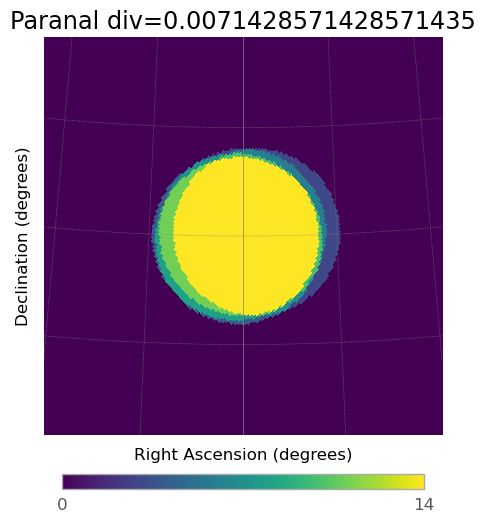

4it [00:00,  7.36it/s]


The FoV and the average multiplicity is for array_4 with divergence0.01 and altitude70.00 : (67.4975686234668, 9.649504565766465)


4it [00:00,  7.09it/s]
4it [00:00,  7.28it/s]
4it [00:00,  7.44it/s]
4it [00:00,  6.95it/s]


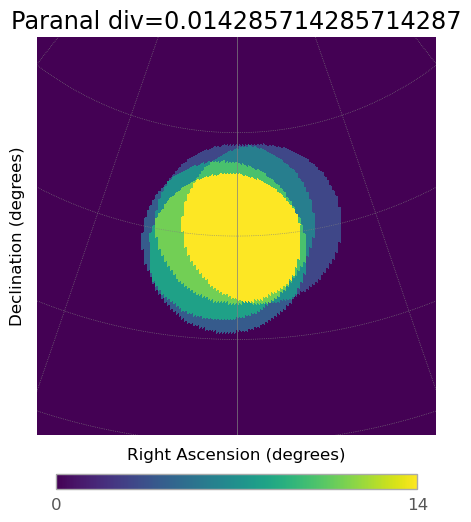

4it [00:00,  7.44it/s]


The FoV and the average multiplicity is for array_4 with divergence0.01 and altitude50.00 : (66.08126059717296, 9.865449493947212)


4it [00:00,  7.46it/s]
4it [00:00,  7.49it/s]
4it [00:00,  7.25it/s]
4it [00:00,  7.03it/s]


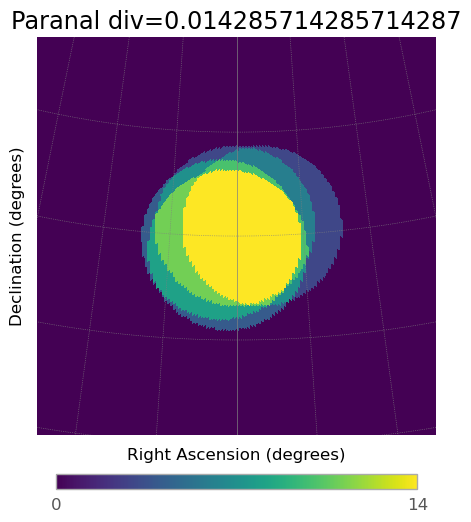

4it [00:00,  7.07it/s]


The FoV and the average multiplicity is for array_4 with divergence0.01 and altitude30.00 : (63.851886852080796, 10.202916409940439)


4it [00:00,  7.37it/s]
4it [00:00,  7.39it/s]
4it [00:00,  7.57it/s]
4it [00:00,  6.82it/s]


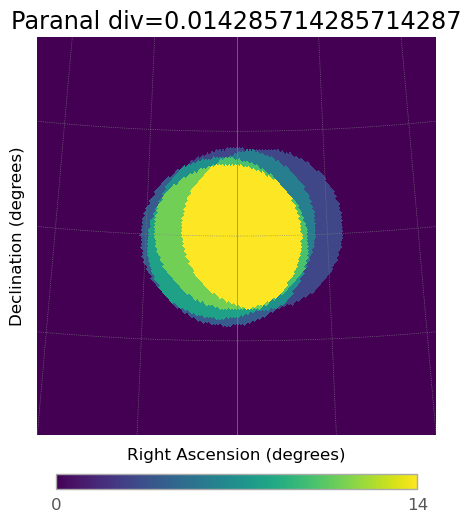

4it [00:00,  7.55it/s]


The FoV and the average multiplicity is for array_4 with divergence0.02 and altitude70.00 : (78.60509545930834, 8.290457123790457)


4it [00:00,  7.42it/s]
4it [00:00,  7.26it/s]
4it [00:00,  6.92it/s]
4it [00:00,  6.54it/s]


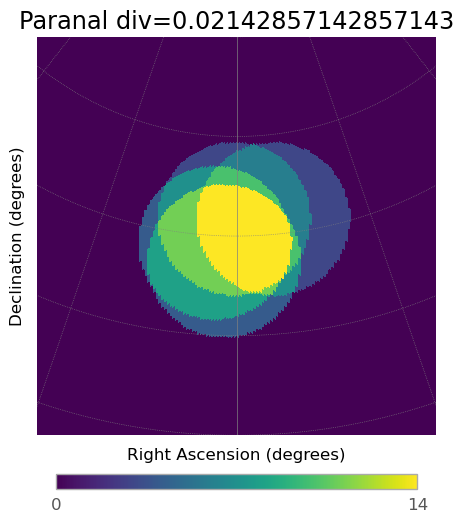

4it [00:00,  6.76it/s]


The FoV and the average multiplicity is for array_4 with divergence0.02 and altitude50.00 : (76.19212622932623, 8.550946643717728)


4it [00:00,  6.98it/s]
4it [00:00,  7.04it/s]
4it [00:00,  7.22it/s]
4it [00:00,  6.91it/s]


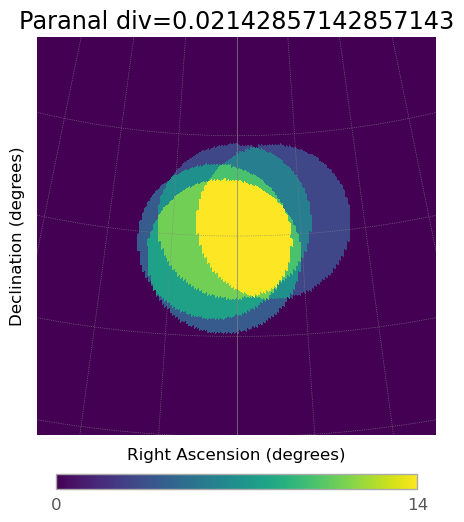

4it [00:00,  7.40it/s]


The FoV and the average multiplicity is for array_4 with divergence0.02 and altitude30.00 : (72.87429353810084, 8.944394457441065)


4it [00:00,  7.31it/s]
4it [00:00,  7.27it/s]
4it [00:00,  7.35it/s]
4it [00:00,  7.08it/s]


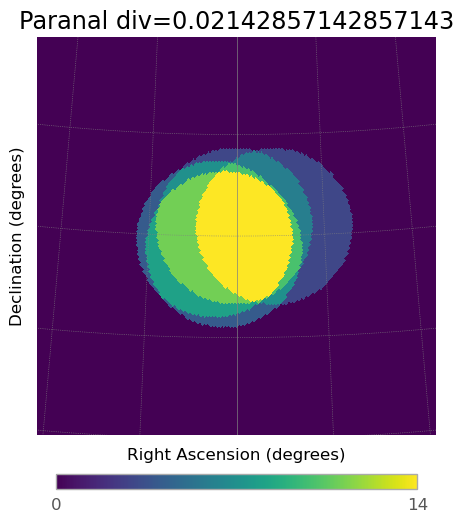

4it [00:00,  7.30it/s]


The FoV and the average multiplicity is for array_4 with divergence0.03 and altitude70.00 : (90.06669930172333, 7.229324403028538)


4it [00:00,  7.36it/s]
4it [00:00,  7.34it/s]
4it [00:00,  7.45it/s]
4it [00:00,  6.67it/s]


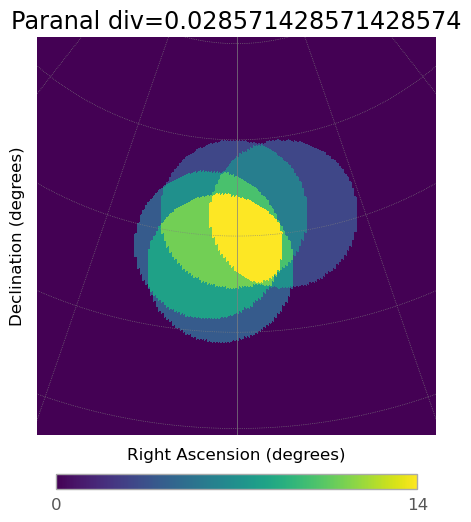

4it [00:00,  7.52it/s]


The FoV and the average multiplicity is for array_4 with divergence0.03 and altitude50.00 : (86.74886661049794, 7.520181405895691)


4it [00:00,  7.44it/s]
4it [00:00,  7.17it/s]
4it [00:00,  6.92it/s]
4it [00:00,  6.51it/s]


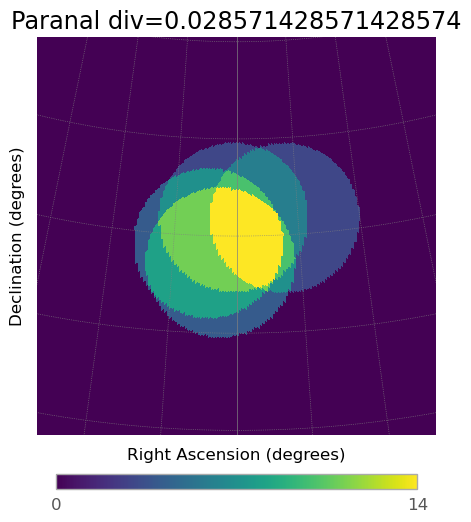

4it [00:00,  7.26it/s]


The FoV and the average multiplicity is for array_4 with divergence0.03 and altitude30.00 : (82.08029570901083, 7.941044895350695)


4it [00:00,  7.45it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.32it/s]
4it [00:00,  6.72it/s]


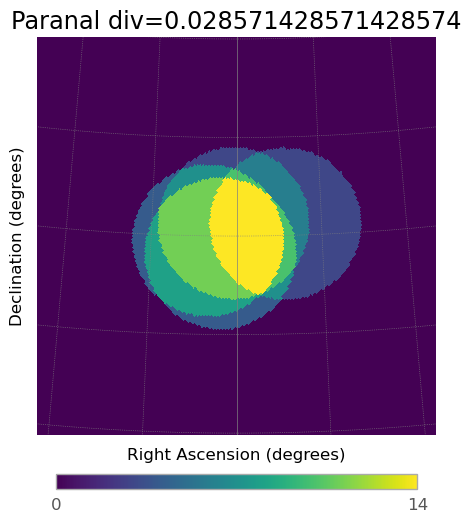

4it [00:00,  6.99it/s]


The FoV and the average multiplicity is for array_4 with divergence0.04 and altitude70.00 : (101.63321484978972, 6.413161290322581)


4it [00:00,  7.23it/s]
4it [00:00,  7.08it/s]
4it [00:00,  7.49it/s]
4it [00:00,  6.64it/s]


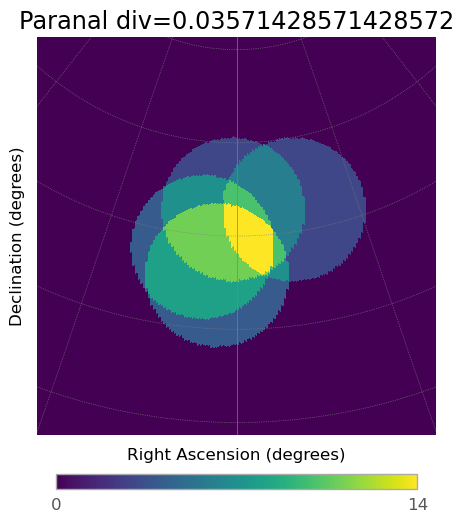

4it [00:00,  7.48it/s]


The FoV and the average multiplicity is for array_4 with divergence0.04 and altitude50.00 : (97.34494888128893, 6.69513673716826)


4it [00:00,  7.30it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.22it/s]
4it [00:00,  6.90it/s]


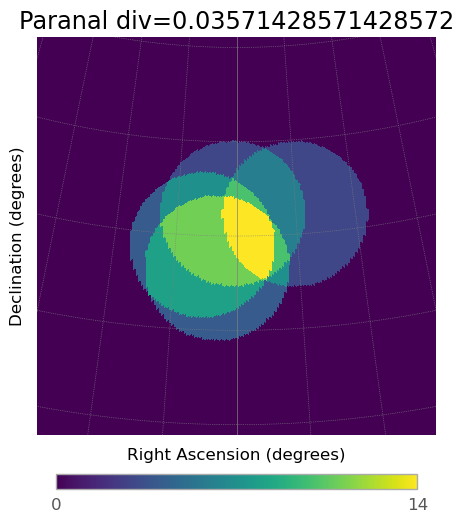

4it [00:00,  7.56it/s]


The FoV and the average multiplicity is for array_4 with divergence0.04 and altitude30.00 : (91.22072806388869, 7.141316848763657)


4it [00:00,  7.40it/s]
4it [00:00,  7.48it/s]
4it [00:00,  7.42it/s]
4it [00:00,  6.97it/s]


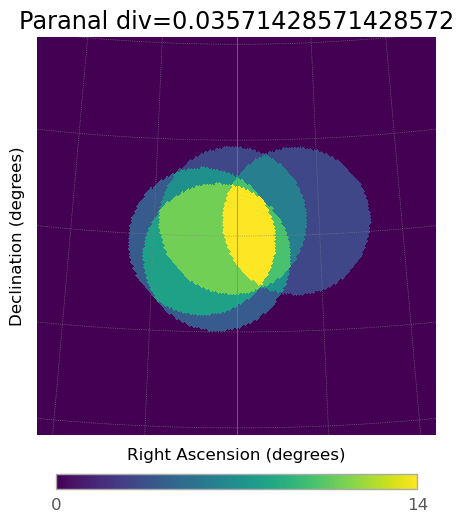

In [117]:
hFoV_altitude_1_configuration_4=[]
hFoV_altitude_2_configuration_4=[]
hFoV_altitude_3_configuration_4=[]
multiplicity_altitude_1_configuration_4=[]
multiplicity_altitude_2_configuration_4=[]
multiplicity_altitude_3_configuration_4=[]
for divergence in stop_div:
    for alt in altitude_array:
        array_4.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_4 with divergence{divergence:.2f} and altitude{alt:.2f} :",array_4.hFoV(subarray_mult=number_of_telescopes_subarray_3))
        if alt==altitude_array[0]:
            hFoV_altitude_1_configuration_4.append(array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4)[0])
            multiplicity_altitude_1_configuration_4.append(array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4)[1])
        if alt==altitude_array[1]:
            hFoV_altitude_2_configuration_4.append(array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4)[0])
            multiplicity_altitude_2_configuration_4.append(array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4)[1])
        if alt==altitude_array[2]:
            hFoV_altitude_3_configuration_4.append(array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4)[0])
            multiplicity_altitude_3_configuration_4.append(array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4)[1])
        array_4.multiplicity_plot(number_of_telescopes_subarray_4)
        

In [108]:
for divergence in stop_div_sub_1_2_full:
    for alt in altitude_array:
        array.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_1 with divergence{divergence:.2f} and altitude{alt:.2f} :",array.hFoV(subarray_mult=number_of_telescopes_subarray_1))
        #print(f"The FoV and the average multiplicity is for array_1 with divergence{divergence:.2f} and altitude{alt:.2f} :",array.hFoV(subarray_mult=number_of_telescopes_subarray_1))

4it [00:00,  6.79it/s]


The FoV and the average multiplicity is for array_1 with divergence0.00 and altitude70.00 : (46.42342975074266, 14.0)


4it [00:00,  7.04it/s]


The FoV and the average multiplicity is for array_1 with divergence0.00 and altitude50.00 : (46.55456938280691, 14.0)


4it [00:00,  7.36it/s]


The FoV and the average multiplicity is for array_1 with divergence0.00 and altitude30.00 : (46.56768334601333, 14.0)


4it [00:00,  7.34it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude70.00 : (62.606060347470475, 10.412232928361961)


4it [00:00,  6.91it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude50.00 : (60.6389658665068, 10.744377162629759)


4it [00:00,  7.15it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude30.00 : (57.97683133560263, 11.247002940511196)


4it [00:00,  7.44it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude70.00 : (80.2967967129371, 8.119385921933693)


4it [00:00,  7.47it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude50.00 : (76.2839239717712, 8.543922984356197)


4it [00:00,  7.41it/s]


The FoV and the average multiplicity is for array_1 with divergence0.01 and altitude30.00 : (70.36952656567377, 9.270219903093553)


4it [00:00,  7.30it/s]


The FoV and the average multiplicity is for array_1 with divergence0.02 and altitude70.00 : (99.11533391415622, 6.574093675575549)


4it [00:00,  7.08it/s]


The FoV and the average multiplicity is for array_1 with divergence0.02 and altitude50.00 : (93.01734102316884, 7.002678697307204)


4it [00:00,  7.36it/s]


The FoV and the average multiplicity is for array_1 with divergence0.02 and altitude30.00 : (83.32612221362115, 7.816650928548945)


4it [00:00,  7.25it/s]


The FoV and the average multiplicity is for array_1 with divergence0.03 and altitude70.00 : (118.68136701814156, 5.491381215469613)


4it [00:00,  6.92it/s]


The FoV and the average multiplicity is for array_1 with divergence0.03 and altitude50.00 : (110.62939360939693, 5.89307728781413)


4it [00:00,  7.23it/s]

The FoV and the average multiplicity is for array_1 with divergence0.03 and altitude30.00 : (97.2793790652568, 6.698301428956592)


In [105]:
for divergence in stop_div_sub_1_2_full:
    for alt in altitude_array:
        array_2.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_2 with divergence{divergence:.2f} and altitude{alt:.2f} :",array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2))
        #print(f"The FoV and the average multiplicity is for array_1 with divergence{divergence:.2f} and altitude{alt:.2f} :",array.hFoV(subarray_mult=number_of_telescopes_subarray_1))

4it [00:00,  7.18it/s]


The FoV and the average multiplicity is for array_2 with divergence0.00 and altitude70.00 : (46.42342975074266, 14.0)


4it [00:00,  7.32it/s]


The FoV and the average multiplicity is for array_2 with divergence0.00 and altitude50.00 : (46.55456938280691, 14.0)


4it [00:00,  7.38it/s]


The FoV and the average multiplicity is for array_2 with divergence0.00 and altitude30.00 : (46.56768334601333, 14.0)


4it [00:00,  7.31it/s]


The FoV and the average multiplicity is for array_2 with divergence0.01 and altitude70.00 : (65.1895110991361, 10.002816334741501)


4it [00:00,  6.82it/s]


The FoV and the average multiplicity is for array_2 with divergence0.01 and altitude50.00 : (63.065049059695326, 10.339155749636099)


4it [00:00,  6.29it/s]


The FoV and the average multiplicity is for array_2 with divergence0.01 and altitude30.00 : (59.9439258165663, 10.877488514548238)


4it [00:00,  5.89it/s]


The FoV and the average multiplicity is for array_2 with divergence0.01 and altitude70.00 : (85.62106577474543, 7.603920967988972)


4it [00:00,  7.08it/s]


The FoV and the average multiplicity is for array_2 with divergence0.01 and altitude50.00 : (81.25411602700608, 8.020174306003874)


4it [00:00,  7.06it/s]


The FoV and the average multiplicity is for array_2 with divergence0.01 and altitude30.00 : (74.30371552760111, 8.765442993293329)


4it [00:00,  7.06it/s]


The FoV and the average multiplicity is for array_2 with divergence0.02 and altitude70.00 : (107.87546133604778, 6.047289083394117)


4it [00:00,  7.20it/s]


The FoV and the average multiplicity is for array_2 with divergence0.02 and altitude50.00 : (100.63655364610146, 6.475762314308053)


4it [00:00,  7.23it/s]


The FoV and the average multiplicity is for array_2 with divergence0.02 and altitude30.00 : (89.68639436873703, 7.2703611639128525)


4it [00:00,  7.19it/s]


The FoV and the average multiplicity is for array_2 with divergence0.03 and altitude70.00 : (130.89046676332273, 4.976455265003507)


4it [00:00,  7.22it/s]


The FoV and the average multiplicity is for array_2 with divergence0.03 and altitude50.00 : (121.30415965942645, 5.368972972972973)


4it [00:00,  7.01it/s]

The FoV and the average multiplicity is for array_2 with divergence0.03 and altitude30.00 : (105.89525289187769, 6.153808049535604)


In [106]:
for divergence in stop_div:
    for alt in altitude_array:
        array_3.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_3 with divergence{divergence:.2f} and altitude{alt:.2f} :",array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3))
        #print(f"The FoV and the average multiplicity is for array_1 with divergence{divergence:.2f} and altitude{alt:.2f} :",array.hFoV(subarray_mult=number_of_telescopes_subarray_1))

4it [00:00,  7.31it/s]


The FoV and the average multiplicity is for array_3 with divergence0.00 and altitude70.00 : (46.42342975074266, 14.0)


4it [00:00,  7.28it/s]


The FoV and the average multiplicity is for array_3 with divergence0.00 and altitude50.00 : (46.55456938280691, 14.0)


4it [00:00,  7.35it/s]


The FoV and the average multiplicity is for array_3 with divergence0.00 and altitude30.00 : (46.56768334601333, 14.0)


4it [00:00,  7.41it/s]


The FoV and the average multiplicity is for array_3 with divergence0.01 and altitude70.00 : (59.275113693038655, 10.997345132743362)


4it [00:00,  6.96it/s]


The FoV and the average multiplicity is for array_3 with divergence0.01 and altitude50.00 : (58.462047974240335, 11.140197397936294)


4it [00:00,  6.99it/s]


The FoV and the average multiplicity is for array_3 with divergence0.01 and altitude30.00 : (57.347361101694254, 11.380974159615825)


4it [00:00,  7.31it/s]


The FoV and the average multiplicity is for array_3 with divergence0.01 and altitude70.00 : (72.80872372206872, 8.947046109510087)


4it [00:00,  7.30it/s]


The FoV and the average multiplicity is for array_3 with divergence0.01 and altitude50.00 : (71.02522472599499, 9.170605612998523)


4it [00:00,  7.16it/s]


The FoV and the average multiplicity is for array_3 with divergence0.01 and altitude30.00 : (68.38931812150366, 9.531351869606903)


4it [00:00,  7.28it/s]


The FoV and the average multiplicity is for array_3 with divergence0.02 and altitude70.00 : (87.29965306516777, 7.467778278503831)


4it [00:00,  6.90it/s]


The FoV and the average multiplicity is for array_3 with divergence0.02 and altitude50.00 : (84.17852982203874, 7.737809627667861)


4it [00:00,  7.13it/s]


The FoV and the average multiplicity is for array_3 with divergence0.02 and altitude30.00 : (79.92960574315721, 8.148974569319114)


4it [00:00,  7.03it/s]


The FoV and the average multiplicity is for array_3 with divergence0.03 and altitude70.00 : (102.24957112049168, 6.371553161472361)


4it [00:00,  6.68it/s]


The FoV and the average multiplicity is for array_3 with divergence0.03 and altitude50.00 : (97.90884929916517, 6.656040717921243)


4it [00:00,  7.36it/s]


The FoV and the average multiplicity is for array_3 with divergence0.03 and altitude30.00 : (91.94199604024203, 7.081871345029239)


4it [00:00,  7.49it/s]


The FoV and the average multiplicity is for array_3 with divergence0.04 and altitude70.00 : (117.60602203521475, 5.5421498661909006)


4it [00:00,  7.48it/s]


The FoV and the average multiplicity is for array_3 with divergence0.04 and altitude50.00 : (111.9539038932458, 5.8205458592011245)


4it [00:00,  7.07it/s]

The FoV and the average multiplicity is for array_3 with divergence0.04 and altitude30.00 : (103.98061426373971, 6.2629587589860005)


In [115]:
for divergence in stop_div:
    for alt in altitude_array:
        array_4.divergent_pointing(div=divergence, az=0, alt=alt)
        print(f"The FoV and the average multiplicity is for array_4 with divergence{divergence:.2f} and altitude{alt:.2f} :",array_4.hFoV(subarray_mult=number_of_telescopes_subarray_4))
        #print(f"The FoV and the average multiplicity is for array_1 with divergence{divergence:.2f} and altitude{alt:.2f} :",array.hFoV(subarray_mult=number_of_telescopes_subarray_1))

4it [00:00,  6.65it/s]


The FoV and the average multiplicity is for array_4 with divergence0.00 and altitude70.00 : (46.42342975074266, 14.0)


4it [00:00,  7.40it/s]


The FoV and the average multiplicity is for array_4 with divergence0.00 and altitude50.00 : (46.55456938280691, 14.0)


4it [00:00,  7.28it/s]


The FoV and the average multiplicity is for array_4 with divergence0.00 and altitude30.00 : (46.56768334601333, 14.0)


4it [00:00,  7.27it/s]


The FoV and the average multiplicity is for array_4 with divergence0.01 and altitude70.00 : (56.79657464702443, 11.487416301085199)


4it [00:00,  7.21it/s]


The FoV and the average multiplicity is for array_4 with divergence0.01 and altitude50.00 : (56.101534597083926, 11.618279569892474)


4it [00:00,  7.40it/s]


The FoV and the average multiplicity is for array_4 with divergence0.01 and altitude30.00 : (55.09175943018924, 11.839323970483218)


4it [00:00,  7.40it/s]


The FoV and the average multiplicity is for array_4 with divergence0.01 and altitude70.00 : (67.4975686234668, 9.649504565766465)


4it [00:00,  7.15it/s]


The FoV and the average multiplicity is for array_4 with divergence0.01 and altitude50.00 : (66.08126059717296, 9.865449493947212)


4it [00:00,  7.32it/s]


The FoV and the average multiplicity is for array_4 with divergence0.01 and altitude30.00 : (63.851886852080796, 10.202916409940439)


4it [00:00,  7.38it/s]


The FoV and the average multiplicity is for array_4 with divergence0.02 and altitude70.00 : (78.60509545930834, 8.290457123790457)


4it [00:00,  6.94it/s]


The FoV and the average multiplicity is for array_4 with divergence0.02 and altitude50.00 : (76.19212622932623, 8.550946643717728)


4it [00:00,  7.16it/s]


The FoV and the average multiplicity is for array_4 with divergence0.02 and altitude30.00 : (72.87429353810084, 8.944394457441065)


4it [00:00,  7.43it/s]


The FoV and the average multiplicity is for array_4 with divergence0.03 and altitude70.00 : (90.06669930172333, 7.229324403028538)


4it [00:00,  7.10it/s]


The FoV and the average multiplicity is for array_4 with divergence0.03 and altitude50.00 : (86.74886661049794, 7.520181405895691)


4it [00:00,  7.37it/s]


The FoV and the average multiplicity is for array_4 with divergence0.03 and altitude30.00 : (82.08029570901083, 7.941044895350695)


4it [00:00,  7.34it/s]


The FoV and the average multiplicity is for array_4 with divergence0.04 and altitude70.00 : (101.63321484978972, 6.413161290322581)


4it [00:00,  7.00it/s]


The FoV and the average multiplicity is for array_4 with divergence0.04 and altitude50.00 : (97.34494888128893, 6.69513673716826)


4it [00:00,  7.12it/s]

The FoV and the average multiplicity is for array_4 with divergence0.04 and altitude30.00 : (91.22072806388869, 7.141316848763657)


In [176]:
def multiplicity_plot(array, subarray_mult=None, fig=None):
        if array.table.units == 'rad':
            array.__convert_units__(toDeg=True)

        coord = array.get_pointing_coord(icrs=True)
        nside = 512
        map_multiplicity = np.zeros(hp.nside2npix(nside), dtype=np.float64)

        # Initialize Healpix coordinates
        counter = np.arange(0, hp.nside2npix(nside))
        ra, dec = hp.pix2ang(nside, counter, True, lonlat=True)
        coordinate = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)

        # If subarray_mult is not provided, set all multiplicities to 1
        if subarray_mult is None:
            subarray_mult = np.ones(len(array.telescopes))

        # Iterate over telescopes
        for i, tel in tqdm.tqdm(enumerate(array.telescopes)):
            pointing = SkyCoord(ra=coord.ra[i].degree, dec=coord.dec[i].degree, unit='deg')
            r_fov = np.arctan((tel.camera_radius / tel.focal).to(u.dimensionless_unscaled)).to(u.deg)
            mask = coordinate.separation(pointing) < r_fov

            # Add intrinsic multiplicity for this telescope
            map_multiplicity[mask] += subarray_mult[i]
        
        R=np.sqrt(array.hFoV()[0]/np.pi) + 5
        hp.cartview(map_multiplicity, rot=[array.pointing["az"].value, array.pointing["alt"].value],
                lonra=[-R,R], latra=[-R,R], nest=True, cmap='viridis', title=f"{array.frame.site} div={array.div}")
        # Annotate with axis labels:
        plt.annotate('Right Ascension (degrees)', xy=(0.5, -0.05), xycoords='axes fraction', ha='center', va='center')
        plt.annotate('Declination (degrees)', 
                     xy=(-0.05, 0.5), xycoords='axes fraction', 
                     ha='center', va='center', rotation='vertical')
        hp.graticule(dpar=5, dmer=5, coord='G', color='gray', lw=0.5)

        plt.show()

In [159]:
altitude_array=[90,70,50,30,0]

In [179]:
pointings90=[]
pointings70=[]
pointings50=[]
pointings30=[]
pointings0=[]
for alt in altitude_array:
        array.divergent_pointing(div=0.03, az=0, alt=alt)
        coord=array.get_pointing_coord(icrs=False)
        for i, tel in tqdm.tqdm(enumerate(array.telescopes)):
            if alt ==90:
                pointings90.append(SkyCoord(ra=coord.az[i].degree, dec=coord.alt[i].degree, unit='deg'))
            elif alt ==70:
                pointings70.append(SkyCoord(ra=coord.az[i].degree, dec=coord.alt[i].degree, unit='deg'))
            elif alt ==50:
                pointings50.append(SkyCoord(ra=coord.az[i].degree, dec=coord.alt[i].degree, unit='deg'))
            elif alt ==30:
                pointings30.append(SkyCoord(ra=coord.az[i].degree, dec=coord.alt[i].degree, unit='deg'))
            elif alt ==0:
                pointings0.append(SkyCoord(ra=coord.az[i].degree, dec=coord.alt[i].degree, unit='deg'))

print(90, pointings90)
print(70, pointings70)
print(50, pointings50)
print(30, pointings30)
print(0, pointings0)

4it [00:00, 1119.15it/s]
4it [00:00, 1606.55it/s]
4it [00:00, 2530.12it/s]
4it [00:00, 2430.42it/s]
4it [00:00, 2317.62it/s]

90 [<SkyCoord (ICRS): (ra, dec) in deg
    (36.09823761, 87.31805511)>, <SkyCoord (ICRS): (ra, dec) in deg
    (216.80333802, 87.27038739)>, <SkyCoord (ICRS): (ra, dec) in deg
    (151.79262826, 86.53200412)>, <SkyCoord (ICRS): (ra, dec) in deg
    (332.74174513, 86.53041553)>]
70 [<SkyCoord (ICRS): (ra, dec) in deg
    (4.1546306, 67.93267422)>, <SkyCoord (ICRS): (ra, dec) in deg
    (354.63106059, 72.00394764)>, <SkyCoord (ICRS): (ra, dec) in deg
    (5.67957188, 72.88217707)>, <SkyCoord (ICRS): (ra, dec) in deg
    (355.9926736, 67.07697906)>]
50 [<SkyCoord (ICRS): (ra, dec) in deg
    (2.32151682, 48.34801458)>, <SkyCoord (ICRS): (ra, dec) in deg
    (357.29591633, 51.67890137)>, <SkyCoord (ICRS): (ra, dec) in deg
    (2.78771635, 52.46054107)>, <SkyCoord (ICRS): (ra, dec) in deg
    (357.72035127, 47.64478678)>]
30 [<SkyCoord (ICRS): (ra, dec) in deg
    (1.74856109, 28.92922431)>, <SkyCoord (ICRS): (ra, dec) in deg
    (358.02440744, 31.10598594)>, <SkyCoord (ICRS): (ra, dec) in 

In [187]:
def SepAng(coords):
    normcoords=[]
    for i in range(len(coords)):
        normcoords.append(SkyCoord(ra=0, dec=coords[i].dec, unit='deg'))
    separations=[]
    for i in range(len(normcoords)):
        for t in range(len(normcoords)):
            if t>i:
                separations.append(normcoords[i].separation(normcoords[t]))
    return separations    
#separations=[]
#print(SepAng(pointings90))
print(SepAng(pointings70))
print(SepAng(pointings50))
print(SepAng(pointings30))
print(SepAng(pointings0))

[<Angle 4.07127341 deg>, <Angle 4.94950285 deg>, <Angle 0.85569516 deg>, <Angle 0.87822943 deg>, <Angle 4.92696857 deg>, <Angle 5.80519801 deg>]
[<Angle 3.3308868 deg>, <Angle 4.11252649 deg>, <Angle 0.7032278 deg>, <Angle 0.7816397 deg>, <Angle 4.0341146 deg>, <Angle 4.81575429 deg>]
[<Angle 2.17676163 deg>, <Angle 2.75072366 deg>, <Angle 0.47819618 deg>, <Angle 0.57396203 deg>, <Angle 2.65495781 deg>, <Angle 3.22891984 deg>]
[<Angle 4.52668664e-06 deg>, <Angle 0.09442849 deg>, <Angle 0.06230617 deg>, <Angle 0.09443301 deg>, <Angle 0.06231069 deg>, <Angle 0.03212232 deg>]


In [175]:
pointingsRD=[]
for alt in altitude_array:
        pointingsRD.append('Altitude: {}'.format(alt))
        array.divergent_pointing(div=0.03, az=0, alt=alt)
        coord=array.get_pointing_coord(icrs=True)
        for i, tel in tqdm.tqdm(enumerate(array.telescopes)):
            #if alt ==altitude_array[0]:
            pointingsRD.append(SkyCoord(ra=coord.ra[i].degree, dec=coord.dec[i].degree, unit='deg'))

print(pointingsRD)

4it [00:00, 1885.93it/s]
4it [00:00, 1422.52it/s]
4it [00:00, 2143.78it/s]
4it [00:00, 2430.42it/s]
4it [00:00, 2039.78it/s]

['Altitude: 90', <SkyCoord (ICRS): (ra, dec) in deg
    (164.33779769, -22.31771657)>, <SkyCoord (ICRS): (ra, dec) in deg
    (160.80414822, -26.67172973)>, <SkyCoord (ICRS): (ra, dec) in deg
    (164.48270534, -27.53935596)>, <SkyCoord (ICRS): (ra, dec) in deg
    (160.92300169, -21.40299997)>, 'Altitude: 70', <SkyCoord (ICRS): (ra, dec) in deg
    (164.17543094, -2.47666444)>, <SkyCoord (ICRS): (ra, dec) in deg
    (160.94956718, -6.57038345)>, <SkyCoord (ICRS): (ra, dec) in deg
    (164.3014988, -7.45101121)>, <SkyCoord (ICRS): (ra, dec) in deg
    (161.05294046, -1.62139347)>, 'Altitude: 50', <SkyCoord (ICRS): (ra, dec) in deg
    (164.21324646, 17.13170612)>, <SkyCoord (ICRS): (ra, dec) in deg
    (160.87527314, 13.7906435)>, <SkyCoord (ICRS): (ra, dec) in deg
    (164.34524998, 13.01005732)>, <SkyCoord (ICRS): (ra, dec) in deg
    (160.9848906, 17.83308893)>, 'Altitude: 30', <SkyCoord (ICRS): (ra, dec) in deg
    (164.48506929, 36.5557473)>, <SkyCoord (ICRS): (ra, dec) in deg
   

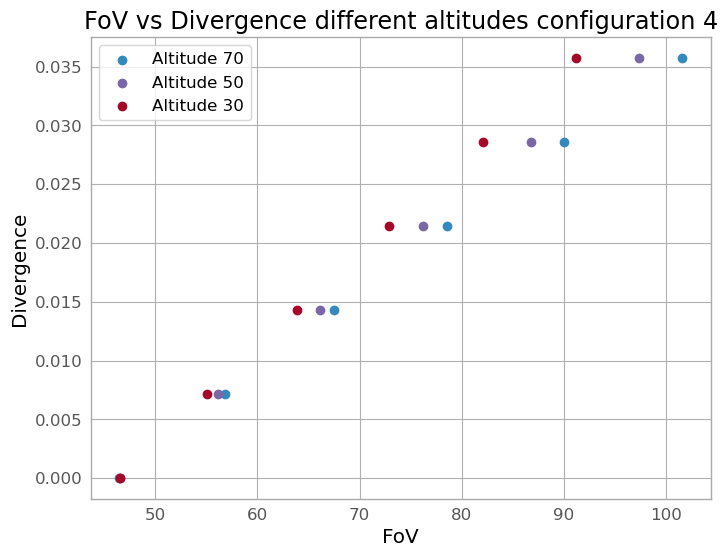

In [135]:
plt.scatter(hFoV_altitude_1_configuration_4,stop_div, label=f'Altitude {altitude_array[0]}')
plt.scatter(hFoV_altitude_2_configuration_4,stop_div, label=f'Altitude {altitude_array[1]}')
plt.scatter(hFoV_altitude_3_configuration_4,stop_div, label=f'Altitude {altitude_array[2]}')
plt.ylabel("Divergence")  
plt.xlabel("FoV") 
plt.title("FoV vs Divergence different altitudes configuration 4")  # Title of the plot
plt.legend()
plt.show()

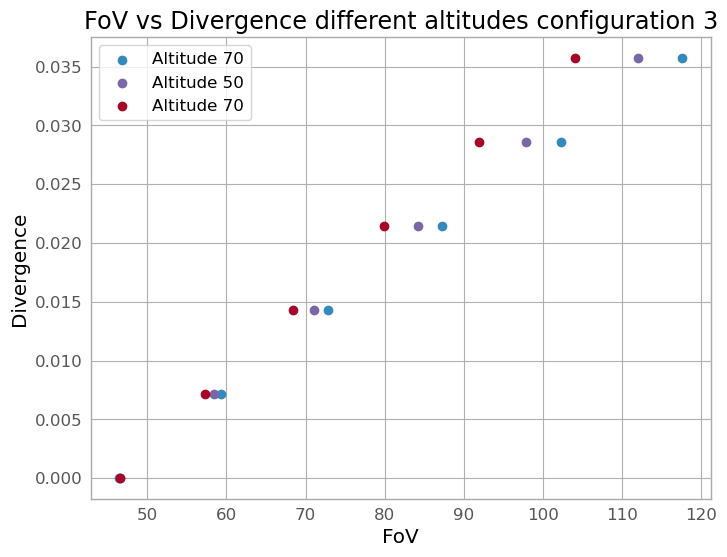

In [146]:
plt.scatter(hFoV_altitude_1_configuration_3,stop_div, label=f'Altitude {altitude_array[0]}')
plt.scatter(hFoV_altitude_2_configuration_3,stop_div, label=f'Altitude {altitude_array[1]}')
plt.scatter(hFoV_altitude_3_configuration_3,stop_div, label=f'Altitude {altitude_array[0]}')
plt.ylabel("Divergence")  
plt.xlabel("FoV") 
plt.title("FoV vs Divergence different altitudes configuration 3")  
plt.legend()
plt.show()

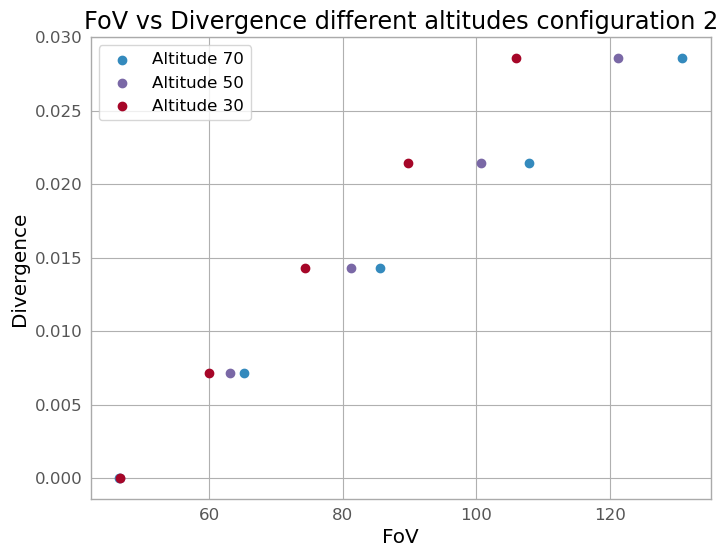

In [147]:
plt.scatter(hFoV_altitude_1_configuration_2,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[0]}')
plt.scatter(hFoV_altitude_2_configuration_2,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[1]}')
plt.scatter(hFoV_altitude_3_configuration_2,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[2]}')
plt.ylabel("Divergence")  
plt.xlabel("FoV") 
plt.title("FoV vs Divergence different altitudes configuration 2")  # Title of the plot
plt.legend()
plt.show()

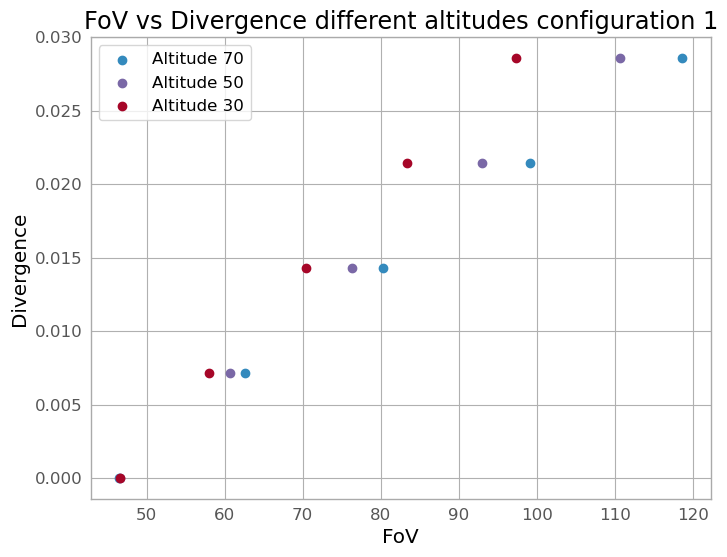

In [139]:
plt.scatter(hFoV_altitude_1_configuration_1,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[0]}')
plt.scatter(hFoV_altitude_2_configuration_1,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[1]}')
plt.scatter(hFoV_altitude_3_configuration_1,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[2]}')
plt.ylabel("Divergence")  
plt.xlabel("FoV") 
plt.title("FoV vs Divergence different altitudes configuration 1")  # Title of the plot
plt.legend()
plt.show()

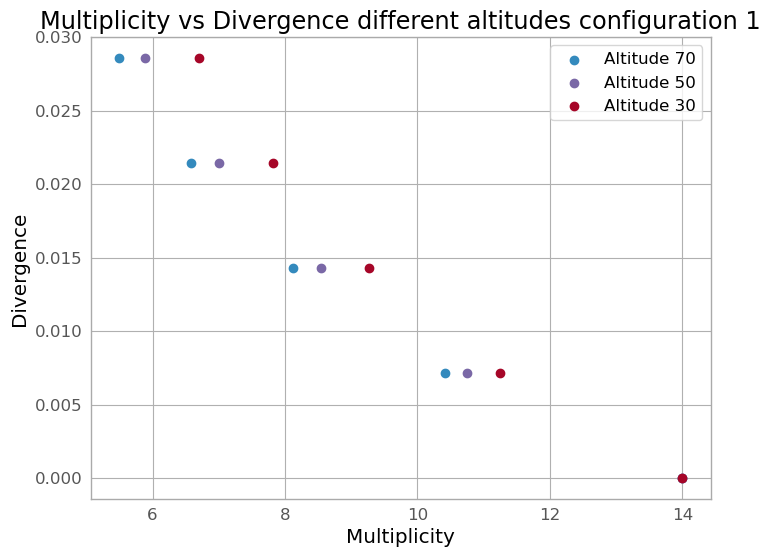

In [141]:
plt.scatter(multiplicity_altitude_1_configuration_1,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[0]}')
plt.scatter(multiplicity_altitude_2_configuration_1,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[1]}')
plt.scatter(multiplicity_altitude_3_configuration_1,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[2]}')
plt.ylabel("Divergence")  
plt.xlabel("Multiplicity") 
plt.title("Multiplicity vs Divergence different altitudes configuration 1")  # Title of the plot
plt.legend()
plt.show()

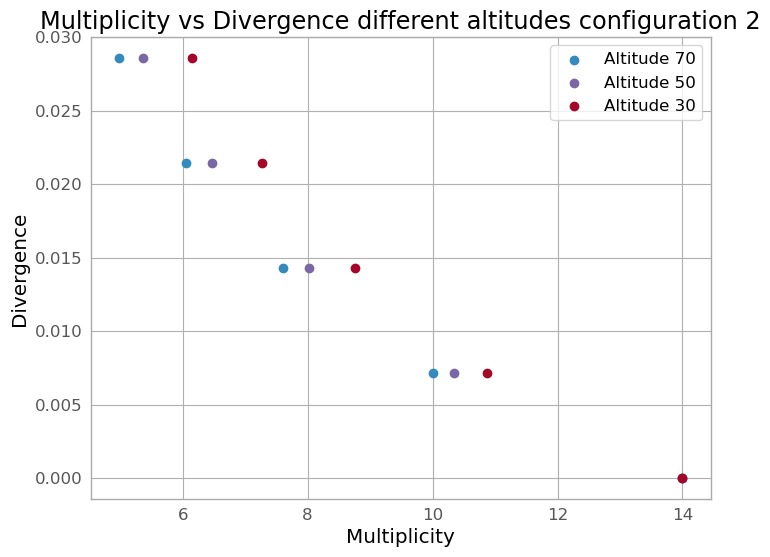

In [151]:
plt.scatter(multiplicity_altitude_1_configuration_2,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[0]}')
plt.scatter(multiplicity_altitude_2_configuration_2,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[1]}')
plt.scatter(multiplicity_altitude_3_configuration_2,stop_div_sub_1_2_full, label=f'Altitude {altitude_array[2]}')
plt.ylabel("Divergence")  
plt.xlabel("Multiplicity") 
plt.title("Multiplicity vs Divergence different altitudes configuration 2")  # Title of the plot
plt.legend()
plt.show()

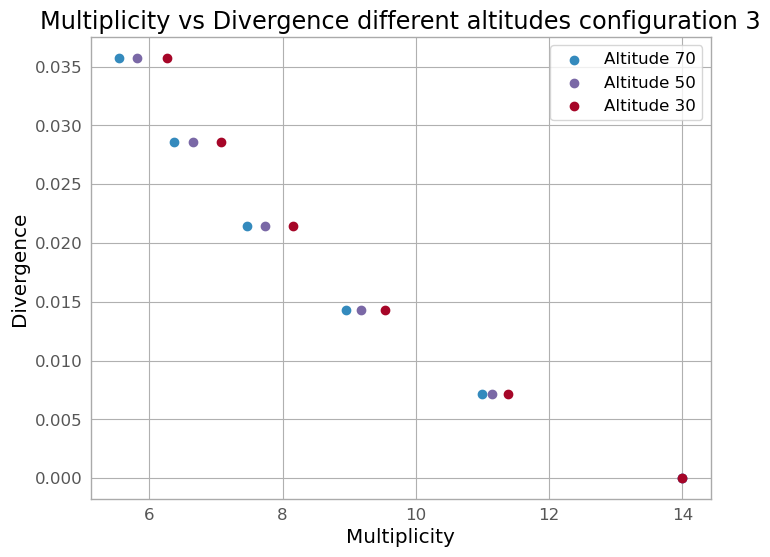

In [150]:
plt.scatter(multiplicity_altitude_1_configuration_3,stop_div, label=f'Altitude {altitude_array[0]}')
plt.scatter(multiplicity_altitude_2_configuration_3,stop_div, label=f'Altitude {altitude_array[1]}')
plt.scatter(multiplicity_altitude_3_configuration_3,stop_div, label=f'Altitude {altitude_array[2]}')
plt.ylabel("Divergence")  
plt.xlabel("Multiplicity") 
plt.title("Multiplicity vs Divergence different altitudes configuration 3")  # Title of the plot
plt.legend()
plt.show()

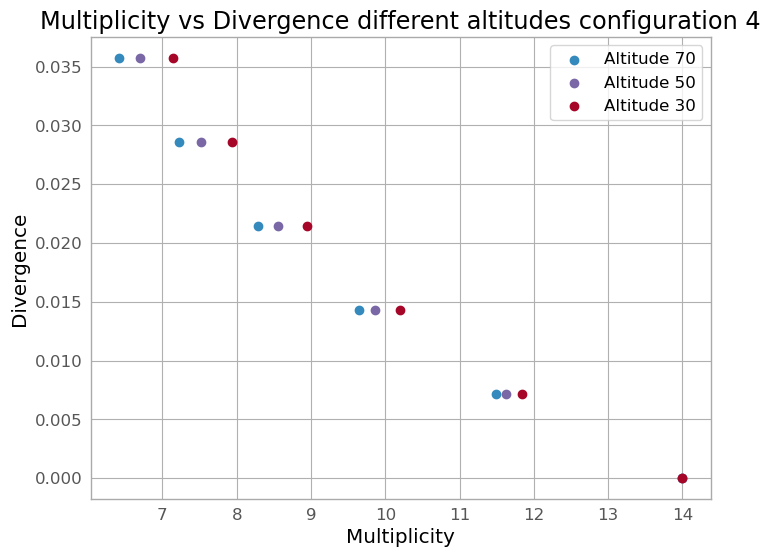

In [148]:
plt.scatter(multiplicity_altitude_1_configuration_4,stop_div, label=f'Altitude {altitude_array[0]}')
plt.scatter(multiplicity_altitude_2_configuration_4,stop_div, label=f'Altitude {altitude_array[1]}')
plt.scatter(multiplicity_altitude_3_configuration_4,stop_div, label=f'Altitude {altitude_array[2]}')
plt.ylabel("Divergence")  
plt.xlabel("Multiplicity") 
plt.title("Multiplicity vs Divergence different altitudes configuration 4")  # Title of the plot
plt.legend()
plt.show()